In [1]:
# load packages 
%matplotlib inline
import os
import glob
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import geopandas as gpd
import pyproj
import shapely.geometry
from shapely.geometry import Point
from matplotlib.colors import LogNorm
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter
import matplotlib as mpl
import numpy as np
import xarray as xr
import rioxarray as rxr
from geocube.api.core import make_geocube
import xesmf as xe
import cartopy.crs as ccrs
import contextily as ctx
from scipy import stats

# imports for rasterizing 
import geopandas as gpd
import rasterio
from rasterio import features
from rasterio.enums import MergeAlg
from rasterio.plot import show
import xwrf
# dask
import dask
from dask.distributed import Client, LocalCluster


# Load data and presets

In [82]:
# load data and set paths
home_path = Path('/home1/kojoseph/anthropogenic-heat-la-20230205')
data_path = home_path / 'data'
output_path = data_path / 'output'
plot_path = Path('/home1/kojoseph/ah-la-paper/figs')
# load urban area mask (based on WRF-out)
urban_area = gpd.read_file("/home1/kojoseph/ah-la-paper/data/urban_mask/wrf_urban_mask-v4.gpkg")
# load LA County boundary
la_county_filepath='/home1/kojoseph/anthropogenic-heat-la-20230205/data/boundaries/la_county_bound_simplified_3.geojson'
la_county_gdf = gpd.read_file(la_county_filepath)
# load LA City boundary
city_boundaries = gpd.read_file(data_path/'boundaries/City_Boundaries_SCAG_Region.zip')
la_boundary = city_boundaries[city_boundaries.CITY == 'Los Angeles']
la_boundary = la_boundary[['geometry']]
# load highway buffer geometry
highway_buffer = gpd.read_file(data_path / 'boundaries/highway_buffer_1km.gpkg')
highway_buffer = highway_buffer.to_crs('EPSG:4326')
# load neighborhoods 
neighborhoods_dir = data_path / 'boundaries/la_bound_nbhd.geojson'
neighborhoods = gpd.read_file(neighborhoods_dir)

In [ ]:
# pre-define labels for easy re-use
# \mathrm{} prevents exprsesion from getting italicized 
# \/ within the latex expression is necessary for an empty space
degree_sign = u'\N{DEGREE SIGN}'
del_ta_label = r'$\mathrm{{\Delta}T_{2m}}$ (' + degree_sign + 'C)'
del_tc_label = r'$\mathrm{{\Delta}T_{c}}$ (' + degree_sign + 'C)'
del_ahf_label = r'$\Delta \mathrm{AHF}$ (W m$^{-2}$)'
ahf_label = r'AHF ($\mathrm{W\/m^{-2}}$)'
del_ws_label = r'$\mathrm{{\Delta}}$WS ($\mathrm{m\/s^{-1}}$)'
del_pblh_label = r'$\mathrm{{\Delta}}$PBLH (m)'
# color shortcutes
max_red = '#DD1717'  # red
yale_blue = '#0F4392'  # blue
# where to save plots
plot_dir ='/home1/kojoseph/ah-la-paper/figs/draft_v2'
os.makedirs(plot_dir, exist_ok=True)

# AHF Distribution Analysis

## AHF Heatmaps

In [4]:
diurnal_path = output_path / '20231124/diurnal/08/weekday'
ahf_t = gpd.read_feather(diurnal_path / 'ahf_diurnal_control_traffic.feather')
ahf_b = gpd.read_feather(diurnal_path / 'ahf_diurnal_control_building.feather')
ahf_m = gpd.read_feather(diurnal_path / 'ahf_diurnal_control_metabolism.feather')
filename = 'ahf_diurnal_control_all.feather'
file_path = output_path / '20231124/diurnal/08/weekday' / filename
ahf_all = gpd.read_feather(file_path)

In [5]:
# create daily avg AHF dataframe
ahf_dict = {'t':ahf_t, 'b':ahf_b, 'm':ahf_m}
ahf_avg_dict = {}
for key in ahf_dict:
    df = ahf_dict[key]
    ahf_avg_dict[key] = df.iloc[:, -24:].mean(axis=1)
    
ahf_avg = ahf_t[['FID', 'geometry']].copy()
for key in ahf_avg_dict:
    column_label = 'ahf_' + key
    ahf_avg.insert(len(ahf_avg.columns), column_label, ahf_avg_dict[key])
ahf_avg['ahf_tot'] = ahf_avg['ahf_t'] + ahf_avg['ahf_b'] + ahf_avg['ahf_m']
ahf_avg.head()

FID                                           geometry  ahf_t  ahf_b  \
0  832323  POLYGON ((-118.45759 33.95103, -118.45759 33.9...    0.0    0.0   
1  832324  POLYGON ((-118.45761 33.95103, -118.45807 33.9...    0.0    0.0   
2  832325  POLYGON ((-118.45807 33.95177, -118.45849 33.9...    0.0    0.0   
3  830804  POLYGON ((-118.45849 33.95252, -118.45849 33.9...    0.0    0.0   
4  830805  POLYGON ((-118.45853 33.95252, -118.45899 33.9...    0.0    0.0   

   ahf_m  ahf_tot  
0    0.0      0.0  
1    0.0      0.0  
2    0.0      0.0  
3    0.0      0.0  
4    0.0      0.0

In [6]:
# create daily maximum (hr 13) ahf dataframe
ahf_val_dict = {}
for key, df in ahf_dict.items():
    ahf_val_dict[key] = df['ahf_13']   # pick the single column

# Build new GeoDataFrame with FID + geometry
ahf_max = ahf_t[['FID', 'geometry']].copy()

# Insert the selected ahf_13 values
for key in ahf_val_dict:
    column_label = 'ahf_' + key
    ahf_max.insert(len(ahf_max.columns), column_label, ahf_val_dict[key])

# Compute total
ahf_max['ahf_tot'] = ahf_max['ahf_t'] + ahf_max['ahf_b'] + ahf_max['ahf_m']

ahf_max.head()

FID                                           geometry  ahf_t  ahf_b  \
0  832323  POLYGON ((-118.45759 33.95103, -118.45759 33.9...    0.0    0.0   
1  832324  POLYGON ((-118.45761 33.95103, -118.45807 33.9...    0.0    0.0   
2  832325  POLYGON ((-118.45807 33.95177, -118.45849 33.9...    0.0    0.0   
3  830804  POLYGON ((-118.45849 33.95252, -118.45849 33.9...    0.0    0.0   
4  830805  POLYGON ((-118.45853 33.95252, -118.45899 33.9...    0.0    0.0   

   ahf_m  ahf_tot  
0    0.0      0.0  
1    0.0      0.0  
2    0.0      0.0  
3    0.0      0.0  
4    0.0      0.0

In [ ]:
# Rasterize into xarray dataset
# Assume gdf is your large GeoDataFrame
gdf_m = ahf_max.to_crs(epsg=32611)  # project to meters (important!)

# Choose your target resolution (50 meters)
resolution = 100

# Floor coordinates to nearest multiple of 50 m
gdf_m["x"] = (gdf_m.geometry.centroid.x // resolution) * resolution
gdf_m["y"] = (gdf_m.geometry.centroid.y // resolution) * resolution

# Find unique sorted coordinates
x_coords = np.sort(gdf_m["x"].unique())
y_coords = np.sort(gdf_m["y"].unique())[::-1]  # descending so north at top

nx = len(x_coords)
ny = len(y_coords)

# build mapping from coordinate value -> array index
x_index = {x: i for i, x in enumerate(x_coords)}
y_index = {y: i for i, y in enumerate(y_coords)}

# Convert x/y to index arrays (vectorized)
x_idx = gdf_m["x"].map(x_index).to_numpy()
y_idx = gdf_m["y"].map(y_index).to_numpy()

# Build data variables
data_vars = {}
for col in ["ahf_t", "ahf_b", "ahf_m", "ahf_tot"]:
    arr = np.full((ny, nx), np.nan, dtype="float32")
    arr[y_idx, x_idx] = gdf_m[col].to_numpy()
    data_vars[col] = (("y", "x"), arr)

# Build xarray Dataset
ds = xr.Dataset(
    data_vars=data_vars,
    coords={"x": x_coords, "y": y_coords},
    attrs={"crs": gdf_m.crs.to_string(), "resolution": 100} # insert target resolution
)

print(ds)

<xarray.Dataset>
Dimensions:  (y: 1250, x: 1211)
Coordinates:
  * x        (x) float64 3.2e+05 3.201e+05 3.202e+05 ... 4.409e+05 4.41e+05
  * y        (y) float64 3.854e+06 3.854e+06 3.854e+06 ... 3.73e+06 3.73e+06
Data variables:
    ahf_t    (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    ahf_b    (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    ahf_m    (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    ahf_tot  (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
Attributes:
    crs:         EPSG:32611
    resolution:  100


In [8]:
# remove everything under 0.1 W/m2 (turn to nan)
ds_nonan = ds.where(ds >= 0.1, np.nan)

In [9]:
# What are the CRS's of the dfs?
print(ds_nonan.crs)
print(la_county_gdf.crs)

EPSG:32611
epsg:4326


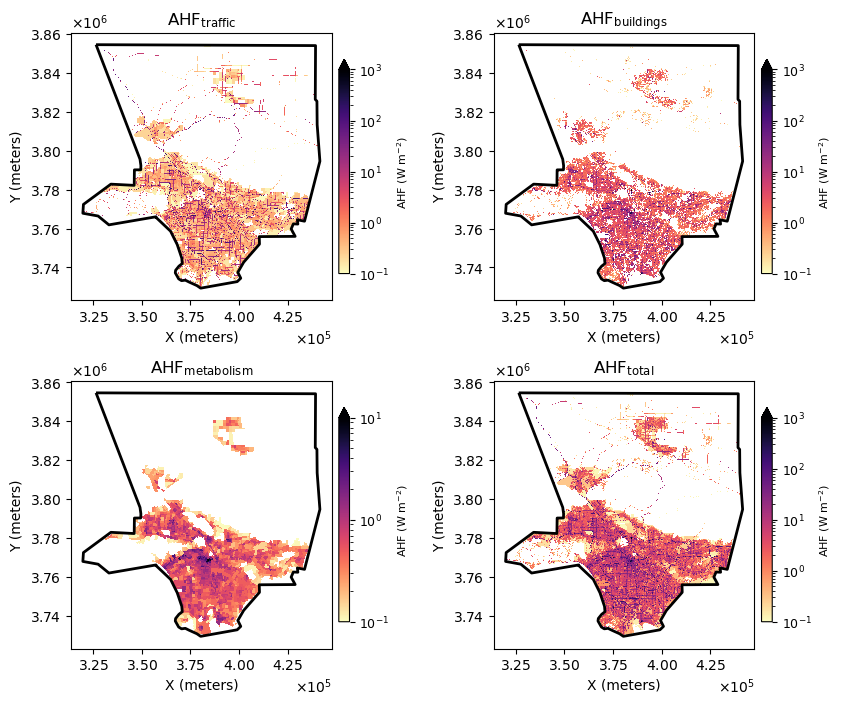

In [10]:
# Reproject LA County GeoDataFrame
la_county_gdf_utm = la_county_gdf.to_crs(ds_nonan.crs)

variables = ["ahf_t", "ahf_b", "ahf_m", "ahf_tot"]
cmaps = ["magma_r"]*4
vmax_values = [1000, 1000, 10, 1000]
vmin = 0.1
titles = [r"AHF$_{\mathrm{traffic}}$", r"AHF$_{\mathrm{buildings}}$",
          r"AHF$_{\mathrm{metabolism}}$", r"AHF$_{\mathrm{total}}$"]

# Create figure with gridspec
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, 2, wspace=0.2, hspace=0.3)  # set spacing here

title_fs = 12
label_fs = 10
tick_fs = 10
cb_label_fs = 8

for i, var in enumerate(variables):
    ax = fig.add_subplot(gs[i])
    
    # Plot data without colorbar
    im = ds_nonan[var].plot.imshow(
        x='x', y='y',
        cmap=cmaps[i],
        norm=LogNorm(vmin=vmin, vmax=vmax_values[i]),
        interpolation='none',
        ax=ax,
        add_colorbar=False
    )
    
    # Overlay LA County boundary
    la_county_gdf_utm.boundary.plot(ax=ax, color='black', linewidth=2)

    ax.set_aspect('equal')
    ax.set_title(titles[i], fontsize=title_fs)
    ax.set_xlabel("X (meters)", fontsize=label_fs)
    ax.set_ylabel("Y (meters)", fontsize=label_fs)
    
    # Axes formatting
    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.tick_params(labelsize=tick_fs)
    
    # Add colorbar manually
    cbar = fig.colorbar(im, ax=ax, shrink=0.8, pad=0.02, extend='max')
    cbar.set_label("AHF (W m$^{-2}$)", fontsize=cb_label_fs)
    cbar.ax.tick_params(labelsize=tick_fs-1)

save_path = os.path.join(plot_dir, 'ahf_plots.png')
fig.savefig(save_path, dpi=300, bbox_inches='tight') # save plot
plt.show()

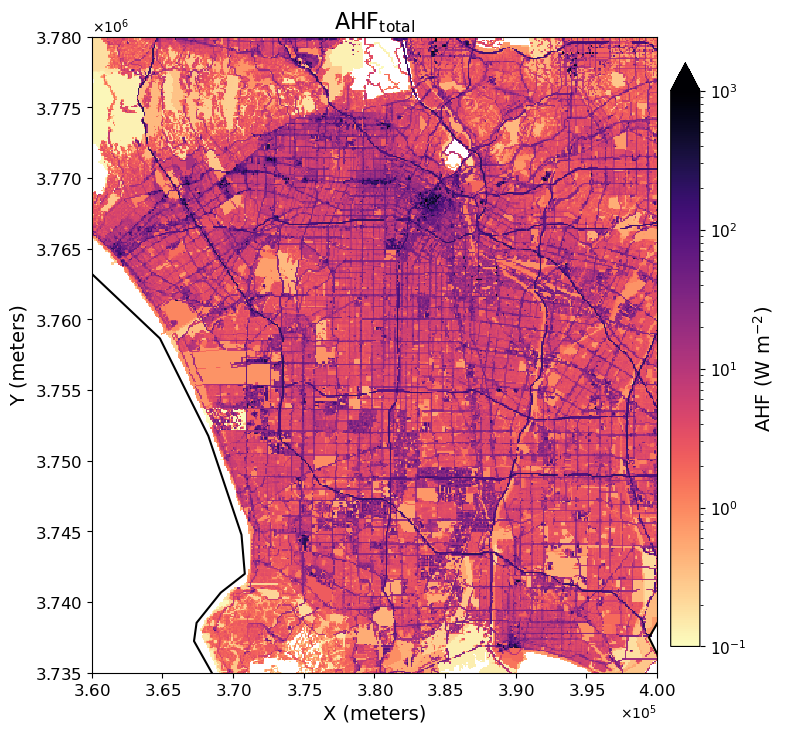

In [11]:
# Reproject LA County boundary to match xarray CRS
la_county_gdf_utm = la_county_gdf.to_crs(ds_nonan.crs)

# Select variable
var = "ahf_tot"
vmin = 0.1
vmax = 1000
cmap = "magma_r"
title = r"AHF$_{\mathrm{total}}$"

# Define zoomed-in limits (in meters, adjust as needed)
xlim_zoom = (3.6e5, 4.0e5)
ylim_zoom = (3.735e6, 3.78e6)

fig, ax = plt.subplots(figsize=(8, 8))  # square figure is fine, aspect is set by CRS

# Plot
im = ds_nonan[var].plot.imshow(
    x='x',
    y='y',
    cmap=cmap,
    norm=LogNorm(vmin=vmin, vmax=vmax),
    interpolation='none',
    ax=ax,
    add_colorbar=False
)

# Overlay LA County boundary
la_county_gdf_utm.boundary.plot(ax=ax, color='black', linewidth=1.5)

# Set zoomed-in limits
ax.set_xlim(xlim_zoom)
ax.set_ylim(ylim_zoom)

# Maintain true CRS aspect ratio (meters in x and y are equal)
ax.set_aspect('equal')

ax.set_title(title, fontsize=16)
ax.set_xlabel("X (meters)", fontsize=14)
ax.set_ylabel("Y (meters)", fontsize=14)

# Scientific notation for axes
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.tick_params(labelsize=12)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, shrink=0.8, pad=0.02, extend='max')
cbar.set_label("AHF (W m$^{-2}$)", fontsize=14)
cbar.ax.tick_params(labelsize=11)

plt.tight_layout()
save_path =  os.path.join(plot_dir, 'ahf_total_zoom.png')
fig.savefig(save_path, dpi=300, bbox_inches='tight') # save plot
plt.show()


## Diurnal Plots

In [12]:
# create diurnal ahf dataframe
ahf_all_avg = ahf_all.describe()
ahf_cols = [f"ahf_{i}" for i in range(24)]
# === LA County (ahf_all) === 
ahf_all_arr = ahf_all_avg.drop('FID', axis=1).loc['mean'].array
std_all_arr = ahf_all_avg.drop('FID', axis=1).loc['std'].array
# === Urban areas within LA County (ahf_urban) ===
ahf_urban = ahf_all.sjoin(urban_area, predicate='within')
# ahf_urban.drop('index_right', axis=1, inplace=True)
# ahf_urban_avg = ahf_urban.iloc[:,-24:].describe()
# ahf_urban_arr = ahf_urban_avg.loc['mean'].array
ahf_urban_arr = ahf_urban[ahf_cols].mean(axis=0)
# === City of LA (ahf_la) ===
ahf_la = ahf_all.sjoin(la_boundary, predicate='within')
# ahf_la.drop(columns = ['index_right', 'geometry'],inplace=True)
# ahf_la_avg = ahf_la.iloc[:,-24:].describe()
# ahf_la_arr = ahf_la_avg.loc['mean'].array
ahf_la_arr = ahf_la[ahf_cols].mean(axis=0)
# === Near highways within LA County (ahf_near_highway) === 
ahf_near_highway = ahf_all.sjoin(highway_buffer, predicate='within')
# ahf_near_highway.drop(columns=['index_right'], inplace=True)
# ahf_near_highway_avg = ahf_near_highway.describe()
# ahf_near_highway_arr = ahf_near_highway_avg.drop('FID', axis=1).loc['mean'].array
# std_near_highway_arr = ahf_near_highway_avg.drop('FID', axis=1).loc['std'].array
ahf_near_highway_arr = ahf_near_highway[ahf_cols].mean(axis=0)
std_near_highway_arr = ahf_near_highway[ahf_cols].std(axis=0)

# combine into single df 
hr_of_day = range(24)
df = pd.DataFrame({'hr':hr_of_day,
                   'ahf_near_highway':ahf_near_highway_arr,
                   'ahf_all':ahf_all_arr,
                   'ahf_la':ahf_la_arr,
                   'ahf_urban':ahf_urban_arr,
                  'std_near_highway':std_near_highway_arr,
                  'std_all':std_all_arr})

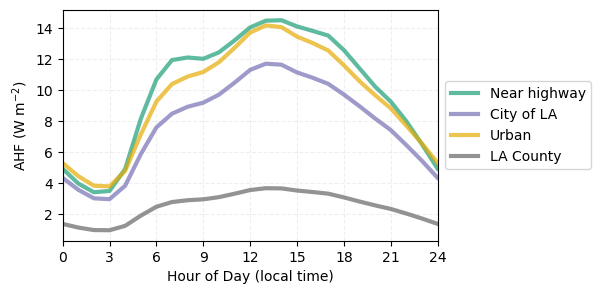

In [13]:
ahf_cols = ['ahf_near_highway', 'ahf_la', 'ahf_urban', 'ahf_all']
legend_labels = ['Near highway', 'City of LA', 'Urban', 'LA County']
# repeat the hr=0 values at hr=24 so the lines close/continue at 24
df_plot = df.set_index('hr').copy()
if 0 in df_plot.index:
    df_plot.loc[24] = df_plot.loc[0]
df_plot = df_plot.sort_index().reset_index()
fig, ax = plt.subplots(figsize=(6,3))
df_plot.plot(ax=ax, x='hr', y=ahf_cols, cmap='Dark2', linewidth=3, alpha=0.7)

# place legend outside the plot on the right
ax.legend(legend_labels, bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0)
ax.xaxis.set_ticks(np.arange(0, 25, 3))
ax.set_ylabel('AHF (W m$^{-2}$)')
ax.set_xlabel('Hour of Day (local time)')
ax.set_xlim(0, 24)
ax.grid(True, linestyle='--', alpha=0.2)

plt.subplots_adjust(right=0.75)  # give room for the external legend
filename = 'ahf_diurnal_by_agg.png'
save_path = os.path.join(plot_dir, filename)
plt.savefig(save_path, dpi=300, bbox_inches='tight')

## Neighborhood analysis

In [14]:
# Remove Catalina Island (including Avalon) from dataframe
catalina_index = neighborhoods.query('name.str.contains("Catalina") | name.str.contains("Avalon")').index
neighborhoods.drop(catalina_index, inplace=True)
# make neighborhoods name all lower-case to match energy atlas name column
neighborhoods['name'] = neighborhoods['name'].str.lower()
neighborhoods.head()

external_i             name  \
0            acton            acton   
1  adams-normandie  adams-normandie   
2     agoura-hills     agoura hills   
3       agua-dulce       agua dulce   
4         alhambra         alhambra   

                                        location             latitude slug_1  \
0  POINT(34.497355239240846 -118.16981019229348)  -118.16981019229348   None   
1  POINT(34.031461499124156 -118.30020800000011)  -118.30020800000011   None   
2  POINT(34.146736499122795 -118.75988450000015)  -118.75988450000015   None   
3   POINT(34.504926999796837 -118.3171036690717)   -118.3171036690717   None   
4  POINT(34.085538999123571 -118.13651200000021)  -118.13651200000021   None   

             sqmi                                         display_na  \
0   39.3391089485           Acton L.A. County Neighborhood (Current)   
1  0.805350187789  Adams-Normandie L.A. County Neighborhood (Curr...   
2   8.14676029818    Agoura Hills L.A. County Neighborhood (Current)   
3   31.4626319451      Agua Dulce L.A. County Neighborhood (Current)   
4   7.62381430605        Alhambra L.A. County Neighborhood (Current)   

                                   set             slug           longitude  \
0  L.A. County Neighborhoods (Current)            acton  34.497355239240846   
1  L.A. County Neighborhoods (Current)  adams-normandie  34.031461499124156   
2  L.A. County Neighborhoods (Current)     agoura-hills  34.146736499122795   
3  L.A. County Neighborhoods (Current)       agua-dulce  34.504926999796837   
4  L.A. County Neighborhoods (Current)         alhambra  34.085538999123571   

  name_1                                kind                 type  \
0   None  L.A. County Neighborhood (Current)  unincorporated-area   
1   None  L.A. County Neighborhood (Current)    segment-of-a-city   
2   None  L.A. County Neighborhood (Current)      standalone-city   
3   None  L.A. County Neighborhood (Current)  unincorporated-area   
4   None  L.A. County Neighborhood (Current)      standalone-city   

                                            geometry  
0  MULTIPOLYGON (((-118.20262 34.53899, -118.1894...  
1  MULTIPOLYGON (((-118.30901 34.03741, -118.3004...  
2  MULTIPOLYGON (((-118.76193 34.16820, -118.7263...  
3  MULTIPOLYGON (((-118.25468 34.55830, -118.2555...  
4  MULTIPOLYGON (((-118.12175 34.10504, -118.1168...

<AxesSubplot: >

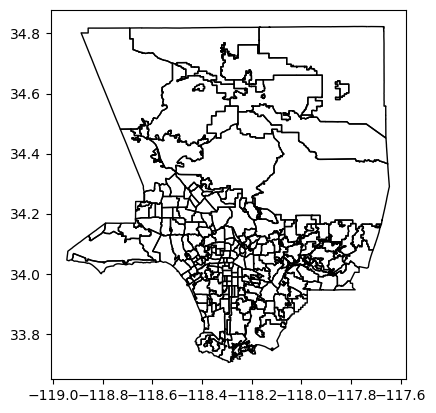

In [15]:
neighborhoods.plot(facecolor='None')

### Daily average

In [16]:
ahf_agg_hoods = ahf_avg.sjoin(neighborhoods, how='left', predicate='intersects')
ahf_agg_hoods.head()

FID                                           geometry  ahf_t  ahf_b  \
0  832323  POLYGON ((-118.45759 33.95103, -118.45759 33.9...    0.0    0.0   
1  832324  POLYGON ((-118.45761 33.95103, -118.45807 33.9...    0.0    0.0   
2  832325  POLYGON ((-118.45807 33.95177, -118.45849 33.9...    0.0    0.0   
3  830804  POLYGON ((-118.45849 33.95252, -118.45849 33.9...    0.0    0.0   
4  830805  POLYGON ((-118.45853 33.95252, -118.45899 33.9...    0.0    0.0   

   ahf_m  ahf_tot  index_right external_i name location latitude slug_1 sqmi  \
0    0.0      0.0          NaN        NaN  NaN      NaN      NaN    NaN  NaN   
1    0.0      0.0          NaN        NaN  NaN      NaN      NaN    NaN  NaN   
2    0.0      0.0          NaN        NaN  NaN      NaN      NaN    NaN  NaN   
3    0.0      0.0          NaN        NaN  NaN      NaN      NaN    NaN  NaN   
4    0.0      0.0          NaN        NaN  NaN      NaN      NaN    NaN  NaN   

  display_na  set slug longitude name_1 kind type  
0        NaN  NaN  NaN       NaN    NaN  NaN  NaN  
1        NaN  NaN  NaN       NaN    NaN  NaN  NaN  
2        NaN  NaN  NaN       NaN    NaN  NaN  NaN  
3        NaN  NaN  NaN       NaN    NaN  NaN  NaN  
4        NaN  NaN  NaN       NaN    NaN  NaN  NaN

In [17]:
col_list = ['FID', 'name', 'ahf_b', 
            'ahf_m', 'ahf_t','ahf_tot']
df = ahf_agg_hoods[col_list].copy()
fill_cols = []
for column in df.columns:
    if ('ahf' in column):
        fill_cols.append(column)
df[fill_cols] = df[fill_cols].fillna(0)
df.head()

FID name  ahf_b  ahf_m  ahf_t  ahf_tot
0  832323  NaN    0.0    0.0    0.0      0.0
1  832324  NaN    0.0    0.0    0.0      0.0
2  832325  NaN    0.0    0.0    0.0      0.0
3  830804  NaN    0.0    0.0    0.0      0.0
4  830805  NaN    0.0    0.0    0.0      0.0

In [18]:
df_sum = df.groupby('name', as_index=False).agg({'name':'first',
                                                 'ahf_b':'mean',
                                                 'ahf_m':'mean',
                                                 'ahf_t':'mean',
                                                'ahf_tot':'mean'})
df_sum

name     ahf_b     ahf_m      ahf_t    ahf_tot
0              acton  0.057224  0.003927   0.587169   0.648320
1    adams-normandie  2.947090  0.807480  14.058099  17.812669
2       agoura hills  1.273868  0.094300   3.320174   4.688342
3         agua dulce  0.037293  0.004425   0.471916   0.513634
4           alhambra  3.734459  0.431976   5.504542   9.670976
..               ...       ...       ...        ...        ...
265      willowbrook  3.533304  0.375009   4.826221   8.734534
266       wilmington  3.637290  0.258838   3.325355   7.221482
267   windsor square  4.455653  0.430984   4.739339   9.625975
268         winnetka  2.960839  0.409690   3.291327   6.661856
269   woodland hills  2.679037  0.234321   3.643057   6.556416

[270 rows x 5 columns]

In [19]:
df_sum_sorted = df_sum.sort_values(by='ahf_tot', ascending=False)

In [20]:
df = df_sum_sorted
df['f_traffic'] = df['ahf_t']/df['ahf_tot']
df['f_building'] = df['ahf_b']/df['ahf_tot']
df['f_metabolism'] = df['ahf_m']/df['ahf_tot']
df_sum_sorted.head(20)

name      ahf_b     ahf_m      ahf_t    ahf_tot  \
59                 downtown  19.706390  1.113406  15.449724  36.269520   
230         university park  17.148950  1.008464  16.689608  34.847022   
229          universal city  21.325421  0.366269  12.702402  34.394092   
38             century city  26.432222  1.308241   6.577272  34.317735   
74           elysian valley   2.769894  0.307545  24.570172  27.647611   
259                westlake  11.904674  1.605122  11.832863  25.342658   
172              pico-union   6.187018  0.989541  16.487277  23.663837   
103               hollywood  12.642239  0.977089   7.658878  21.278206   
198                sawtelle   7.444815  0.668263  12.831060  20.944138   
112               koreatown  12.511621  1.513304   6.690153  20.715078   
165                   palms   5.346422  0.693089  14.489040  20.528552   
102  historic south-central   8.681896  0.806054  10.736634  20.224584   
94          harvard heights   5.728384  0.854392  13.487093  20.069868   
63           east hollywood   9.436473  1.182199   9.409554  20.028226   
181             rancho park   3.704161  0.395893  14.861729  18.961783   
248              west adams   4.553012  0.533667  13.076382  18.163061   
23            beverly grove  12.714593  0.807274   4.547856  18.069723   
45                chinatown   9.273700  0.946674   7.819305  18.039680   
1           adams-normandie   2.947090  0.807480  14.058099  17.812669   
26            boyle heights   4.400532  0.623495  12.493932  17.517959   

     f_traffic  f_building  f_metabolism  
59    0.425970    0.543332      0.030698  
230   0.478939    0.492121      0.028940  
229   0.369319    0.620032      0.010649  
38    0.191658    0.770220      0.038121  
74    0.888691    0.100186      0.011124  
259   0.466915    0.469748      0.063337  
172   0.696729    0.261455      0.041817  
103   0.359940    0.594140      0.045920  
198   0.612633    0.355461      0.031907  
112   0.322961    0.603986      0.073053  
165   0.705799    0.260438      0.033762  
102   0.530870    0.429274      0.039855  
94    0.672007    0.285422      0.042571  
63    0.469815    0.471159      0.059027  
181   0.783773    0.195349      0.020878  
248   0.719944    0.250674      0.029382  
23    0.251684    0.703641      0.044675  
45    0.433450    0.514072      0.052477  
1     0.789219    0.165449      0.045332  
26    0.713207    0.251201      0.035592

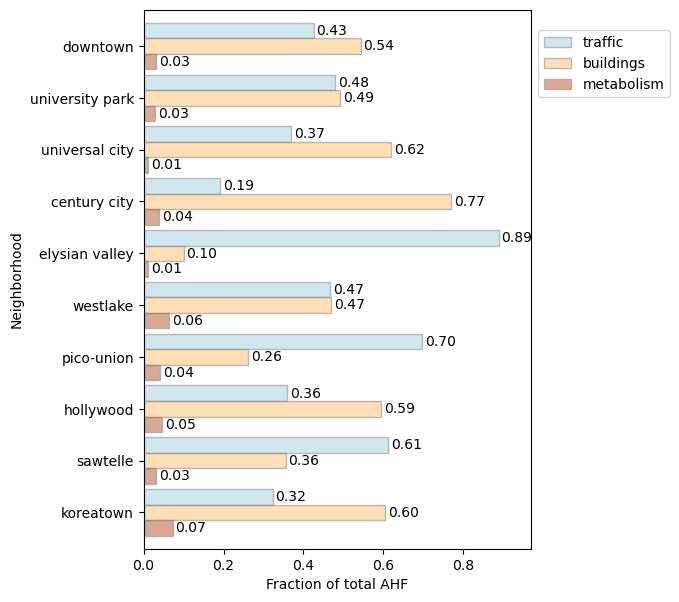

In [21]:
# plot grouped proportions for top 10
df = df_sum_sorted.head(10)
df = df[['name', 'f_traffic', 'f_building', 'f_metabolism']]
fig, ax = plt.subplots(figsize=(5,7))
df.plot(ax=ax, kind='barh', x='name', 
        width=0.9, alpha=0.5, cmap='Paired',
       edgecolor='gray')
ax.invert_yaxis()

for x in ax.containers:
    ax.bar_label(x, padding=2, fmt='%.2f')
ax.set_xlim(0, 0.97)
# ax.set_ylim(0, 0.97)
ax.set_ylabel('Neighborhood')
ax.set_xlabel('Fraction of total AHF')
legend_labels = ['traffic', 'buildings', 'metabolism']
plt.legend(legend_labels, loc='center left', bbox_to_anchor=(1.0, 0.9))

filename = 'barplot_f_sector_top10.png'
file_path = os.path.join(plot_dir, filename)
plt.savefig(file_path, dpi=300, bbox_inches='tight')
# issue with plot saving with sides cut off, use bbox_inches parameter

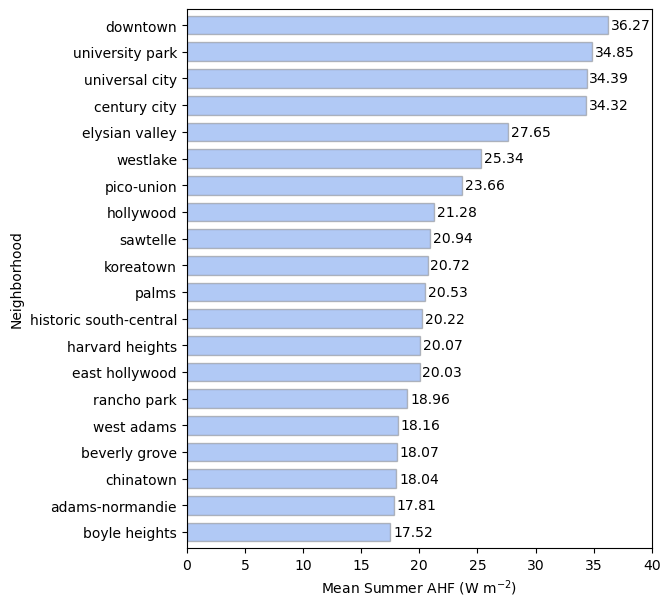

In [22]:
# plot ahf_total for top 20
df = df_sum_sorted.head(20)
df = df[['name', 'ahf_tot']]
fig, ax = plt.subplots(figsize=(6,7))
df.plot(ax=ax, kind='barh', x='name', 
        edgecolor='gray', color='cornflowerblue',
        alpha=0.5, width=0.7, legend=False)
ax.bar_label(ax.containers[0], padding=2, fmt='%.2f')
ax.invert_yaxis()
ax.set_xlim(0, 40)
ax.set_ylabel('Neighborhood')
ax.set_xlabel('Mean Summer AHF (W m$^{-2}$)')
filename = 'barplot_ahf_aug_avg_top20.png'
file_path = os.path.join(plot_dir, filename)
plt.savefig(file_path, dpi=300, bbox_inches='tight')

In [23]:
# Which neighborhoods have highest f_traffic?
df = df_sum_sorted
df = df[df.ahf_tot>10]
df.sort_values('f_traffic', ascending=False).head(20)

name     ahf_b     ahf_m      ahf_t    ahf_tot  \
73               elysian park  0.546039  0.107950  11.084512  11.738502   
74             elysian valley  2.769894  0.307545  24.570172  27.647611   
242   veterans administration  1.861493  0.274348  13.290495  15.426336   
239             vermont vista  2.172150  0.530729  14.714535  17.417414   
29        broadway-manchester  2.336711  0.603557  13.989909  16.930177   
257  west whittier-los nietos  1.806444  0.334998   9.705630  11.847072   
54                   del aire  2.553075  0.361472  12.459829  15.374376   
147             mission hills  2.257968  0.281205  10.616782  13.155955   
9                      arleta  1.732179  0.379385   8.814313  10.925877   
12                     athens  1.976782  0.266537   8.859697  11.103016   
1             adams-normandie  2.947090  0.807480  14.058099  17.812669   
129                    lennox  2.318690  0.631470  10.864286  13.814446   
181               rancho park  3.704161  0.395893  14.861729  18.961783   
234            valley village  3.840415  0.422599  12.782086  17.045100   
127                  lawndale  2.925951  0.598775  10.320764  13.845490   
131           lincoln heights  2.544809  0.512256   8.908214  11.965278   
240           vermont-slauson  3.567323  0.696776  11.424158  15.688258   
53               cypress park  3.090513  0.517437   9.446652  13.054603   
10          arlington heights  3.759087  0.699953  11.507259  15.966299   
248                west adams  4.553012  0.533667  13.076382  18.163061   

     f_traffic  f_building  f_metabolism  
73    0.944287    0.046517      0.009196  
74    0.888691    0.100186      0.011124  
242   0.861546    0.120670      0.017784  
239   0.844817    0.124711      0.030471  
29    0.826330    0.138020      0.035650  
257   0.819243    0.152480      0.028277  
54    0.810428    0.166060      0.023511  
147   0.806994    0.171631      0.021375  
9     0.806737    0.158539      0.034724  
12    0.797954    0.178040      0.024006  
1     0.789219    0.165449      0.045332  
129   0.786444    0.167845      0.045711  
181   0.783773    0.195349      0.020878  
234   0.749898    0.225309      0.024793  
127   0.745424    0.211329      0.043247  
131   0.744505    0.212683      0.042812  
240   0.728198    0.227388      0.044414  
53    0.723626    0.236737      0.039636  
10    0.720722    0.235439      0.043839  
248   0.719944    0.250674      0.029382

In [24]:
# Which neighborhoods have highest f_building?
df = df_sum_sorted
df = df[df.ahf_tot>10]
df.sort_values('f_building', ascending=False).head(20)

name      ahf_b     ahf_m      ahf_t    ahf_tot  f_traffic  \
70         el segundo   9.751929  0.338575   1.935284  12.025789   0.160928   
38       century city  26.432222  1.308241   6.577272  34.317735   0.191658   
250      west compton   9.169967  0.255956   2.696411  12.122334   0.222433   
179  rancho dominguez  12.310907  0.177823   4.368311  16.857041   0.259139   
23      beverly grove  12.714593  0.807274   4.547856  18.069723   0.251684   
241            vernon  10.128172  0.183881   4.445484  14.757537   0.301235   
253    west hollywood  10.297872  0.768406   4.253845  15.320123   0.277664   
197      santa monica   6.713752  0.592939   3.102806  10.409497   0.298075   
229    universal city  21.325421  0.366269  12.702402  34.394092   0.369319   
77            fairfax   7.640678  0.553076   4.308323  12.502077   0.344609   
112         koreatown  12.511621  1.513304   6.690153  20.715078   0.322961   
103         hollywood  12.642239  0.977089   7.658878  21.278206   0.359940   
106   huntington park   6.005080  0.749860   4.069308  10.824248   0.375944   
49            compton   6.002346  0.406520   4.483685  10.892552   0.411629   
171    pico-robertson   6.678464  0.643422   4.804136  12.126022   0.396184   
33             carson   7.080782  0.237444   5.613947  12.932173   0.434107   
59           downtown  19.706390  1.113406  15.449724  36.269520   0.425970   
37    central-alameda   6.836630  0.743107   5.050728  12.630465   0.399885   
13    atwater village   5.664316  0.290577   4.778788  10.733680   0.445214   
45          chinatown   9.273700  0.946674   7.819305  18.039680   0.433450   

     f_building  f_metabolism  
70     0.810918      0.028154  
38     0.770220      0.038121  
250    0.756452      0.021114  
179    0.730312      0.010549  
23     0.703641      0.044675  
241    0.686305      0.012460  
253    0.672179      0.050157  
197    0.644964      0.056961  
229    0.620032      0.010649  
77     0.611153      0.044239  
112    0.603986      0.073053  
103    0.594140      0.045920  
106    0.554780      0.069276  
49     0.551051      0.037321  
171    0.550755      0.053061  
33     0.547532      0.018361  
59     0.543332      0.030698  
37     0.541281      0.058834  
13     0.527714      0.027071  
45     0.514072      0.052477

In [25]:
# Which neighborhoods have highest ahf_traffic?
df = df_sum_sorted
df = df[df.ahf_tot>10]
df.sort_values('ahf_t', ascending=False).head(20)

name      ahf_b     ahf_m      ahf_t    ahf_tot  \
74            elysian valley   2.769894  0.307545  24.570172  27.647611   
230          university park  17.148950  1.008464  16.689608  34.847022   
172               pico-union   6.187018  0.989541  16.487277  23.663837   
59                  downtown  19.706390  1.113406  15.449724  36.269520   
181              rancho park   3.704161  0.395893  14.861729  18.961783   
239            vermont vista   2.172150  0.530729  14.714535  17.417414   
165                    palms   5.346422  0.693089  14.489040  20.528552   
1            adams-normandie   2.947090  0.807480  14.058099  17.812669   
29       broadway-manchester   2.336711  0.603557  13.989909  16.930177   
94           harvard heights   5.728384  0.854392  13.487093  20.069868   
242  veterans administration   1.861493  0.274348  13.290495  15.426336   
248               west adams   4.553012  0.533667  13.076382  18.163061   
198                 sawtelle   7.444815  0.668263  12.831060  20.944138   
234           valley village   3.840415  0.422599  12.782086  17.045100   
229           universal city  21.325421  0.366269  12.702402  34.394092   
26             boyle heights   4.400532  0.623495  12.493932  17.517959   
54                  del aire   2.553075  0.361472  12.459829  15.374376   
259                 westlake  11.904674  1.605122  11.832863  25.342658   
10         arlington heights   3.759087  0.699953  11.507259  15.966299   
237           vermont knolls   4.914080  0.688704  11.496623  17.099406   

     f_traffic  f_building  f_metabolism  
74    0.888691    0.100186      0.011124  
230   0.478939    0.492121      0.028940  
172   0.696729    0.261455      0.041817  
59    0.425970    0.543332      0.030698  
181   0.783773    0.195349      0.020878  
239   0.844817    0.124711      0.030471  
165   0.705799    0.260438      0.033762  
1     0.789219    0.165449      0.045332  
29    0.826330    0.138020      0.035650  
94    0.672007    0.285422      0.042571  
242   0.861546    0.120670      0.017784  
248   0.719944    0.250674      0.029382  
198   0.612633    0.355461      0.031907  
234   0.749898    0.225309      0.024793  
229   0.369319    0.620032      0.010649  
26    0.713207    0.251201      0.035592  
54    0.810428    0.166060      0.023511  
259   0.466915    0.469748      0.063337  
10    0.720722    0.235439      0.043839  
237   0.672340    0.287383      0.040276

In [26]:
# Which neighborhoods have highest ahf_building?
df = df_sum_sorted
df = df[df.ahf_tot>10]
df.sort_values('ahf_b', ascending=False).head(20)

name      ahf_b     ahf_m      ahf_t    ahf_tot  \
38             century city  26.432222  1.308241   6.577272  34.317735   
229          universal city  21.325421  0.366269  12.702402  34.394092   
59                 downtown  19.706390  1.113406  15.449724  36.269520   
230         university park  17.148950  1.008464  16.689608  34.847022   
23            beverly grove  12.714593  0.807274   4.547856  18.069723   
103               hollywood  12.642239  0.977089   7.658878  21.278206   
112               koreatown  12.511621  1.513304   6.690153  20.715078   
179        rancho dominguez  12.310907  0.177823   4.368311  16.857041   
259                westlake  11.904674  1.605122  11.832863  25.342658   
253          west hollywood  10.297872  0.768406   4.253845  15.320123   
241                  vernon  10.128172  0.183881   4.445484  14.757537   
70               el segundo   9.751929  0.338575   1.935284  12.025789   
63           east hollywood   9.436473  1.182199   9.409554  20.028226   
45                chinatown   9.273700  0.946674   7.819305  18.039680   
250            west compton   9.169967  0.255956   2.696411  12.122334   
102  historic south-central   8.681896  0.806054  10.736634  20.224584   
77                  fairfax   7.640678  0.553076   4.308323  12.502077   
198                sawtelle   7.444815  0.668263  12.831060  20.944138   
34                  carthay   7.349921  0.650710   6.929320  14.929950   
78                 florence   7.190617  0.693533   8.914423  16.798573   

     f_traffic  f_building  f_metabolism  
38    0.191658    0.770220      0.038121  
229   0.369319    0.620032      0.010649  
59    0.425970    0.543332      0.030698  
230   0.478939    0.492121      0.028940  
23    0.251684    0.703641      0.044675  
103   0.359940    0.594140      0.045920  
112   0.322961    0.603986      0.073053  
179   0.259139    0.730312      0.010549  
259   0.466915    0.469748      0.063337  
253   0.277664    0.672179      0.050157  
241   0.301235    0.686305      0.012460  
70    0.160928    0.810918      0.028154  
63    0.469815    0.471159      0.059027  
45    0.433450    0.514072      0.052477  
250   0.222433    0.756452      0.021114  
102   0.530870    0.429274      0.039855  
77    0.344609    0.611153      0.044239  
198   0.612633    0.355461      0.031907  
34    0.464122    0.492294      0.043584  
78    0.530665    0.428049      0.041285

### Diurnal plots

In [27]:
ahf_hoods_diurnal = ahf_all.sjoin(neighborhoods, how='left', predicate='intersects')
agg_dict = {}
for column in ahf_hoods_diurnal.columns:
    if column == 'name':
        agg_dict[column] = 'first'
    elif 'ahf' in column: 
        agg_dict[column] = 'mean'
col_list = list(agg_dict.keys())
ahf_hoods_diurnal_agg = ahf_hoods_diurnal[col_list]
ahf_hoods_diurnal_agg.head()

ahf_0  ahf_1  ahf_2  ahf_3  ahf_4  ahf_5  ahf_6  ahf_7  ahf_8  ahf_9  ...  \
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
2    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
3    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
4    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   

   ahf_15  ahf_16  ahf_17  ahf_18  ahf_19  ahf_20  ahf_21  ahf_22  ahf_23  \
0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   name  
0   NaN  
1   NaN  
2   NaN  
3   NaN  
4   NaN  

[5 rows x 25 columns]

In [28]:
ahf_hoods_diurnal_agg.set_index('name')
ahf_hoods_sums = ahf_hoods_diurnal_agg.groupby('name', as_index=False).agg(agg_dict)
name_column = ahf_hoods_sums.pop('name')
ahf_hoods_sums.insert(0, 'name', name_column)

df = ahf_hoods_sums.set_index('name').T
df = df.sort_values(by='ahf_12', axis=1, ascending=True)
df.reset_index(inplace=True)
new_col = list(df.index)
df.insert(loc=0, column='hr', value=new_col)
df.head()

name  hr  index  angeles crest  lake hughes  northwest antelope valley  \
0      0  ahf_0       0.013164     0.016706                   0.034132   
1      1  ahf_1       0.009556     0.014443                   0.025000   
2      2  ahf_2       0.008197     0.012087                   0.021541   
3      3  ahf_3       0.009118     0.011763                   0.023811   
4      4  ahf_4       0.015861     0.013582                   0.040629   

name  northeast antelope valley  leona valley  elizabeth lake  hasley canyon  \
0                      0.037646      0.069910        0.080801       0.123923   
1                      0.027823      0.052900        0.061474       0.099852   
2                      0.024072      0.045512        0.053123       0.083837   
3                      0.026577      0.048692        0.055970       0.077855   
4                      0.044889      0.077141        0.085976       0.094211   

name  castaic canyons  ...  beverly grove  hollywood  pico-union  koreatown  \
0            0.096775  ...      10.184692  12.308184   11.387959  12.295614   
1            0.074789  ...       8.717003  10.666140    9.048369  10.378232   
2            0.062651  ...       6.974980   9.172422    7.741577   8.456247   
3            0.062847  ...       6.617023   8.941250    7.941813   7.986785   
4            0.091634  ...       7.705884  10.588577   11.396966   9.426113   

name  elysian valley   westlake  universal city  university park  \
0          11.454841  13.657677       20.576149        16.865242   
1           8.590676  11.317776       19.130495        14.076577   
2           7.417274   9.358856       18.518590        11.599343   
3           8.053074   9.133625       18.879173        11.722553   
4          13.201026  11.665510       21.565855        15.529713   

name  century city   downtown  
0        19.772222  17.651177  
1        17.600682  15.097883  
2        14.946026  12.647760  
3        14.482217  12.775594  
4        16.143517  16.355910  

[5 rows x 272 columns]

In [29]:
# add hr 24
df_zero = df[df['hr'] == 0].copy()
if df_zero.empty:
    raise ValueError("No row found with hr == 0")

# set hr to 24 on the duplicated row(s)
df_zero['hr'] = 24

# optionally update name/index fields if they encode the hour (e.g. "ahf_0" -> "ahf_24")
for col in ('name', 'index'):
    if col in df_zero.columns:
        df_zero[col] = df_zero[col].astype(str).str.replace(r'(\D)0\b|^0\b', r'\124', regex=True)

# append and re-sort by hr (and reset index)
df = pd.concat([df, df_zero], ignore_index=True)
df = df.sort_values('hr').reset_index(drop=True)
df.head()

name  hr  index  angeles crest  lake hughes  northwest antelope valley  \
0      0  ahf_0       0.013164     0.016706                   0.034132   
1      1  ahf_1       0.009556     0.014443                   0.025000   
2      2  ahf_2       0.008197     0.012087                   0.021541   
3      3  ahf_3       0.009118     0.011763                   0.023811   
4      4  ahf_4       0.015861     0.013582                   0.040629   

name  northeast antelope valley  leona valley  elizabeth lake  hasley canyon  \
0                      0.037646      0.069910        0.080801       0.123923   
1                      0.027823      0.052900        0.061474       0.099852   
2                      0.024072      0.045512        0.053123       0.083837   
3                      0.026577      0.048692        0.055970       0.077855   
4                      0.044889      0.077141        0.085976       0.094211   

name  castaic canyons  ...  beverly grove  hollywood  pico-union  koreatown  \
0            0.096775  ...      10.184692  12.308184   11.387959  12.295614   
1            0.074789  ...       8.717003  10.666140    9.048369  10.378232   
2            0.062651  ...       6.974980   9.172422    7.741577   8.456247   
3            0.062847  ...       6.617023   8.941250    7.941813   7.986785   
4            0.091634  ...       7.705884  10.588577   11.396966   9.426113   

name  elysian valley   westlake  universal city  university park  \
0          11.454841  13.657677       20.576149        16.865242   
1           8.590676  11.317776       19.130495        14.076577   
2           7.417274   9.358856       18.518590        11.599343   
3           8.053074   9.133625       18.879173        11.722553   
4          13.201026  11.665510       21.565855        15.529713   

name  century city   downtown  
0        19.772222  17.651177  
1        17.600682  15.097883  
2        14.946026  12.647760  
3        14.482217  12.775594  
4        16.143517  16.355910  

[5 rows x 272 columns]

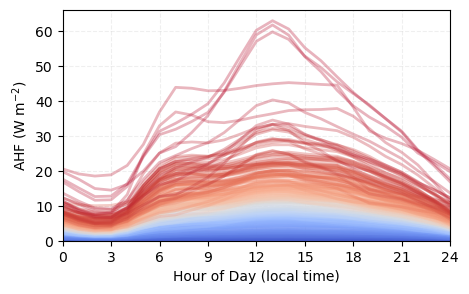

In [30]:
fig, ax = plt.subplots(figsize=(5,3))
df.plot(ax=ax, x='hr', y=list(df.columns[-270:]), legend=False, 
          linewidth = 2, alpha=0.3, cmap='coolwarm')
ax.xaxis.set_ticks(np.arange(0, 25, 3))
ax.set_ylabel('AHF (W m$^{-2}$)')
ax.set_xlabel('Hour of Day (local time)')
ax.grid(True, linestyle='--', alpha=0.2)
ax.set_ylim(bottom=0)
ax.set_xlim(0, 24)
filename = 'ahf_diurnal_profiles_neighborhoods.png'
save_path = os.path.join(plot_dir, filename)
plt.savefig(save_path, dpi=300, bbox_inches='tight')

In [31]:
# get bottom 5 neighborhoods
df_low = df.iloc[:,:7]
df_low.set_index('index', inplace=True)
df_low = df_low.sort_values(by='ahf_12', axis=1, ascending=False)
df_low.reset_index(inplace=True)

# get top 5 neighborhoods
df_high = df.iloc[:,-5:]
df_high = df_low.iloc[:,:1].join(df_high)
df_high.set_index('index', inplace=True)
df_high = df_high.sort_values(by='ahf_12', axis=1, ascending=False)
df_high.reset_index(inplace=True)
df_high.insert(loc=0, column='hr', value=list(df_high.index))

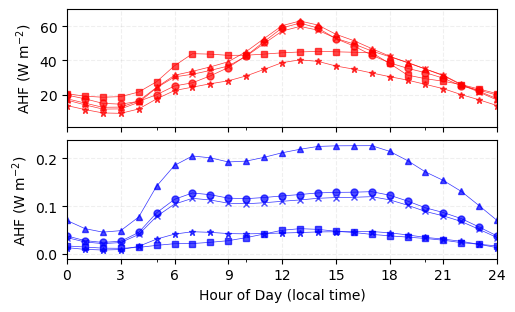

In [33]:
markers = ['^', 'o', 'x', 's', '*']
bottom_hoods = ['Lake Hughes', 'Angeles Crest', 'Northwest Antelope Valley',
                 'Northeast Antelope Valley', 'Hasley Canyon']
top_hoods = ['Downtown', 'University Park', 'Century City',
                 'Universal City', 'Elysian Valley']

fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(5, 3), sharex=True, sharey=False, constrained_layout=True
)

# --- Top 5 neighborhoods ---
df_high.plot(
    ax=ax1, x='hr', y=list(df_high.columns[-5:]),
    alpha=0.7, color='red', style=markers, ms=5, legend=False
)
df_high.plot(
    ax=ax1, x='hr', y=list(df_high.columns[-5:]),
    linewidth=0.5, alpha=0.8, color='red', legend=False
)
ax1.set_ylabel('AHF (W m$^{-2}$)')
ax1.grid(True, linestyle='--', alpha=0.2)
ax1.set_ylim(bottom=1, top=70)
ax1.set_xlim(0, 24)
ax1.xaxis.set_ticks(np.arange(0, 25, 3))
# ax2.set_title('Top 5 Neighborhoods', fontsize=10)
# ax2.legend(top_hoods, loc='center left', bbox_to_anchor=(1, 0.5))

# --- Bottom 5 neighborhoods ---
df_low.plot(
    ax=ax2, x='hr', y=list(df_low.columns[-5:]),
    alpha=0.7, color='blue', style=markers, ms=5, legend=False
)
df_low.plot(
    ax=ax2, x='hr', y=list(df_low.columns[-5:]),
    linewidth=0.5, alpha=0.8, color='blue', legend=False
)
ax2.set_ylabel('AHF (W m$^{-2}$)')
ax2.set_xlabel('Hour of Day (local time)')
ax2.grid(True, linestyle='--', alpha=0.2)
ax2.set_ylim(bottom=-0.01)
ax2.set_xlim(0, 24)
ax2.xaxis.set_ticks(np.arange(0, 25, 3))
# ax1.set_title('Bottom 5 Neighborhoods', fontsize=10)
# ax1.legend(bottom_hoods, loc='center left', bbox_to_anchor=(1, 0.5))

# --- Save / show ---
filename = 'ahf_diurnal_profiles_top_bottom_5.png'
save_path = os.path.join(plot_dir, filename)
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()


In [181]:
# get bottom 5 boundaries
hood_list = [x.lower() for x in bottom_hoods]
hoods_bottom = neighborhoods[neighborhoods['name'].isin(hood_list)]
hoods_bottom = hoods_bottom.to_crs(epsg=3310)
hoods_bottom['centroids'] = hoods_bottom['geometry'].centroid
hoods_bottom.set_geometry('centroids', inplace=True)
hoods_bottom = hoods_bottom.to_crs(neighborhoods.crs)
hoods_bottom = hoods_bottom.set_index('name')
hoods_bottom = hoods_bottom.reindex(hood_list)
# get top 5 boundaries
hood_list = [x.lower() for x in top_hoods]
hoods_top = neighborhoods[neighborhoods['name'].isin(hood_list)]
hoods_top = hoods_top.to_crs(epsg=3310)
hoods_top['centroids'] = hoods_top['geometry'].centroid
hoods_top.set_geometry('centroids', inplace=True)
hoods_top = hoods_top.to_crs(neighborhoods.crs)
hoods_top = hoods_top.set_index('name')
hoods_top = hoods_top.reindex(hood_list)

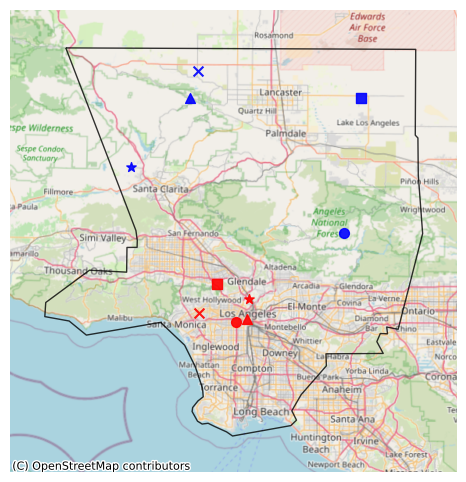

In [182]:
# create map of 
la_county_gdf_utm = la_county_gdf.to_crs(ds_nonan.crs)
df_bottom = hoods_bottom.to_crs(ds_nonan.crs)
df_top = hoods_top.to_crs(ds_nonan.crs)
la_county_3310 = la_county_gdf.to_crs(ds_nonan.crs)
# df_bottom = hoods_bottom.to_crs('epsg:3310')
# df_top = hoods_top.to_crs('epsg:3310')
# la_county_3310 = la_county_gdf.to_crs('epsg:3310')
fig, ax = plt.subplots(figsize=(6,6))
extent = neighborhoods.to_crs(ds_nonan.crs).total_bounds
# ax.set_xlim(extent[0], extent[2])
# ax.set_ylim(extent[1], extent[3])
# Expand by 10% margin
xpad = 0.1 * (extent[2] - extent[0])
ypad = 0.1 * (extent[3] - extent[1])
ax.set_xlim(extent[0] - xpad, extent[2] + xpad)
ax.set_ylim(extent[1] - ypad, extent[3] + ypad)
# ctx.add_basemap(ax=ax, source=ctx.providers.MapTiler.Basic, crs='epsg:3310')
for i in range(df_bottom.shape[0]):
    df_bottom.iloc[[i]].plot(ax=ax, marker=markers[i], alpha=0.9, 
                                markersize=50, color='blue')

for i in range(hoods_top.shape[0]):
    df_top.iloc[[i]].plot(ax=ax, marker=markers[i], alpha=0.9,
                             markersize=50, color='red')

# ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron, crs='epsg:3310', zoom=9)
ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=ds_nonan.crs, zoom=9)
# Overlay LA County boundary on top
la_county_3310.boundary.plot(
    ax=ax,
    color='black',
    linewidth=1.0,
    alpha=0.8,
    zorder=10  # ensures it's drawn above the basemap
)
plt.axis('off')
filename = 'ahf_top_bottom_5_map.png'
save_path = os.path.join(plot_dir, filename)
plt.savefig(save_path, dpi=1200)

### Heatmap by neighborhood

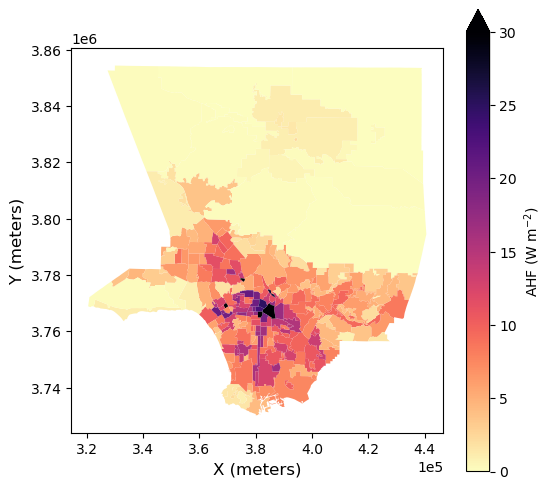

In [34]:
import matplotlib.ticker as mticker
# plot heatmap of neighborhood AHF
df_stats = df.describe()
df_stats_t = df_stats.T
neighborhoods = neighborhoods.to_crs(ds_nonan.crs)
ahf_hoods_gdf = neighborhoods.merge(df_stats_t, on = 'name')
drop_col_list = ['external_i', 'location', 'latitude', 'slug_1', 'sqmi',
       'display_na', 'set', 'slug', 'longitude', 'name_1', 'kind', 'type']
ahf_hoods_gdf.drop(columns=drop_col_list, inplace=True)
# Create figure and axes first
fig, ax = plt.subplots(figsize=(6, 6))
ahf_hoods_gdf.plot(column='mean', cmap='magma_r', legend=True,
                  vmin=0, vmax = 30, 
                  legend_kwds={
                     'label':'AHF (W m$^{-2}$)',
                     'extend':'max'
                  },
                  ax=ax)
# # Overlay LA County boundary on top
# la_county_3310.boundary.plot(
#     ax=ax,
#     color='black',
#     linewidth=1.0,
#     alpha=0.8,
#     zorder=10  # ensures it's drawn above the basemap
# )
# Set axis labels
ax.set_xlabel('X (meters)', fontsize=12)
ax.set_ylabel('Y (meters)', fontsize=12)
ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
filename = 'ahf_by_neighborhood_map.png'
save_path = os.path.join(plot_dir, filename)
plt.savefig(save_path, dpi=300, bbox_inches='tight')

# Default - Control

Assuming deltas have been pre-computed and saved using `deltas-analysis.py` script.

In [4]:
# import deltas data
deltas = {}
data_dir = '/home1/kojoseph/ah-la-paper/data/deltas-urban-wrf-v7'
nc_files = glob.glob(f"{data_dir}/*.nc")
for f in nc_files:
    filename = os.path.basename(f)
    delta_id = filename.split('.')[0]
    ds = xr.open_dataset(f)
    deltas[delta_id] = ds

# deltas (w/o urban mask)
deltas_all = {}
data_dir = '/home1/kojoseph/ah-la-paper/data/deltas-all-wrf-v7'
nc_files = glob.glob(f"{data_dir}/*.nc")
for f in nc_files:
    filename = os.path.basename(f)
    delta_id = filename.split('.')[0]
    ds = xr.open_dataset(f)
    deltas_all[delta_id] = ds

In [5]:
# define wrf crs
ds = deltas_all['ah_off-ah_default-08'] # sample delta ds
wrf_crs = ds['spatial_ref'].crs_wkt
print(wrf_crs)

PROJCS["unknown",GEOGCS["unknown",DATUM["unknown",SPHEROID["unknown",6370000,0]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",37.1646919250488],PARAMETER["central_meridian",-120.5],PARAMETER["standard_parallel_1",30],PARAMETER["standard_parallel_2",60],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [37]:
ds = deltas_all['ah_off-ah_default-08']

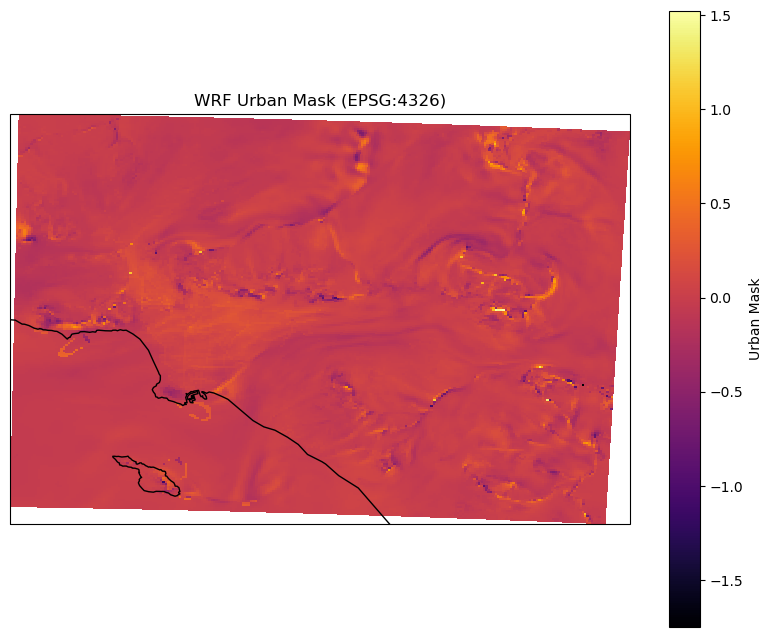

In [38]:
import cartopy.crs as ccrs
# EPSG:4326 is PlateCarree in Cartopy
crs = ccrs.PlateCarree()

da = ds['T2'].isel(Time=1).values
lat = ds['XLAT'].values
lon = ds['XLONG'].values

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': crs})
pcm = ax.pcolormesh(lon, lat, da, cmap='inferno', shading='auto', transform=crs)
ax.coastlines()
ax.set_title("WRF Urban Mask (EPSG:4326)")
plt.colorbar(pcm, ax=ax, label='Urban Mask')
plt.show()

## T2 (2 meter air temperature)

Summer: Max mean at hour 6 with value 0.408
Summer: Min mean at hour 17 with value 0.113
Winter: Max mean at hour 19 with value 0.452
Winter: Min mean at hour 13 with value 0.214


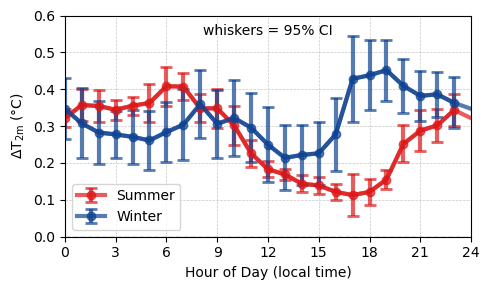

In [39]:
v = 'T2'
mean_dict = {}
ci_lower = {}
ci_upper = {}
months = [8, 12]
target = 'ah_default'
control = 'ah_off'

# --- Compute diurnal mean and 95% CI ---
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    mean = deltas[delta_id][v].mean(dim=['y', 'x'], skipna=True)
    mean_diurnal = mean.groupby('hour').mean('Time')
    std_diurnal = mean.groupby('hour').std('Time')
    n_sample = len(mean[mean['hour'] == 0])
    err_diurnal = 1.96 * (std_diurnal / (n_sample)**0.5)

    # Store mean and CI
    mean_dict[m] = mean_diurnal
    ci_lower[m] = mean_diurnal - err_diurnal
    ci_upper[m] = mean_diurnal + err_diurnal

    # Add hour=24 with value = hour=0
    for d in [mean_dict, ci_lower, ci_upper]:
        d[m] = xr.concat([d[m], d[m].isel(hour=0)], dim="hour")
        d[m]["hour"].values[-1] = 24

# --- Plotting ---
fig, ax = plt.subplots(figsize=(5, 3))
colors = {8: max_red, 12: yale_blue}
labels = {8: 'Summer', 12: 'Winter'}

for m in months:
    hrs_full = mean_dict[m]["hour"].values
    hrs_plot = hrs_full[:-1]  # exclude hour=24 for markers and CI

    # Plot with error bars
    ax.errorbar(
        hrs_plot,
        mean_dict[m].values[:-1],
        yerr=[
            mean_dict[m].values[:-1] - ci_lower[m].values[:-1],
            ci_upper[m].values[:-1] - mean_dict[m].values[:-1]
        ],
        fmt='o-', color=colors[m], label=labels[m],
        linewidth=3, alpha=0.7, capsize=4, capthick=2
    )

    # Add connecting line to hour=24 without marker or CI
    ax.plot(hrs_full, mean_dict[m].values, color=colors[m], linewidth=3, alpha=0.7)

    # Print max/min
    max_idx = np.argmax(mean_dict[m].values)
    max_hour = mean_dict[m]['hour'].values[max_idx]
    max_val = mean_dict[m].values[max_idx]
    min_idx = np.argmin(mean_dict[m].values)
    min_hour = mean_dict[m]['hour'].values[min_idx]
    min_val = mean_dict[m].values[min_idx]
    print(f"{labels[m]}: Max mean at hour {max_hour} with value {max_val:.3f}")
    print(f"{labels[m]}: Min mean at hour {min_hour} with value {min_val:.3f}")

# Axis & labels
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.xaxis.set_ticks(np.arange(0, 25, 3))
ax.grid(linewidth=0.5, alpha=0.7, linestyle='--')
ax.set_xlabel('Hour of Day (local time)')
ax.set_ylabel(del_ta_label)
ax.legend()
ax.set_xlim(0, 24)
ax.set_ylim(0, 0.6)
ax.annotate('whiskers = 95% CI', xy=(0.5, 0.9), xycoords='axes fraction', 
            fontsize=10, horizontalalignment='center', verticalalignment='bottom')

plt.tight_layout()
save_filepath = os.path.join(plot_dir, 'diurnal_del_t2.png')
plt.savefig(save_filepath, dpi=300, bbox_inches='tight')

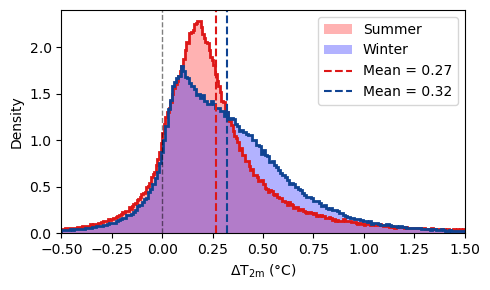

In [40]:
# Distribution of deltas
fig, ax = plt.subplots(figsize=(5,3))
xlim = (-0.5, 1.5)
# get data
delta_dict = {}
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    delta_dict[m] = deltas[delta_id][v]
delta_summer = delta_dict[8].values.flatten()
delta_summer = delta_summer[~np.isnan(delta_summer)]
delta_winter = delta_dict[12].values.flatten()
delta_winter = delta_winter[~np.isnan(delta_winter)]
# Summer: filled histogram with transparent fill, no edge
n_s, bins_s, patches_s = ax.hist(
    delta_summer, bins='auto', range=xlim, label='Summer',
    histtype='stepfilled', density=True,
    facecolor=(1, 0, 0, 0.3), edgecolor='none'
)
# Summer: edges with higher opacity
ax.hist(
    delta_summer, bins=bins_s, range=xlim,
    histtype='step', density=True,
    color=max_red, linewidth=2, alpha=1
)

# Winter: filled histogram with transparent fill, no edge
n_w, bins_w, patches_w = ax.hist(
    delta_winter, bins='auto', range=xlim, label='Winter',
    histtype='stepfilled', density=True,
    facecolor=(0, 0, 1, 0.3), edgecolor='none'
)
# Winter: edges with higher opacity
ax.hist(
    delta_winter, bins=bins_w, range=xlim,
    histtype='step', density=True,
    color=yale_blue, linewidth=2, alpha=1
)

# Plot mean as lines
mean_val_s = np.mean(delta_summer)
mean_val_w = np.mean(delta_winter)
plt.axvline(mean_val_s, color=max_red, linestyle='--', label=f'Mean = {mean_val_s:.2f}')
plt.axvline(mean_val_w, color=yale_blue, linestyle='--', label=f'Mean = {mean_val_w:.2f}')

# ax.grid(linewidth=0.5, alpha=0.3, linestyle='--')
ax.set_xlabel(del_ta_label)
ax.set_ylabel('Density')
ax.legend()
ax.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.set_title('')
ax.set_xlim(xlim)
# save plot
save_filename = 'hist_del_t2.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
plt.savefig(save_filepath, dpi=300, bbox_inches='tight')

In [41]:
# Statistical tests
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    delta = deltas[delta_id]
    delta_values = delta[v].values.flatten()
    delta_values = delta_values[~np.isnan(delta_values)]
    print(f'=== Statistical test for {v} for month {m} ===')
    
    # Paired t-test
    t_stat, p_value = stats.ttest_1samp(delta_values, popmean=0)
    if p_value < 1e-16:
        print(f"t-statistic: {t_stat:.2e}, p-value: < 1e-16")
    else:
        print(f"t-statistic: {t_stat:.2e}, p-value: {p_value:.2e}")
    if p_value < 0.001:
        print(">>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)")
    elif p_value < 0.01:
        print(">>> Result: Statistically significant at p < 0.01 (strong evidence against null hypothesis)")
    elif p_value < 0.05:
        print(">>> Result: Statistically significant at p < 0.05 (moderate evidence against null hypothesis)")
    else:
        print(">>> Result: Not statistically significant (p >= 0.05)")

    # Wilcoxon signed-rank test
    w_stat, p_value = stats.wilcoxon(delta_values)
    if p_value < 1e-16:
        print(f"Wilcoxon statistic: {w_stat:.2e}, p-value: < 1e-16")
    else:
        print(f"Wilcoxon statistic: {w_stat:.2e}, p-value: {p_value:.2e}")
    if p_value < 0.001:
        print(">>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)")
    elif p_value < 0.01:
        print(">>> Result: Statistically significant at p < 0.01 (strong evidence against null hypothesis)")
    elif p_value < 0.05:
        print(">>> Result: Statistically significant at p < 0.05 (moderate evidence against null hypothesis)")
    else:
        print(">>> Result: Not statistically significant (p >= 0.05)")

=== Statistical test for T2 for month 8 ===
t-statistic: 3.90e+02, p-value: < 1e-16
>>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)
Wilcoxon statistic: 6.42e+09, p-value: < 1e-16
>>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)
=== Statistical test for T2 for month 12 ===
t-statistic: 5.67e+02, p-value: < 1e-16
>>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)
Wilcoxon statistic: 3.78e+09, p-value: < 1e-16
>>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)


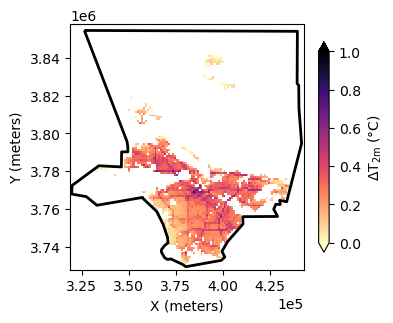

In [88]:
# Heatmap
v = 'T2'
ds = deltas['ah_off-ah_default-08'][v]
ds_mean = ds.mean(dim='Time')
ds_mean.rio.write_crs(wrf_crs, inplace=True)
ds_mean = ds_mean.drop_vars(['XLAT', 'XLONG'])
ds_mean_reproj = ds_mean.rio.reproject(la_county_gdf_utm.crs)
ds_mean_reproj = ds_mean_reproj.where(ds_mean_reproj < 1e30)
ds_mean_reproj.attrs = {}
ds_mean_reproj.encoding = {}

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
# Plot raster
ds_mean_reproj.plot(
    ax=ax,
    cmap='magma_r',
    vmin=0,                 # minimum color value
    vmax=1.0,               # maximum color value
    extend='both',          # show triangles on both ends of the colorbar
    add_labels=False,
    cbar_kwargs={
        'label': del_ta_label,
        'extend': 'both',    # ensures the colorbar itself shows extensions
        'shrink': 0.6
    }
)
# Overlay LA County boundary
la_county_gdf_utm.boundary.plot(ax=ax, color='black', linewidth=2)

ax.set_xlabel("X (meters)")
ax.set_ylabel("Y (meters)")
ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

# Save figure
save_filename = 'map_del_t2.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
plt.savefig(save_filepath, dpi=300, bbox_inches='tight')
plt.show()

## TC_URB (canopy air temperature)

Summer: Max mean at hour 8 with value 1.455
Summer: Min mean at hour 3 with value 0.790
Winter: Max mean at hour 18 with value 1.752
Winter: Min mean at hour 4 with value 1.198


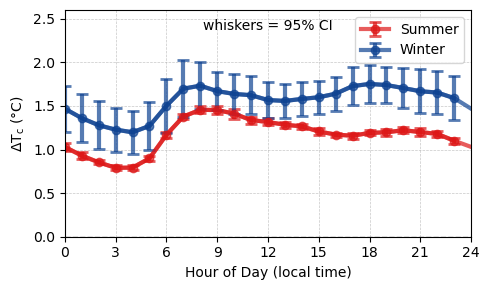

In [42]:
# Diurnal plot for delta(TC)
v = 'TC_URB'
mean_dict = {}
ci_lower = {}
ci_upper = {}
months = [8, 12]
target = 'ah_default'
control = 'ah_off'
# --- Compute diurnal mean and 95% CI ---
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    mean = deltas[delta_id][v].mean(dim=['y', 'x'], skipna=True)
    mean_diurnal = mean.groupby('hour').mean('Time')
    std_diurnal = mean.groupby('hour').std('Time')
    n_sample = len(mean[mean['hour'] == 0])
    err_diurnal = 1.96 * (std_diurnal / (n_sample)**0.5)

    # Store mean and CI
    mean_dict[m] = mean_diurnal
    ci_lower[m] = mean_diurnal - err_diurnal
    ci_upper[m] = mean_diurnal + err_diurnal

    # Add hour=24 with value = hour=0
    for d in [mean_dict, ci_lower, ci_upper]:
        d[m] = xr.concat([d[m], d[m].isel(hour=0)], dim="hour")
        d[m]["hour"].values[-1] = 24

# --- Plotting ---
fig, ax = plt.subplots(figsize=(5, 3))
colors = {8: max_red, 12: yale_blue}
labels = {8: 'Summer', 12: 'Winter'}

for m in months:
    hrs_full = mean_dict[m]["hour"].values
    hrs_plot = hrs_full[:-1]  # exclude hour=24 for markers and CI

    # Plot with error bars
    ax.errorbar(
        hrs_plot,
        mean_dict[m].values[:-1],
        yerr=[
            mean_dict[m].values[:-1] - ci_lower[m].values[:-1],
            ci_upper[m].values[:-1] - mean_dict[m].values[:-1]
        ],
        fmt='o-', color=colors[m], label=labels[m],
        linewidth=3, alpha=0.7, capsize=4, capthick=2
    )

    # Add connecting line to hour=24 without marker or CI
    ax.plot(hrs_full, mean_dict[m].values, color=colors[m], linewidth=3, alpha=0.7)

    # Print max/min
    max_idx = np.argmax(mean_dict[m].values)
    max_hour = mean_dict[m]['hour'].values[max_idx]
    max_val = mean_dict[m].values[max_idx]
    min_idx = np.argmin(mean_dict[m].values)
    min_hour = mean_dict[m]['hour'].values[min_idx]
    min_val = mean_dict[m].values[min_idx]
    print(f"{labels[m]}: Max mean at hour {max_hour} with value {max_val:.3f}")
    print(f"{labels[m]}: Min mean at hour {min_hour} with value {min_val:.3f}")

# Axis & labels
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.xaxis.set_ticks(np.arange(0, 25, 3))
ax.grid(linewidth=0.5, alpha=0.7, linestyle='--')
ax.set_xlabel('Hour of Day (local time)')
ax.set_ylabel(del_tc_label)
ax.legend()
ax.set_xlim(0, 24)
ax.set_ylim(0, 2.6)
ax.annotate('whiskers = 95% CI', xy=(0.5, 0.9), xycoords='axes fraction', 
            fontsize=10, horizontalalignment='center', verticalalignment='bottom')

plt.tight_layout()
save_filepath = os.path.join(plot_dir, 'diurnal_del_tc.png')
plt.savefig(save_filepath, dpi=300, bbox_inches='tight')

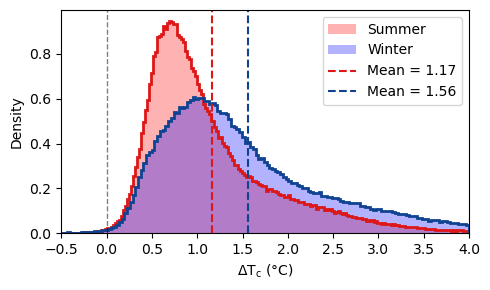

In [43]:
# Distribution of deltas
fig, ax = plt.subplots(figsize=(5,3))
xlim = (-0.5, 4.0)
# get data
delta_dict = {}
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    delta_dict[m] = deltas[delta_id][v]
delta_summer = delta_dict[8].values.flatten()
delta_summer = delta_summer[~np.isnan(delta_summer)]
delta_winter = delta_dict[12].values.flatten()
delta_winter = delta_winter[~np.isnan(delta_winter)]
# Summer: filled histogram with transparent fill, no edge
n_s, bins_s, patches_s = ax.hist(
    delta_summer, bins='auto', range=xlim, label='Summer',
    histtype='stepfilled', density=True,
    facecolor=(1, 0, 0, 0.3), edgecolor='none'
)
# Summer: edges with higher opacity
ax.hist(
    delta_summer, bins=bins_s, range=xlim,
    histtype='step', density=True,
    color=max_red, linewidth=2, alpha=1
)

# Winter: filled histogram with transparent fill, no edge
n_w, bins_w, patches_w = ax.hist(
    delta_winter, bins='auto', range=xlim, label='Winter',
    histtype='stepfilled', density=True,
    facecolor=(0, 0, 1, 0.3), edgecolor='none'
)
# Winter: edges with higher opacity
ax.hist(
    delta_winter, bins=bins_w, range=xlim,
    histtype='step', density=True,
    color=yale_blue, linewidth=2, alpha=1
)

# Plot mean as lines
mean_val_s = np.mean(delta_summer)
mean_val_w = np.mean(delta_winter)
plt.axvline(mean_val_s, color=max_red, linestyle='--', label=f'Mean = {mean_val_s:.2f}')
plt.axvline(mean_val_w, color=yale_blue, linestyle='--', label=f'Mean = {mean_val_w:.2f}')

# ax.grid(linewidth=0.5, alpha=0.3, linestyle='--')
ax.set_xlabel(del_tc_label)
ax.set_ylabel('Density')
ax.legend()
ax.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.set_title('')
ax.set_xlim(xlim)
# save plot
save_filename = 'hist_del_tc.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
plt.savefig(save_filepath, dpi=300, bbox_inches='tight')

In [197]:
# Statistical tests
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    delta = deltas[delta_id]
    delta_values = delta[v].values.flatten()
    delta_values = delta_values[~np.isnan(delta_values)]
    print(f'=== Statistical test for {v} for month {m} ===')
    
    # Paired t-test
    t_stat, p_value = stats.ttest_1samp(delta_values, popmean=0)
    if p_value < 1e-16:
        print(f"t-statistic: {t_stat:.2e}, p-value: < 1e-16")
    else:
        print(f"t-statistic: {t_stat:.2e}, p-value: {p_value:.2e}")
    if p_value < 0.001:
        print(">>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)")
    elif p_value < 0.01:
        print(">>> Result: Statistically significant at p < 0.01 (strong evidence against null hypothesis)")
    elif p_value < 0.05:
        print(">>> Result: Statistically significant at p < 0.05 (moderate evidence against null hypothesis)")
    else:
        print(">>> Result: Not statistically significant (p >= 0.05)")

    # Wilcoxon signed-rank test
    w_stat, p_value = stats.wilcoxon(delta_values)
    if p_value < 1e-16:
        print(f"Wilcoxon statistic: {w_stat:.2e}, p-value: < 1e-16")
    else:
        print(f"Wilcoxon statistic: {w_stat:.2e}, p-value: {p_value:.2e}")
    if p_value < 0.001:
        print(">>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)")
    elif p_value < 0.01:
        print(">>> Result: Statistically significant at p < 0.01 (strong evidence against null hypothesis)")
    elif p_value < 0.05:
        print(">>> Result: Statistically significant at p < 0.05 (moderate evidence against null hypothesis)")
    else:
        print(">>> Result: Not statistically significant (p >= 0.05)")

=== Statistical test for TC_URB for month 8 ===
t-statistic: 8.62e+02, p-value: < 1e-16
>>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)
Wilcoxon statistic: 1.12e+07, p-value: < 1e-16
>>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)
=== Statistical test for TC_URB for month 12 ===
t-statistic: 8.97e+02, p-value: < 1e-16
>>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)
Wilcoxon statistic: 6.65e+07, p-value: < 1e-16
>>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)


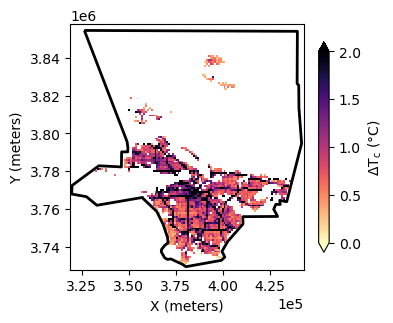

In [90]:
# Heatmap
v = 'TC_URB'
ds = deltas['ah_off-ah_default-08'][v]
ds_mean = ds.mean(dim='Time')
ds_mean.rio.write_crs(wrf_crs, inplace=True)
ds_mean = ds_mean.drop_vars(['XLAT', 'XLONG'])
ds_mean_reproj = ds_mean.rio.reproject(la_county_gdf_utm.crs)
ds_mean_reproj = ds_mean_reproj.where(ds_mean_reproj < 1e30)
ds_mean_reproj.attrs = {}
ds_mean_reproj.encoding = {}

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
# Plot raster
ds_mean_reproj.plot(
    ax=ax,
    cmap='magma_r',
    vmin=0,                 # minimum color value
    vmax=2.0,               # maximum color value
    extend='both',          # show triangles on both ends of the colorbar
    add_labels=False,
    cbar_kwargs={
        'label': del_tc_label,
        'extend': 'both',    # ensures the colorbar itself shows extensions
        'shrink': 0.6
    }
)
# Overlay LA County boundary
la_county_gdf_utm.boundary.plot(ax=ax, color='black', linewidth=2)

ax.set_xlabel("X (meters)")
ax.set_ylabel("Y (meters)")
ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

# Save figure
save_filename = 'map_del_tc.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
plt.savefig(save_filepath, dpi=300, bbox_inches='tight')
plt.show()

## WS (Wind Speed)

Summer: Max mean at hour 21 with value 0.085
Summer: Min mean at hour 10 with value -0.009
Winter: Max mean at hour 22 with value 0.138
Winter: Min mean at hour 9 with value -0.041


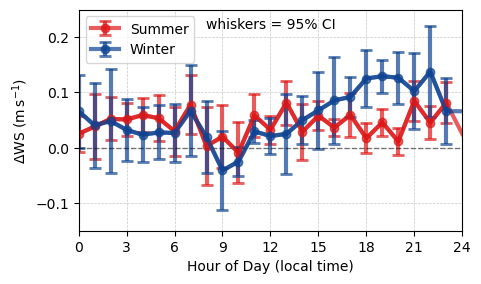

In [91]:
# Diurnal plot for delta(WS)
v = 'WS'
mean_dict = {}
ci_lower = {}
ci_upper = {}
months = [8, 12]
target = 'ah_default'
control = 'ah_off'
# --- Compute diurnal mean and 95% CI ---
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    mean = deltas[delta_id][v].mean(dim=['y', 'x'], skipna=True)
    mean_diurnal = mean.groupby('hour').mean('Time')
    std_diurnal = mean.groupby('hour').std('Time')
    n_sample = len(mean[mean['hour'] == 0])
    err_diurnal = 1.96 * (std_diurnal / (n_sample)**0.5)

    # Store mean and CI
    mean_dict[m] = mean_diurnal
    ci_lower[m] = mean_diurnal - err_diurnal
    ci_upper[m] = mean_diurnal + err_diurnal

    # Add hour=24 with value = hour=0
    for d in [mean_dict, ci_lower, ci_upper]:
        d[m] = xr.concat([d[m], d[m].isel(hour=0)], dim="hour")
        d[m]["hour"].values[-1] = 24

# --- Plotting ---
fig, ax = plt.subplots(figsize=(5, 3))
colors = {8: max_red, 12: yale_blue}
labels = {8: 'Summer', 12: 'Winter'}

for m in months:
    hrs_full = mean_dict[m]["hour"].values
    hrs_plot = hrs_full[:-1]  # exclude hour=24 for markers and CI

    # Plot with error bars
    ax.errorbar(
        hrs_plot,
        mean_dict[m].values[:-1],
        yerr=[
            mean_dict[m].values[:-1] - ci_lower[m].values[:-1],
            ci_upper[m].values[:-1] - mean_dict[m].values[:-1]
        ],
        fmt='o-', color=colors[m], label=labels[m],
        linewidth=3, alpha=0.7, capsize=4, capthick=2
    )

    # Add connecting line to hour=24 without marker or CI
    ax.plot(hrs_full, mean_dict[m].values, color=colors[m], linewidth=3, alpha=0.7)

    # Print max/min
    max_idx = np.argmax(mean_dict[m].values)
    max_hour = mean_dict[m]['hour'].values[max_idx]
    max_val = mean_dict[m].values[max_idx]
    min_idx = np.argmin(mean_dict[m].values)
    min_hour = mean_dict[m]['hour'].values[min_idx]
    min_val = mean_dict[m].values[min_idx]
    print(f"{labels[m]}: Max mean at hour {max_hour} with value {max_val:.3f}")
    print(f"{labels[m]}: Min mean at hour {min_hour} with value {min_val:.3f}")

# Axis & labels
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.xaxis.set_ticks(np.arange(0, 25, 3))
ax.grid(linewidth=0.5, alpha=0.7, linestyle='--')
ax.set_xlabel('Hour of Day (local time)')
ax.set_ylabel(del_ws_label)
ax.legend()
ax.set_xlim(0, 24)
ax.set_ylim(-0.15, 0.25)
ax.annotate('whiskers = 95% CI', xy=(0.5, 0.9), xycoords='axes fraction', 
            fontsize=10, horizontalalignment='center', verticalalignment='bottom')
plt.tight_layout()
save_filepath = os.path.join(plot_dir, 'diurnal_del_ws.png')
plt.savefig(save_filepath, dpi=300, bbox_inches='tight')

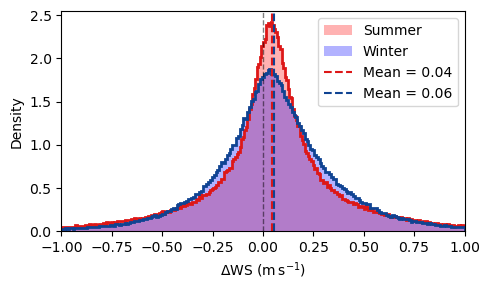

In [92]:
# Distribution of deltas
fig, ax = plt.subplots(figsize=(5,3))
xlim = (-1.0, 1.0)
# get data
delta_dict = {}
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    delta_dict[m] = deltas[delta_id][v]
delta_summer = delta_dict[8].values.flatten()
delta_summer = delta_summer[~np.isnan(delta_summer)]
delta_winter = delta_dict[12].values.flatten()
delta_winter = delta_winter[~np.isnan(delta_winter)]
# Summer: filled histogram with transparent fill, no edge
n_s, bins_s, patches_s = ax.hist(
    delta_summer, bins='auto', range=xlim, label='Summer',
    histtype='stepfilled', density=True,
    facecolor=(1, 0, 0, 0.3), edgecolor='none'
)
# Summer: edges with higher opacity
ax.hist(
    delta_summer, bins=bins_s, range=xlim,
    histtype='step', density=True,
    color=max_red, linewidth=2, alpha=1
)

# Winter: filled histogram with transparent fill, no edge
n_w, bins_w, patches_w = ax.hist(
    delta_winter, bins='auto', range=xlim, label='Winter',
    histtype='stepfilled', density=True,
    facecolor=(0, 0, 1, 0.3), edgecolor='none'
)
# Winter: edges with higher opacity
ax.hist(
    delta_winter, bins=bins_w, range=xlim,
    histtype='step', density=True,
    color=yale_blue, linewidth=2, alpha=1
)

# Plot mean as lines
mean_val_s = np.mean(delta_summer)
mean_val_w = np.mean(delta_winter)
plt.axvline(mean_val_s, color=max_red, linestyle='--', label=f'Mean = {mean_val_s:.2f}')
plt.axvline(mean_val_w, color=yale_blue, linestyle='--', label=f'Mean = {mean_val_w:.2f}')

# ax.grid(linewidth=0.5, alpha=0.3, linestyle='--')
ax.set_xlabel(del_ws_label)
ax.set_ylabel('Density')
ax.legend()
ax.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.set_title('')
ax.set_xlim(xlim)
# save plot
save_filename = 'hist_del_ws.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
plt.savefig(save_filepath, dpi=300, bbox_inches='tight')

In [93]:
# Statistical tests
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    delta = deltas[delta_id]
    delta_values = delta[v].values.flatten()
    delta_values = delta_values[~np.isnan(delta_values)]
    print(f'=== Statistical test for {v} for month {m} ===')
    
    # Paired t-test
    t_stat, p_value = stats.ttest_1samp(delta_values, popmean=0)
    if p_value < 1e-16:
        print(f"t-statistic: {t_stat:.2e}, p-value: < 1e-16")
    else:
        print(f"t-statistic: {t_stat:.2e}, p-value: {p_value:.2e}")
    if p_value < 0.001:
        print(">>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)")
    elif p_value < 0.01:
        print(">>> Result: Statistically significant at p < 0.01 (strong evidence against null hypothesis)")
    elif p_value < 0.05:
        print(">>> Result: Statistically significant at p < 0.05 (moderate evidence against null hypothesis)")
    else:
        print(">>> Result: Not statistically significant (p >= 0.05)")

    # Wilcoxon signed-rank test
    w_stat, p_value = stats.wilcoxon(delta_values)
    if p_value < 1e-16:
        print(f"Wilcoxon statistic: {w_stat:.2e}, p-value: < 1e-16")
    else:
        print(f"Wilcoxon statistic: {w_stat:.2e}, p-value: {p_value:.2e}")
    if p_value < 0.001:
        print(">>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)")
    elif p_value < 0.01:
        print(">>> Result: Statistically significant at p < 0.01 (strong evidence against null hypothesis)")
    elif p_value < 0.05:
        print(">>> Result: Statistically significant at p < 0.05 (moderate evidence against null hypothesis)")
    else:
        print(">>> Result: Not statistically significant (p >= 0.05)")

=== Statistical test for WS for month 8 ===
t-statistic: 7.01e+01, p-value: < 1e-16
>>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)
Wilcoxon statistic: 2.66e+10, p-value: < 1e-16
>>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)
=== Statistical test for WS for month 12 ===
t-statistic: 9.00e+01, p-value: < 1e-16
>>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)
Wilcoxon statistic: 2.64e+10, p-value: < 1e-16
>>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)


## PBL

Summer: Max mean at hour 10 with value 28.262
Summer: Min mean at hour 17 with value 8.436
Winter: Max mean at hour 18 with value 87.209
Winter: Min mean at hour 1 with value 5.655


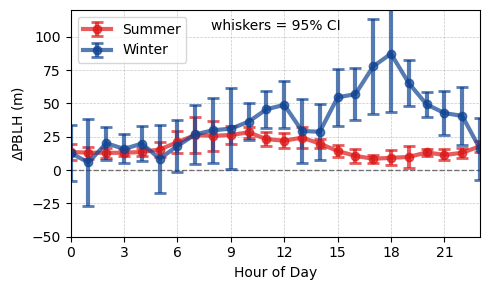

In [94]:
# Diurnal plot for delta(PBLH)
v = 'PBLH'
mean_dict = {}
ci_lower = {}
ci_upper = {}
months = [8, 12]
target = 'ah_default'
control = 'ah_off'
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    mean = deltas[delta_id][v].mean(dim=['y', 'x'], skipna=True)
    mean_diurnal = mean.groupby('hour').mean('Time')
    std_diurnal = mean.groupby('hour').std('Time')
    n_sample = len(mean[mean['hour']==0])
    err_diurnal = 1.96*(std_diurnal/(n_sample)**(1/2))
    mean_dict[m] = mean_diurnal
    ci_lower[m] = mean_diurnal - err_diurnal
    ci_upper[m] = mean_diurnal + err_diurnal
# initiate plot
fig, ax = plt.subplots(figsize=(5,3))
hrs = range(24)
# summer
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.errorbar(
    hrs,
    mean_dict[8].values,
    yerr=[mean_dict[8].values - ci_lower[8].values, ci_upper[8].values - mean_dict[8].values],
    fmt='o-', color=max_red, label='Summer', linewidth=3, alpha=0.7, capsize=4, capthick=2
)
# winter
ax.errorbar(
    hrs,
    mean_dict[12].values,
    yerr=[mean_dict[12].values - ci_lower[12].values, ci_upper[12].values - mean_dict[12].values],
    fmt='o-', color=yale_blue, label='Winter', linewidth=3, alpha=0.7, capsize=4, capthick=2
)

ax.xaxis.set_ticks(np.arange(0,24,3))
ax.grid(linewidth=0.5, alpha=0.7, linestyle='--')
ax.set_xlabel('Hour of Day')
ax.set_ylabel(del_pblh_label)
ax.legend()
ax.set_xlim(0, 23)
ax.set_ylim(-50, 120)
ax.annotate('whiskers = 95% CI', xy=(0.5, 0.9), xycoords='axes fraction', 
            fontsize=10, horizontalalignment='center', verticalalignment='bottom')

# save plot
save_filename = 'diurnal_del_pbl.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
plt.savefig(save_filepath, dpi=300, bbox_inches='tight')

# Print the max value and time of max value
# For summer (month 8)
max_idx_summer = np.argmax(mean_dict[8].values)
max_hour_summer = mean_dict[8]['hour'].values[max_idx_summer]
max_val_summer = mean_dict[8].values[max_idx_summer]
min_idx_summer = np.argmin(mean_dict[8].values)
min_hour_summer = mean_dict[8]['hour'].values[min_idx_summer]
min_val_summer = mean_dict[8].values[min_idx_summer]
print(f"Summer: Max mean at hour {max_hour_summer} with value {max_val_summer:.3f}")
print(f"Summer: Min mean at hour {min_hour_summer} with value {min_val_summer:.3f}")

# For winter (month 12)
max_idx_winter = np.argmax(mean_dict[12].values)
max_hour_winter = mean_dict[12]['hour'].values[max_idx_winter]
max_val_winter = mean_dict[12].values[max_idx_winter]
min_idx_winter = np.argmin(mean_dict[12].values)
min_hour_winter = mean_dict[12]['hour'].values[min_idx_winter]
min_val_winter = mean_dict[12].values[min_idx_winter]
print(f"Winter: Max mean at hour {max_hour_winter} with value {max_val_winter:.3f}")
print(f"Winter: Min mean at hour {min_hour_winter} with value {min_val_winter:.3f}")

Note: for histograms and statistical tests, coarsen PBL to 10km first. 

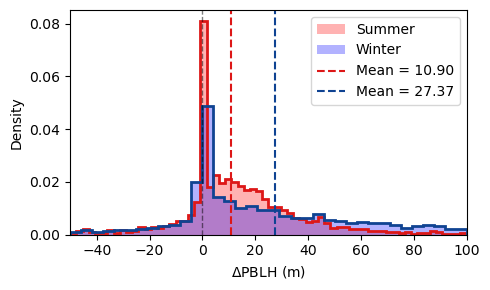

In [95]:
# Distribution of deltas
fig, ax = plt.subplots(figsize=(5,3))
xlim = (-50, 100)
# get data
delta_dict = {}
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    ds = deltas[delta_id][v]
    ds = ds.coarsen(y=10, x=10, boundary='trim').mean() # coarsen to 10km
    delta_dict[m] = ds
delta_summer = delta_dict[8].values.flatten()
delta_summer = delta_summer[~np.isnan(delta_summer)]
delta_winter = delta_dict[12].values.flatten()
delta_winter = delta_winter[~np.isnan(delta_winter)]

# Summer: filled histogram with transparent fill, no edge
n_s, bins_s, patches_s = ax.hist(
    delta_summer, bins='auto', range=xlim, label='Summer',
    histtype='stepfilled', density=True,
    facecolor=(1, 0, 0, 0.3), edgecolor='none'
)
# Summer: edges with higher opacity
ax.hist(
    delta_summer, bins=bins_s, range=xlim,
    histtype='step', density=True,
    color=max_red, linewidth=2, alpha=1
)

# Winter: filled histogram with transparent fill, no edge
n_w, bins_w, patches_w = ax.hist(
    delta_winter, bins='auto', range=xlim, label='Winter',
    histtype='stepfilled', density=True,
    facecolor=(0, 0, 1, 0.3), edgecolor='none'
)
# Winter: edges with higher opacity
ax.hist(
    delta_winter, bins=bins_w, range=xlim,
    histtype='step', density=True,
    color=yale_blue, linewidth=2, alpha=1
)

# Plot mean as lines
mean_val_s = np.mean(delta_summer)
mean_val_w = np.mean(delta_winter)
plt.axvline(mean_val_s, color=max_red, linestyle='--', label=f'Mean = {mean_val_s:.2f}')
plt.axvline(mean_val_w, color=yale_blue, linestyle='--', label=f'Mean = {mean_val_w:.2f}')

# ax.grid(linewidth=0.5, alpha=0.3, linestyle='--')
ax.set_xlabel(del_pblh_label)
ax.set_ylabel('Density')
ax.legend()
ax.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.set_title('')
ax.set_xlim(xlim)
# ax.set_yscale('log')  # <-- Add this line for log scale on y-axis
# save plot
save_filename = 'hist_del_pbl.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
plt.savefig(save_filepath, dpi=300, bbox_inches='tight')

In [96]:
# Statistical tests
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    delta = deltas[delta_id]
    delta = delta.coarsen(y=10, x=10, boundary='trim').mean() # coarsen to 10km
    delta_values = delta[v].values.flatten()
    delta_values = delta_values[~np.isnan(delta_values)]
    print(f'=== Statistical test for {v} for month {m} ===')
    
    # Paired t-test
    t_stat, p_value = stats.ttest_1samp(delta_values, popmean=0)
    if p_value < 1e-16:
        print(f"t-statistic: {t_stat:.2e}, p-value: < 1e-16")
    else:
        print(f"t-statistic: {t_stat:.2e}, p-value: {p_value:.2e}")
    if p_value < 0.001:
        print(">>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)")
    elif p_value < 0.01:
        print(">>> Result: Statistically significant at p < 0.01 (strong evidence against null hypothesis)")
    elif p_value < 0.05:
        print(">>> Result: Statistically significant at p < 0.05 (moderate evidence against null hypothesis)")
    else:
        print(">>> Result: Not statistically significant (p >= 0.05)")

    # Wilcoxon signed-rank test
    w_stat, p_value = stats.wilcoxon(delta_values)
    if p_value < 1e-16:
        print(f"Wilcoxon statistic: {w_stat:.2e}, p-value: < 1e-16")
    else:
        print(f"Wilcoxon statistic: {w_stat:.2e}, p-value: {p_value:.2e}")
    if p_value < 0.001:
        print(">>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)")
    elif p_value < 0.01:
        print(">>> Result: Statistically significant at p < 0.01 (strong evidence against null hypothesis)")
    elif p_value < 0.05:
        print(">>> Result: Statistically significant at p < 0.05 (moderate evidence against null hypothesis)")
    else:
        print(">>> Result: Not statistically significant (p >= 0.05)")

=== Statistical test for PBLH for month 8 ===
t-statistic: 1.21e+01, p-value: < 1e-16
>>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)
Wilcoxon statistic: 7.59e+06, p-value: < 1e-16
>>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)
=== Statistical test for PBLH for month 12 ===
t-statistic: 2.60e+01, p-value: < 1e-16
>>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)
Wilcoxon statistic: 7.88e+06, p-value: < 1e-16
>>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)


# EE-LOW (EE-LOW - Default)

## T2 (2 meter air temperature)

Summer: Max mean at hour 16 with value -0.004
Summer: Min mean at hour 6 with value -0.125
Winter: Max mean at hour 16 with value -0.049
Winter: Min mean at hour 19 with value -0.123


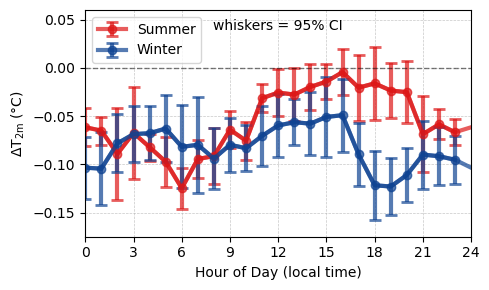

In [97]:
v = 'T2'
mean_dict = {}
ci_lower = {}
ci_upper = {}
months = [8, 12]
target = 'ah_elec_low'
control = 'ah_default'

# --- Compute diurnal mean and 95% CI ---
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    mean = deltas[delta_id][v].mean(dim=['y', 'x'], skipna=True)
    mean_diurnal = mean.groupby('hour').mean('Time')
    std_diurnal = mean.groupby('hour').std('Time')
    n_sample = len(mean[mean['hour'] == 0])
    err_diurnal = 1.96 * (std_diurnal / (n_sample)**0.5)

    # Store mean and CI
    mean_dict[m] = mean_diurnal
    ci_lower[m] = mean_diurnal - err_diurnal
    ci_upper[m] = mean_diurnal + err_diurnal

    # Add hour=24 with value = hour=0
    for d in [mean_dict, ci_lower, ci_upper]:
        d[m] = xr.concat([d[m], d[m].isel(hour=0)], dim="hour")
        d[m]["hour"].values[-1] = 24

# --- Plotting ---
fig, ax = plt.subplots(figsize=(5, 3))
colors = {8: max_red, 12: yale_blue}
labels = {8: 'Summer', 12: 'Winter'}

for m in months:
    hrs_full = mean_dict[m]["hour"].values
    hrs_plot = hrs_full[:-1]  # exclude hour=24 for markers and CI

    # Plot with error bars
    ax.errorbar(
        hrs_plot,
        mean_dict[m].values[:-1],
        yerr=[
            mean_dict[m].values[:-1] - ci_lower[m].values[:-1],
            ci_upper[m].values[:-1] - mean_dict[m].values[:-1]
        ],
        fmt='o-', color=colors[m], label=labels[m],
        linewidth=3, alpha=0.7, capsize=4, capthick=2
    )

    # Add connecting line to hour=24 without marker or CI
    ax.plot(hrs_full, mean_dict[m].values, color=colors[m], linewidth=3, alpha=0.7)

    # Print max/min
    max_idx = np.argmax(mean_dict[m].values)
    max_hour = mean_dict[m]['hour'].values[max_idx]
    max_val = mean_dict[m].values[max_idx]
    min_idx = np.argmin(mean_dict[m].values)
    min_hour = mean_dict[m]['hour'].values[min_idx]
    min_val = mean_dict[m].values[min_idx]
    print(f"{labels[m]}: Max mean at hour {max_hour} with value {max_val:.3f}")
    print(f"{labels[m]}: Min mean at hour {min_hour} with value {min_val:.3f}")

# Axis & labels
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.xaxis.set_ticks(np.arange(0, 25, 3))
ax.grid(linewidth=0.5, alpha=0.7, linestyle='--')
ax.set_xlabel('Hour of Day (local time)')
ax.set_ylabel(del_ta_label)
ax.legend()
ax.set_xlim(0, 24)
ax.set_ylim(-0.175, 0.06)
ax.annotate('whiskers = 95% CI', xy=(0.5, 0.9), xycoords='axes fraction', 
            fontsize=10, horizontalalignment='center', verticalalignment='bottom')
# save
save_filename = 'diurnal_del_t2_ee_low.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
plt.savefig(save_filepath, dpi=300, bbox_inches='tight')

## TC_URB (canopy air temperature)

Summer: Max mean at hour 4 with value -0.152
Summer: Min mean at hour 8 with value -0.313
Winter: Max mean at hour 4 with value -0.241
Winter: Min mean at hour 19 with value -0.377


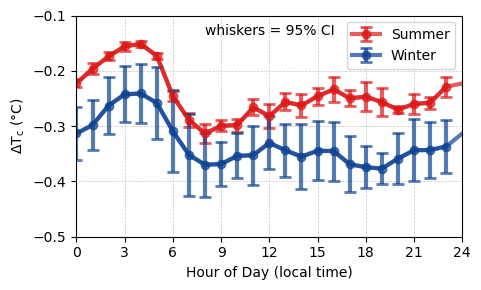

In [98]:
v = 'TC_URB'
mean_dict = {}
ci_lower = {}
ci_upper = {}
months = [8, 12]
target = 'ah_elec_low'
control = 'ah_default'

# --- Compute diurnal mean and 95% CI ---
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    mean = deltas[delta_id][v].mean(dim=['y', 'x'], skipna=True)
    mean_diurnal = mean.groupby('hour').mean('Time')
    std_diurnal = mean.groupby('hour').std('Time')
    n_sample = len(mean[mean['hour'] == 0])
    err_diurnal = 1.96 * (std_diurnal / (n_sample)**0.5)

    # Store mean and CI
    mean_dict[m] = mean_diurnal
    ci_lower[m] = mean_diurnal - err_diurnal
    ci_upper[m] = mean_diurnal + err_diurnal

    # Add hour=24 with value = hour=0
    for d in [mean_dict, ci_lower, ci_upper]:
        d[m] = xr.concat([d[m], d[m].isel(hour=0)], dim="hour")
        d[m]["hour"].values[-1] = 24

# --- Plotting ---
fig, ax = plt.subplots(figsize=(5, 3))
colors = {8: max_red, 12: yale_blue}
labels = {8: 'Summer', 12: 'Winter'}

for m in months:
    hrs_full = mean_dict[m]["hour"].values
    hrs_plot = hrs_full[:-1]  # exclude hour=24 for markers and CI

    # Plot with error bars
    ax.errorbar(
        hrs_plot,
        mean_dict[m].values[:-1],
        yerr=[
            mean_dict[m].values[:-1] - ci_lower[m].values[:-1],
            ci_upper[m].values[:-1] - mean_dict[m].values[:-1]
        ],
        fmt='o-', color=colors[m], label=labels[m],
        linewidth=3, alpha=0.7, capsize=4, capthick=2
    )

    # Add connecting line to hour=24 without marker or CI
    ax.plot(hrs_full, mean_dict[m].values, color=colors[m], linewidth=3, alpha=0.7)

    # Print max/min
    max_idx = np.argmax(mean_dict[m].values)
    max_hour = mean_dict[m]['hour'].values[max_idx]
    max_val = mean_dict[m].values[max_idx]
    min_idx = np.argmin(mean_dict[m].values)
    min_hour = mean_dict[m]['hour'].values[min_idx]
    min_val = mean_dict[m].values[min_idx]
    print(f"{labels[m]}: Max mean at hour {max_hour} with value {max_val:.3f}")
    print(f"{labels[m]}: Min mean at hour {min_hour} with value {min_val:.3f}")

# Axis & labels
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.xaxis.set_ticks(np.arange(0, 25, 3))
ax.grid(linewidth=0.5, alpha=0.7, linestyle='--')
ax.set_xlabel('Hour of Day (local time)')
ax.set_ylabel(del_tc_label)
ax.legend()
ax.set_xlim(0, 24)
ax.set_ylim(-0.5, -0.1)
ax.annotate('whiskers = 95% CI', xy=(0.5, 0.9), xycoords='axes fraction', 
            fontsize=10, horizontalalignment='center', verticalalignment='bottom')
# save
save_filename = 'diurnal_del_tc_ee_low.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
plt.savefig(save_filepath, dpi=300, bbox_inches='tight')

# EE-MID (EE-MID - Default)

## T2 (2 meter air temperature)

Summer: Max mean at hour 18 with value -0.050
Summer: Min mean at hour 6 with value -0.215
Winter: Max mean at hour 5 with value -0.102
Winter: Min mean at hour 19 with value -0.232


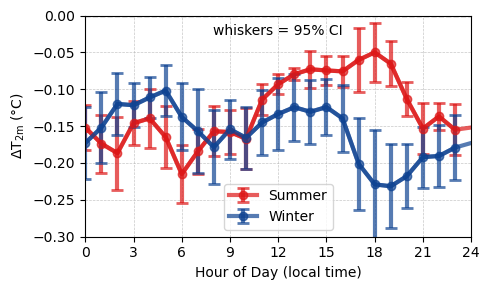

In [99]:
v = 'T2'
mean_dict = {}
ci_lower = {}
ci_upper = {}
months = [8, 12]
target = 'ah_elec_medium'
control = 'ah_default'

# --- Compute diurnal mean and 95% CI ---
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    mean = deltas[delta_id][v].mean(dim=['y', 'x'], skipna=True)
    mean_diurnal = mean.groupby('hour').mean('Time')
    std_diurnal = mean.groupby('hour').std('Time')
    n_sample = len(mean[mean['hour'] == 0])
    err_diurnal = 1.96 * (std_diurnal / (n_sample)**0.5)

    # Store mean and CI
    mean_dict[m] = mean_diurnal
    ci_lower[m] = mean_diurnal - err_diurnal
    ci_upper[m] = mean_diurnal + err_diurnal

    # Add hour=24 with value = hour=0
    for d in [mean_dict, ci_lower, ci_upper]:
        d[m] = xr.concat([d[m], d[m].isel(hour=0)], dim="hour")
        d[m]["hour"].values[-1] = 24

# --- Plotting ---
fig, ax = plt.subplots(figsize=(5, 3))
colors = {8: max_red, 12: yale_blue}
labels = {8: 'Summer', 12: 'Winter'}

for m in months:
    hrs_full = mean_dict[m]["hour"].values
    hrs_plot = hrs_full[:-1]  # exclude hour=24 for markers and CI

    # Plot with error bars
    ax.errorbar(
        hrs_plot,
        mean_dict[m].values[:-1],
        yerr=[
            mean_dict[m].values[:-1] - ci_lower[m].values[:-1],
            ci_upper[m].values[:-1] - mean_dict[m].values[:-1]
        ],
        fmt='o-', color=colors[m], label=labels[m],
        linewidth=3, alpha=0.7, capsize=4, capthick=2
    )

    # Add connecting line to hour=24 without marker or CI
    ax.plot(hrs_full, mean_dict[m].values, color=colors[m], linewidth=3, alpha=0.7)

    # Print max/min
    max_idx = np.argmax(mean_dict[m].values)
    max_hour = mean_dict[m]['hour'].values[max_idx]
    max_val = mean_dict[m].values[max_idx]
    min_idx = np.argmin(mean_dict[m].values)
    min_hour = mean_dict[m]['hour'].values[min_idx]
    min_val = mean_dict[m].values[min_idx]
    print(f"{labels[m]}: Max mean at hour {max_hour} with value {max_val:.3f}")
    print(f"{labels[m]}: Min mean at hour {min_hour} with value {min_val:.3f}")

# Axis & labels
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.xaxis.set_ticks(np.arange(0, 25, 3))
ax.grid(linewidth=0.5, alpha=0.7, linestyle='--')
ax.set_xlabel('Hour of Day (local time)')
ax.set_ylabel(del_ta_label)
ax.legend()
ax.set_xlim(0, 24)
ax.set_ylim(-0.3, 0.0)
ax.annotate('whiskers = 95% CI', xy=(0.5, 0.9), xycoords='axes fraction', 
            fontsize=10, horizontalalignment='center', verticalalignment='bottom')
# save
save_filename = 'diurnal_del_t2_ee_mid.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
plt.savefig(save_filepath, dpi=300, bbox_inches='tight')

## TC_URB (canopy air temperature)

Summer: Max mean at hour 3 with value -0.337
Summer: Min mean at hour 8 with value -0.721
Winter: Max mean at hour 4 with value -0.461
Winter: Min mean at hour 17 with value -0.804


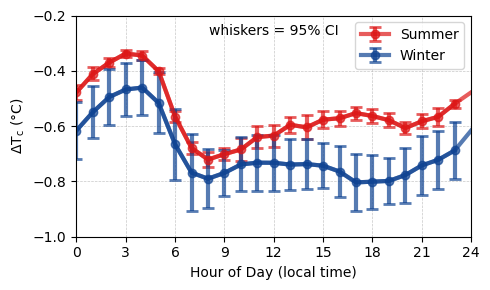

In [100]:
v = 'TC_URB'
mean_dict = {}
ci_lower = {}
ci_upper = {}
months = [8, 12]
target = 'ah_elec_medium'
control = 'ah_default'

# --- Compute diurnal mean and 95% CI ---
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    mean = deltas[delta_id][v].mean(dim=['y', 'x'], skipna=True)
    mean_diurnal = mean.groupby('hour').mean('Time')
    std_diurnal = mean.groupby('hour').std('Time')
    n_sample = len(mean[mean['hour'] == 0])
    err_diurnal = 1.96 * (std_diurnal / (n_sample)**0.5)

    # Store mean and CI
    mean_dict[m] = mean_diurnal
    ci_lower[m] = mean_diurnal - err_diurnal
    ci_upper[m] = mean_diurnal + err_diurnal

    # Add hour=24 with value = hour=0
    for d in [mean_dict, ci_lower, ci_upper]:
        d[m] = xr.concat([d[m], d[m].isel(hour=0)], dim="hour")
        d[m]["hour"].values[-1] = 24

# --- Plotting ---
fig, ax = plt.subplots(figsize=(5, 3))
colors = {8: max_red, 12: yale_blue}
labels = {8: 'Summer', 12: 'Winter'}

for m in months:
    hrs_full = mean_dict[m]["hour"].values
    hrs_plot = hrs_full[:-1]  # exclude hour=24 for markers and CI

    # Plot with error bars
    ax.errorbar(
        hrs_plot,
        mean_dict[m].values[:-1],
        yerr=[
            mean_dict[m].values[:-1] - ci_lower[m].values[:-1],
            ci_upper[m].values[:-1] - mean_dict[m].values[:-1]
        ],
        fmt='o-', color=colors[m], label=labels[m],
        linewidth=3, alpha=0.7, capsize=4, capthick=2
    )

    # Add connecting line to hour=24 without marker or CI
    ax.plot(hrs_full, mean_dict[m].values, color=colors[m], linewidth=3, alpha=0.7)

    # Print max/min
    max_idx = np.argmax(mean_dict[m].values)
    max_hour = mean_dict[m]['hour'].values[max_idx]
    max_val = mean_dict[m].values[max_idx]
    min_idx = np.argmin(mean_dict[m].values)
    min_hour = mean_dict[m]['hour'].values[min_idx]
    min_val = mean_dict[m].values[min_idx]
    print(f"{labels[m]}: Max mean at hour {max_hour} with value {max_val:.3f}")
    print(f"{labels[m]}: Min mean at hour {min_hour} with value {min_val:.3f}")

# Axis & labels
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.xaxis.set_ticks(np.arange(0, 25, 3))
ax.grid(linewidth=0.5, alpha=0.7, linestyle='--')
ax.set_xlabel('Hour of Day (local time)')
ax.set_ylabel(del_tc_label)
ax.legend()
ax.set_xlim(0, 24)
ax.set_ylim(-1.0, -0.2)
ax.annotate('whiskers = 95% CI', xy=(0.5, 0.9), xycoords='axes fraction', 
            fontsize=10, horizontalalignment='center', verticalalignment='bottom')
# save
save_filename = 'diurnal_del_tc_ee_mid.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
plt.savefig(save_filepath, dpi=300, bbox_inches='tight')

# EE-HI (EE-HI - Default)

## T2 (2 meter air temperature)

Summer: Max mean at hour 17 with value -0.061
Summer: Min mean at hour 6 with value -0.291
Winter: Max mean at hour 13 with value -0.115
Winter: Min mean at hour 19 with value -0.246


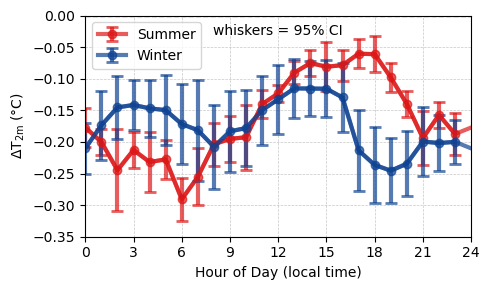

In [101]:
v = 'T2'
mean_dict = {}
ci_lower = {}
ci_upper = {}
months = [8, 12]
target = 'ah_elec_high'
control = 'ah_default'

# --- Compute diurnal mean and 95% CI ---
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    mean = deltas[delta_id][v].mean(dim=['y', 'x'], skipna=True)
    mean_diurnal = mean.groupby('hour').mean('Time')
    std_diurnal = mean.groupby('hour').std('Time')
    n_sample = len(mean[mean['hour'] == 0])
    err_diurnal = 1.96 * (std_diurnal / (n_sample)**0.5)

    # Store mean and CI
    mean_dict[m] = mean_diurnal
    ci_lower[m] = mean_diurnal - err_diurnal
    ci_upper[m] = mean_diurnal + err_diurnal

    # Add hour=24 with value = hour=0
    for d in [mean_dict, ci_lower, ci_upper]:
        d[m] = xr.concat([d[m], d[m].isel(hour=0)], dim="hour")
        d[m]["hour"].values[-1] = 24

# --- Plotting ---
fig, ax = plt.subplots(figsize=(5, 3))
colors = {8: max_red, 12: yale_blue}
labels = {8: 'Summer', 12: 'Winter'}

for m in months:
    hrs_full = mean_dict[m]["hour"].values
    hrs_plot = hrs_full[:-1]  # exclude hour=24 for markers and CI

    # Plot with error bars
    ax.errorbar(
        hrs_plot,
        mean_dict[m].values[:-1],
        yerr=[
            mean_dict[m].values[:-1] - ci_lower[m].values[:-1],
            ci_upper[m].values[:-1] - mean_dict[m].values[:-1]
        ],
        fmt='o-', color=colors[m], label=labels[m],
        linewidth=3, alpha=0.7, capsize=4, capthick=2
    )

    # Add connecting line to hour=24 without marker or CI
    ax.plot(hrs_full, mean_dict[m].values, color=colors[m], linewidth=3, alpha=0.7)

    # Print max/min
    max_idx = np.argmax(mean_dict[m].values)
    max_hour = mean_dict[m]['hour'].values[max_idx]
    max_val = mean_dict[m].values[max_idx]
    min_idx = np.argmin(mean_dict[m].values)
    min_hour = mean_dict[m]['hour'].values[min_idx]
    min_val = mean_dict[m].values[min_idx]
    print(f"{labels[m]}: Max mean at hour {max_hour} with value {max_val:.3f}")
    print(f"{labels[m]}: Min mean at hour {min_hour} with value {min_val:.3f}")

# Axis & labels
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.xaxis.set_ticks(np.arange(0, 25, 3))
ax.grid(linewidth=0.5, alpha=0.7, linestyle='--')
ax.set_xlabel('Hour of Day (local time)')
ax.set_ylabel(del_ta_label)
ax.legend()
ax.set_xlim(0, 24)
ax.set_ylim(-0.35, 0.0)
ax.annotate('whiskers = 95% CI', xy=(0.5, 0.9), xycoords='axes fraction', 
            fontsize=10, horizontalalignment='center', verticalalignment='bottom')
# save
save_filename = 'diurnal_del_t2_ee_hi.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
plt.savefig(save_filepath, dpi=300, bbox_inches='tight')

## TC_URB (canopy air temperature)

Summer: Max mean at hour 3 with value -0.401
Summer: Min mean at hour 8 with value -0.847
Winter: Max mean at hour 4 with value -0.569
Winter: Min mean at hour 8 with value -0.933


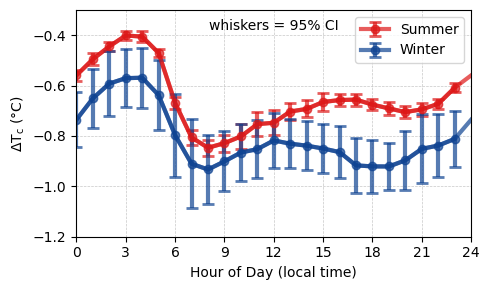

In [102]:
v = 'TC_URB'
mean_dict = {}
ci_lower = {}
ci_upper = {}
months = [8, 12]
target = 'ah_elec_high'
control = 'ah_default'

# --- Compute diurnal mean and 95% CI ---
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    mean = deltas[delta_id][v].mean(dim=['y', 'x'], skipna=True)
    mean_diurnal = mean.groupby('hour').mean('Time')
    std_diurnal = mean.groupby('hour').std('Time')
    n_sample = len(mean[mean['hour'] == 0])
    err_diurnal = 1.96 * (std_diurnal / (n_sample)**0.5)

    # Store mean and CI
    mean_dict[m] = mean_diurnal
    ci_lower[m] = mean_diurnal - err_diurnal
    ci_upper[m] = mean_diurnal + err_diurnal

    # Add hour=24 with value = hour=0
    for d in [mean_dict, ci_lower, ci_upper]:
        d[m] = xr.concat([d[m], d[m].isel(hour=0)], dim="hour")
        d[m]["hour"].values[-1] = 24

# --- Plotting ---
fig, ax = plt.subplots(figsize=(5, 3))
colors = {8: max_red, 12: yale_blue}
labels = {8: 'Summer', 12: 'Winter'}

for m in months:
    hrs_full = mean_dict[m]["hour"].values
    hrs_plot = hrs_full[:-1]  # exclude hour=24 for markers and CI

    # Plot with error bars
    ax.errorbar(
        hrs_plot,
        mean_dict[m].values[:-1],
        yerr=[
            mean_dict[m].values[:-1] - ci_lower[m].values[:-1],
            ci_upper[m].values[:-1] - mean_dict[m].values[:-1]
        ],
        fmt='o-', color=colors[m], label=labels[m],
        linewidth=3, alpha=0.7, capsize=4, capthick=2
    )

    # Add connecting line to hour=24 without marker or CI
    ax.plot(hrs_full, mean_dict[m].values, color=colors[m], linewidth=3, alpha=0.7)

    # Print max/min
    max_idx = np.argmax(mean_dict[m].values)
    max_hour = mean_dict[m]['hour'].values[max_idx]
    max_val = mean_dict[m].values[max_idx]
    min_idx = np.argmin(mean_dict[m].values)
    min_hour = mean_dict[m]['hour'].values[min_idx]
    min_val = mean_dict[m].values[min_idx]
    print(f"{labels[m]}: Max mean at hour {max_hour} with value {max_val:.3f}")
    print(f"{labels[m]}: Min mean at hour {min_hour} with value {min_val:.3f}")

# Axis & labels
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.xaxis.set_ticks(np.arange(0, 25, 3))
ax.grid(linewidth=0.5, alpha=0.7, linestyle='--')
ax.set_xlabel('Hour of Day (local time)')
ax.set_ylabel(del_tc_label)
ax.legend()
ax.set_xlim(0, 24)
ax.set_ylim(-1.2, -0.3)
ax.annotate('whiskers = 95% CI', xy=(0.5, 0.9), xycoords='axes fraction', 
            fontsize=10, horizontalalignment='center', verticalalignment='bottom')
# save
save_filename = 'diurnal_del_tc_ee_hi.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
plt.savefig(save_filepath, dpi=300, bbox_inches='tight')

# EE combined (summer only)

Plot into single combined line plot

## T2

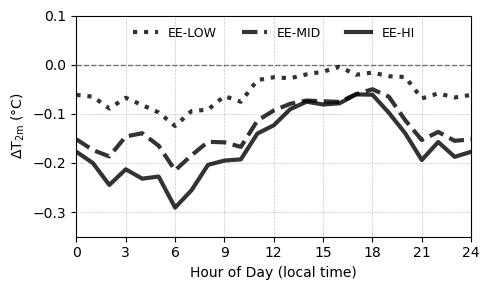

In [103]:
v = 'T2'
mean_dict = {}
ci_lower = {}
ci_upper = {}

month = 8  # summer only
targets = ['ah_elec_low', 'ah_elec_medium', 'ah_elec_high']
control = 'ah_default'

labels = {'ah_elec_low': 'EE-LOW', 'ah_elec_medium': 'EE-MID', 'ah_elec_high': 'EE-HI'}
# 🔁 switched order of line styles
linestyles = {
    'ah_elec_low': ':',
    'ah_elec_medium': '--',
    'ah_elec_high': '-'
}
color = 'black'  # summer color

# --- Compute diurnal mean and 95% CI ---
for target in targets:
    delta_id = f'{control}-{target}-{month:02d}'
    mean = deltas[delta_id][v].mean(dim=['y', 'x'], skipna=True)
    mean_diurnal = mean.groupby('hour').mean('Time')
    std_diurnal = mean.groupby('hour').std('Time')
    n_sample = len(mean[mean['hour'] == 0])
    err_diurnal = 1.96 * (std_diurnal / (n_sample)**0.5)

    # Store mean and CI
    mean_dict[target] = mean_diurnal
    ci_lower[target] = mean_diurnal - err_diurnal
    ci_upper[target] = mean_diurnal + err_diurnal

    # Add hour=24 safely (copy hour=0)
    for d in [mean_dict, ci_lower, ci_upper]:
        hour0 = d[target].isel(hour=0).copy()
        hour0 = hour0.assign_coords(hour=24)
        d[target] = xr.concat([d[target], hour0], dim="hour")

# --- Plotting ---
fig, ax = plt.subplots(figsize=(5, 3))

for target in targets:
    hrs = mean_dict[target]['hour'].values
    vals = mean_dict[target].values

    ax.plot(
        hrs,
        vals,
        color=color,
        linestyle=linestyles[target],
        linewidth=3,
        alpha=0.8,
        label=labels[target]
    )

# --- Axis & labels ---
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.xaxis.set_ticks(np.arange(0, 25, 3))
ax.grid(linewidth=0.5, alpha=0.7, linestyle='--')
ax.set_xlabel('Hour of Day (local time)')
ax.set_ylabel(del_ta_label)
ax.legend(fontsize=9, ncol=len(targets), loc='upper center', frameon=False)
ax.set_xlim(0, 24)
ax.set_ylim(-0.35, 0.1)
# save
save_filename = 'diurnal_del_t2_ee_all.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
plt.savefig(save_filepath, dpi=300, bbox_inches='tight')

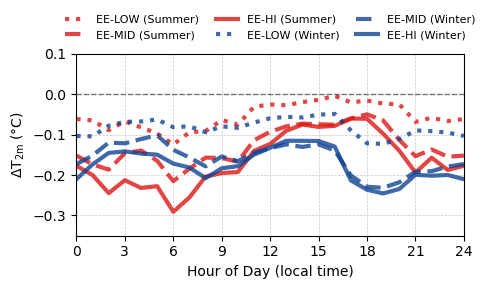

In [104]:
v = 'T2'
mean_dict = {}
ci_lower = {}
ci_upper = {}

targets = ['ah_elec_low', 'ah_elec_medium', 'ah_elec_high']
control = 'ah_default'
months = [8, 12]  # summer and winter

labels = {'ah_elec_low': 'EE-LOW', 'ah_elec_medium': 'EE-MID', 'ah_elec_high': 'EE-HI'}
linestyles = {
    'ah_elec_high': '-',      # switched order (solid = high)
    'ah_elec_medium': '--',
    'ah_elec_low': ':'
}
colors = {8: max_red, 12: yale_blue}  # assign color by season
season_names = {8: 'Summer', 12: 'Winter'}

# --- Compute diurnal mean and 95% CI ---
for month in months:
    for target in targets:
        delta_id = f'{control}-{target}-{month:02d}'
        mean = deltas[delta_id][v].mean(dim=['y', 'x'], skipna=True)
        mean_diurnal = mean.groupby('hour').mean('Time')
        std_diurnal = mean.groupby('hour').std('Time')
        n_sample = len(mean[mean['hour'] == 0])
        err_diurnal = 1.96 * (std_diurnal / (n_sample)**0.5)

        # Store mean and CI
        mean_dict[(month, target)] = mean_diurnal
        ci_lower[(month, target)] = mean_diurnal - err_diurnal
        ci_upper[(month, target)] = mean_diurnal + err_diurnal

        # Add hour=24 safely (copy hour=0)
        for d in [mean_dict, ci_lower, ci_upper]:
            hour0 = d[(month, target)].isel(hour=0).copy()
            hour0 = hour0.assign_coords(hour=24)
            d[(month, target)] = xr.concat([d[(month, target)], hour0], dim="hour")

# --- Plotting ---
fig, ax = plt.subplots(figsize=(5, 3))

for month in months:
    for target in targets:
        hrs = mean_dict[(month, target)]['hour'].values
        vals = mean_dict[(month, target)].values
        ax.plot(
            hrs,
            vals,
            color=colors[month],
            linestyle=linestyles[target],
            linewidth=3,
            alpha=0.8,
            label=f"{labels[target]} ({season_names[month]})"
        )

# --- Axis & labels ---
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.xaxis.set_ticks(np.arange(0, 25, 3))
ax.grid(linewidth=0.5, alpha=0.7, linestyle='--')
ax.set_xlabel('Hour of Day (local time)')
ax.set_ylabel(del_ta_label)
ax.legend(fontsize=8, ncol=3, loc='lower center', frameon=False, 
          bbox_to_anchor=(0.5, 1.02), columnspacing=1.5, handlelength=2)
ax.set_xlim(0, 24)
ax.set_ylim(-0.35, 0.1)
# save
save_filename = 'diurnal_del_t2_ee_all_winter_included.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
plt.savefig(save_filepath, dpi=300, bbox_inches='tight')

## TC

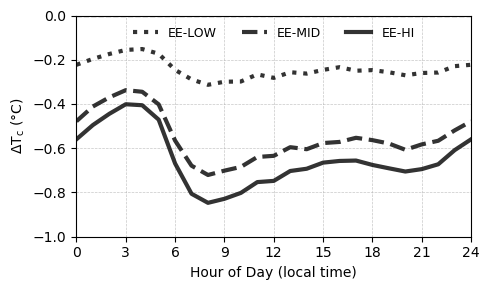

In [105]:
v = 'TC_URB'
mean_dict = {}
ci_lower = {}
ci_upper = {}

month = 8  # summer only
targets = ['ah_elec_low', 'ah_elec_medium', 'ah_elec_high']
control = 'ah_default'

labels = {'ah_elec_low': 'EE-LOW', 'ah_elec_medium': 'EE-MID', 'ah_elec_high': 'EE-HI'}
# 🔁 switched order of line styles
linestyles = {
    'ah_elec_low': ':',
    'ah_elec_medium': '--',
    'ah_elec_high': '-'
}
color = 'black'  # summer color

# --- Compute diurnal mean and 95% CI ---
for target in targets:
    delta_id = f'{control}-{target}-{month:02d}'
    mean = deltas[delta_id][v].mean(dim=['y', 'x'], skipna=True)
    mean_diurnal = mean.groupby('hour').mean('Time')
    std_diurnal = mean.groupby('hour').std('Time')
    n_sample = len(mean[mean['hour'] == 0])
    err_diurnal = 1.96 * (std_diurnal / (n_sample)**0.5)

    # Store mean and CI
    mean_dict[target] = mean_diurnal
    ci_lower[target] = mean_diurnal - err_diurnal
    ci_upper[target] = mean_diurnal + err_diurnal

    # Add hour=24 safely (copy hour=0)
    for d in [mean_dict, ci_lower, ci_upper]:
        hour0 = d[target].isel(hour=0).copy()
        hour0 = hour0.assign_coords(hour=24)
        d[target] = xr.concat([d[target], hour0], dim="hour")

# --- Plotting ---
fig, ax = plt.subplots(figsize=(5, 3))

for target in targets:
    hrs = mean_dict[target]['hour'].values
    vals = mean_dict[target].values

    ax.plot(
        hrs,
        vals,
        color=color,
        linestyle=linestyles[target],
        linewidth=3,
        alpha=0.8,
        label=labels[target]
    )

# --- Axis & labels ---
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.xaxis.set_ticks(np.arange(0, 25, 3))
ax.grid(linewidth=0.5, alpha=0.7, linestyle='--')
ax.set_xlabel('Hour of Day (local time)')
ax.set_ylabel(del_tc_label)
ax.legend(fontsize=9, ncol=len(targets), loc='upper center', frameon=False)
ax.set_xlim(0, 24)
ax.set_ylim(-1.0, 0.0)
# save
save_filename = 'diurnal_del_tc_ee_all.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
plt.savefig(save_filepath, dpi=300, bbox_inches='tight')


# Air Temp Sensitivities

## T2 using only default simulation (doesn't work)

In [8]:
v = 'T2'
m=8
target = 'ah_default'
control = 'ah_off'
delta_id = f'{control}-{target}-{m:02d}'
# get spatially averaged time series of air temp and AHF
T = deltas[delta_id][v].mean(dim=['y', 'x'], skipna=True) 
AHF = deltas[delta_id]['AHFLUX'].mean(dim=['y', 'x'], skipna=True) 

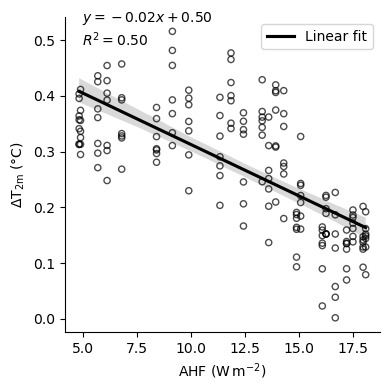

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress
import pandas as pd
import os

# Convert DataArrays to flat pandas DataFrame
df = pd.DataFrame({
    'AHF': AHF.values.flatten(),
    'T': T.values.flatten()
}).dropna()

# Regression
x = df['AHF']
y = df['T']
slope, intercept, r_value, p_value, std_err = linregress(x, y)
line_eq = f"$y = {slope:.2f}x + {intercept:.2f}$\n$R^2 = {r_value**2:.2f}$"

# Create lmplot
g = sns.lmplot(
    data=df,
    x='AHF', y='T',
    height=4, aspect=1.0,
    scatter_kws={
        'facecolors': 'none',  # hollow circles
        'edgecolor': 'black',
        'alpha': 0.7,
        's': 20
    },
    line_kws={'color': 'black', 'label': 'Linear fit'}
)

# Axis labels
g.set_axis_labels(ahf_label, del_ta_label)

# Access the underlying Axes
ax = g.ax

# Annotate regression equation
x_pos = x.min() + 0.01*(x.max() - x.min())
y_pos = y.max() - 0.05*(y.max() - y.min())
ax.text(x_pos, y_pos, line_eq, fontsize=10, color='black')

# Show legend
ax.legend(loc='upper right')

# Save figure
save_filename = 'scatter_T_vs_AHF.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
# plt.savefig(save_filepath, dpi=300)
plt.show()


This trend is explained by not controlling for background meteorology.

## T2 using all simulations

### (a) Time resolved (hourly) sensitivity

12 25 25


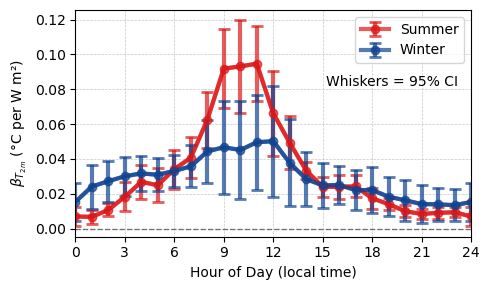

In [106]:
import pandas as pd
import numpy as np
from scipy.stats import linregress, t
import matplotlib.pyplot as plt

v = 'T2'
months = [8, 12]  # summer, winter
control = 'ah_off'
target = 'ah_default'
targets = ['ah_default', 'ah_elec_low', 'ah_elec_medium', 'ah_elec_high']

# Define colors for summer/winter (matching your style)
# summer_color = '#D73027'  # similar to max_red
# winter_color = '#4575B4'  # similar to yale_blue
colors = {8: max_red, 12: yale_blue}
labels = {8: 'Summer', 12: 'Winter'}

# Store hourly beta and CI
beta_dict = {}
ci_dict = {}

for m in months:
    data = []
    for target in targets:
        delta_id = f'{control}-{target}-{m:02d}'
        ds = deltas[delta_id]

        # Spatial mean
        T = ds[v].mean(dim=['y','x'], skipna=True)
        AHF = ds['AHFLUX'].mean(dim=['y','x'], skipna=True)

        df = pd.DataFrame({
            'time': pd.to_datetime(T['Time'].values),
            'dT2': T.values,
            'dAHF': AHF.values,
            'target': target
        })
        df['hour'] = df['time'].dt.hour
        df['date'] = df['time'].dt.date
        data.append(df)

    df_all = pd.concat(data, ignore_index=True)

    # Hourly regression
    hourly_sensitivity = []
    for h in range(24):
        sub = df_all[df_all['hour'] == h]
        daily_means = sub.groupby(['target','date']).mean(numeric_only=True).reset_index()
        n_points = len(daily_means)
        if n_points >= 3 and daily_means['dAHF'].nunique() >= 2:
            slope, intercept, r, p, stderr = linregress(daily_means['dAHF'], daily_means['dT2'])
            dfree = n_points - 2
            tval = t.ppf(0.975, dfree)
            ci95 = tval * stderr
            hourly_sensitivity.append({'hour': h, 'beta': slope, 'ci95': ci95})
        else:
            hourly_sensitivity.append({'hour': h, 'beta': np.nan, 'ci95': np.nan})

    df_beta = pd.DataFrame(hourly_sensitivity)
    # wrap around hour 24
    df_beta = pd.concat([df_beta, df_beta.iloc[[0]].assign(hour=24)], ignore_index=True)

    beta_dict[m] = df_beta['beta']
    ci_dict[m] = df_beta['ci95']

# --- Plot ---
fig, ax = plt.subplots(figsize=(5,3))
print(m, len(beta_dict[m]), len(ci_dict[m]))


for m in months:
    n = len(beta_dict[m])
    df_beta = pd.DataFrame({
        'hour': np.arange(n+1),   # now length 26
        'beta': list(beta_dict[m]) + [beta_dict[m][0]],
        'ci95': list(ci_dict[m]) + [ci_dict[m][0]]
    })
    # Plot line + markers with error bars (whiskers)
    ax.errorbar(df_beta['hour'][:-1], df_beta['beta'][:-1],
                yerr=df_beta['ci95'][:-1],
                fmt='o-', color=colors[m], label=labels[m],
                linewidth=3, alpha=0.7, capsize=4, capthick=2)

    # Add connecting line to hour=24 without marker/whisker
    ax.plot(df_beta['hour'], df_beta['beta'], color=colors[m], linewidth=3, alpha=0.7)

# Axis styling
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlim(0, 24)
ax.set_xticks(np.arange(0, 25, 3))
ax.set_xlabel('Hour of Day (local time)')
ax.set_ylabel(f'$\\beta_{{T_{{2m}}}}$ ({degree_sign}C per W m²)')
ax.grid(linewidth=0.5, alpha=0.7, linestyle='--')
ax.legend()
ax.annotate('Whiskers = 95% CI', xy=(0.8, 0.65), xycoords='axes fraction',
            fontsize=10, ha='center', va='bottom')

# Save figure
save_filename = 'diurnal_t2_sensitivity_urban.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
plt.savefig(save_filepath, dpi=300, bbox_inches='tight')
plt.show()

### (b) Time-average (daily) sensitivity

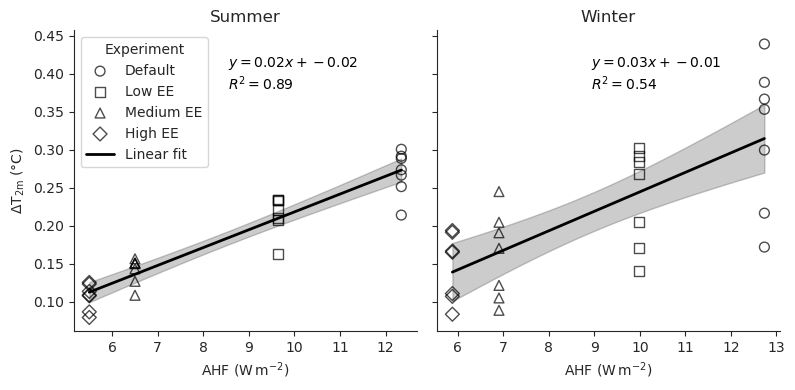

In [107]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import statsmodels.api as sm

v = 'T2'
control = 'ah_off'
targets = ['ah_default', 'ah_elec_low', 'ah_elec_medium', 'ah_elec_high']
months = [8, 12]  # summer and winter
legend_labels = {
    'ah_default': 'Default',
    'ah_elec_low': 'Low EE',
    'ah_elec_medium': 'Medium EE',
    'ah_elec_high': 'High EE'
}
markers = ['o', 's', '^', 'D']

sns.set_style("ticks")
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

for ax, month in zip(axes, months):
    data = []
    for target in targets:
        delta_id = f'{control}-{target}-{month:02d}'
        ds = deltas[delta_id]

        T = ds[v].mean(dim=['y', 'x'], skipna=True)
        AHF = ds['AHFLUX'].mean(dim=['y', 'x'], skipna=True)

        df = pd.DataFrame({
            'time': pd.to_datetime(T['Time'].values),
            'dT2': T.values,
            'dAHF': AHF.values,
            'target': target
        }).set_index('time')

        df_daily = df.resample('1D').mean(numeric_only=True).dropna()
        df_daily['target'] = target
        data.append(df_daily.reset_index())

    df_all = pd.concat(data, ignore_index=True)

    # --- Regression with statsmodels for CI ---
    X = df_all['dAHF']
    y = df_all['dT2']
    X_sm = sm.add_constant(X)  # add intercept
    model = sm.OLS(y, X_sm).fit()
    predictions = model.get_prediction(X_sm)
    pred_mean = predictions.predicted_mean
    pred_ci = predictions.conf_int(alpha=0.05)  # 95% CI

    # Scatter points
    for i, target in enumerate(targets):
        df_sub = df_all[df_all['target'] == target]
        ax.scatter(
            df_sub['dAHF'], df_sub['dT2'],
            facecolors='none', edgecolor='black',
            alpha=0.7, s=50, marker=markers[i % len(markers)],
            label=legend_labels.get(target, target)
        )

    # Regression line
    x_vals = np.linspace(X.min(), X.max(), 100)
    X_plot = sm.add_constant(x_vals)
    y_pred = model.predict(X_plot)
    # Get CI for line
    pred_line = model.get_prediction(X_plot)
    ci_lower, ci_upper = pred_line.conf_int(alpha=0.05).T

    ax.plot(x_vals, y_pred, color='black', lw=2, label='Linear fit')
    ax.fill_between(x_vals, ci_lower, ci_upper, color='black', alpha=0.2)  # shaded CI

    # Axis labels
    ax.set_xlabel(ahf_label)
    ax.set_ylabel(del_ta_label) if ax == axes[0] else None

    # Equation text in normalized coords
    slope, intercept = model.params[1], model.params[0]
    r2 = model.rsquared
    line_eq = f"$y = {slope:.2f}x + {intercept:.2f}$\n$R^2 = {r2:.2f}$"
    ax.text(0.45, 0.8, line_eq, fontsize=10, color='black', transform=ax.transAxes)

    # Remove top/right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Title
    season = "Summer" if month == 8 else "Winter"
    ax.set_title(f'{season}')

# Legend once
axes[0].legend(loc='upper left', title='Experiment')

# Save figure
save_filename = 'scatter_t2_sensitivity_daily_urban.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
plt.savefig(save_filepath, dpi=300, bbox_inches='tight')
plt.show()


## TC using all simulations

### (a) Time resolved (hourly)

12 25 25


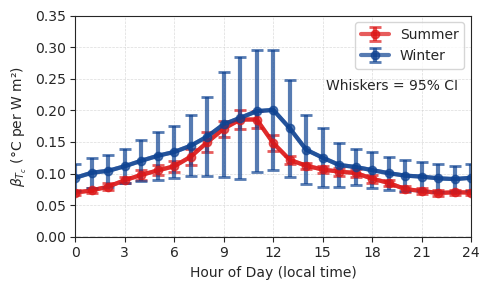

In [108]:
import pandas as pd
import numpy as np
from scipy.stats import linregress, t
import matplotlib.pyplot as plt

v = 'TC_URB'
months = [8, 12]  # summer, winter
control = 'ah_off'
target = 'ah_default'
targets = ['ah_default', 'ah_elec_low', 'ah_elec_medium', 'ah_elec_high']

# Define colors for summer/winter (matching your style)
# summer_color = '#D73027'  # similar to max_red
# winter_color = '#4575B4'  # similar to yale_blue
colors = {8: max_red, 12: yale_blue}
labels = {8: 'Summer', 12: 'Winter'}

# Store hourly beta and CI
beta_dict = {}
ci_dict = {}

for m in months:
    data = []
    for target in targets:
        delta_id = f'{control}-{target}-{m:02d}'
        ds = deltas[delta_id]

        # Spatial mean
        T = ds[v].mean(dim=['y','x'], skipna=True)
        AHF = ds['AHFLUX'].mean(dim=['y','x'], skipna=True)

        df = pd.DataFrame({
            'time': pd.to_datetime(T['Time'].values),
            'dT2': T.values,
            'dAHF': AHF.values,
            'target': target
        })
        df['hour'] = df['time'].dt.hour
        df['date'] = df['time'].dt.date
        data.append(df)

    df_all = pd.concat(data, ignore_index=True)

    # Hourly regression
    hourly_sensitivity = []
    for h in range(24):
        sub = df_all[df_all['hour'] == h]
        daily_means = sub.groupby(['target','date']).mean(numeric_only=True).reset_index()
        n_points = len(daily_means)
        if n_points >= 3 and daily_means['dAHF'].nunique() >= 2:
            slope, intercept, r, p, stderr = linregress(daily_means['dAHF'], daily_means['dT2'])
            dfree = n_points - 2
            tval = t.ppf(0.975, dfree)
            ci95 = tval * stderr
            hourly_sensitivity.append({'hour': h, 'beta': slope, 'ci95': ci95})
        else:
            hourly_sensitivity.append({'hour': h, 'beta': np.nan, 'ci95': np.nan})

    df_beta = pd.DataFrame(hourly_sensitivity)
    # wrap around hour 24
    df_beta = pd.concat([df_beta, df_beta.iloc[[0]].assign(hour=24)], ignore_index=True)

    beta_dict[m] = df_beta['beta']
    ci_dict[m] = df_beta['ci95']

# --- Plot ---
fig, ax = plt.subplots(figsize=(5,3))
print(m, len(beta_dict[m]), len(ci_dict[m]))


for m in months:
    n = len(beta_dict[m])
    df_beta = pd.DataFrame({
        'hour': np.arange(n+1),   # now length 26
        'beta': list(beta_dict[m]) + [beta_dict[m][0]],
        'ci95': list(ci_dict[m]) + [ci_dict[m][0]]
    })
    # Plot line + markers with error bars (whiskers)
    ax.errorbar(df_beta['hour'][:-1], df_beta['beta'][:-1],
                yerr=df_beta['ci95'][:-1],
                fmt='o-', color=colors[m], label=labels[m],
                linewidth=3, alpha=0.7, capsize=4, capthick=2)

    # Add connecting line to hour=24 without marker/whisker
    ax.plot(df_beta['hour'], df_beta['beta'], color=colors[m], linewidth=3, alpha=0.7)

# Axis styling
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlim(0, 24)
ax.set_ylim(0, 0.35)
ax.set_xticks(np.arange(0, 25, 3))
ax.set_xlabel('Hour of Day (local time)')
ax.set_ylabel(f'$\\beta_{{T_{{c}}}}$ ({degree_sign}C per W m²)')
ax.grid(linewidth=0.5, alpha=0.7, linestyle='--')
ax.legend()
ax.annotate('Whiskers = 95% CI', xy=(0.8, 0.65), xycoords='axes fraction',
            fontsize=10, ha='center', va='bottom')
# Save figure
save_filename = 'diurnal_tc_sensitivity_urban.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
plt.savefig(save_filepath, dpi=300, bbox_inches='tight')
plt.show()

### (b) Time-average (daily)

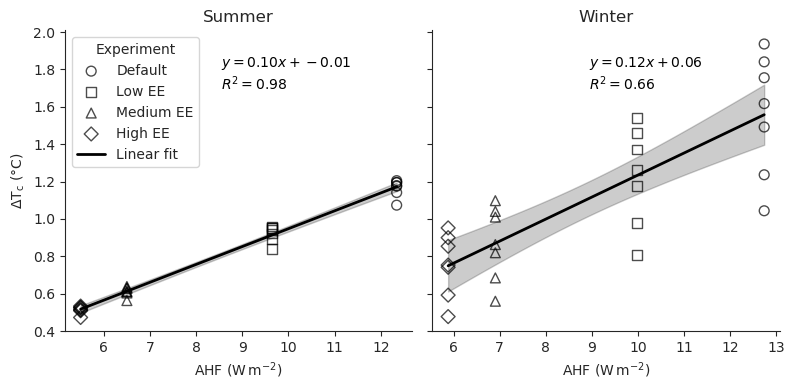

In [109]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import statsmodels.api as sm

v = 'TC_URB'
control = 'ah_off'
targets = ['ah_default', 'ah_elec_low', 'ah_elec_medium', 'ah_elec_high']
months = [8, 12]  # summer and winter
legend_labels = {
    'ah_default': 'Default',
    'ah_elec_low': 'Low EE',
    'ah_elec_medium': 'Medium EE',
    'ah_elec_high': 'High EE'
}
markers = ['o', 's', '^', 'D']

sns.set_style("ticks")
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

for ax, month in zip(axes, months):
    data = []
    for target in targets:
        delta_id = f'{control}-{target}-{month:02d}'
        ds = deltas[delta_id]

        T = ds[v].mean(dim=['y', 'x'], skipna=True)
        AHF = ds['AHFLUX'].mean(dim=['y', 'x'], skipna=True)

        df = pd.DataFrame({
            'time': pd.to_datetime(T['Time'].values),
            'dT2': T.values,
            'dAHF': AHF.values,
            'target': target
        }).set_index('time')

        df_daily = df.resample('1D').mean(numeric_only=True).dropna()
        df_daily['target'] = target
        data.append(df_daily.reset_index())

    df_all = pd.concat(data, ignore_index=True)

    # --- Regression with statsmodels for CI ---
    X = df_all['dAHF']
    y = df_all['dT2']
    X_sm = sm.add_constant(X)  # add intercept
    model = sm.OLS(y, X_sm).fit()
    predictions = model.get_prediction(X_sm)
    pred_mean = predictions.predicted_mean
    pred_ci = predictions.conf_int(alpha=0.05)  # 95% CI

    # Scatter points
    for i, target in enumerate(targets):
        df_sub = df_all[df_all['target'] == target]
        ax.scatter(
            df_sub['dAHF'], df_sub['dT2'],
            facecolors='none', edgecolor='black',
            alpha=0.7, s=50, marker=markers[i % len(markers)],
            label=legend_labels.get(target, target)
        )

    # Regression line
    x_vals = np.linspace(X.min(), X.max(), 100)
    X_plot = sm.add_constant(x_vals)
    y_pred = model.predict(X_plot)
    # Get CI for line
    pred_line = model.get_prediction(X_plot)
    ci_lower, ci_upper = pred_line.conf_int(alpha=0.05).T

    ax.plot(x_vals, y_pred, color='black', lw=2, label='Linear fit')
    ax.fill_between(x_vals, ci_lower, ci_upper, color='black', alpha=0.2)  # shaded CI

    # Axis labels
    ax.set_xlabel(ahf_label)
    ax.set_ylabel(del_tc_label) if ax == axes[0] else None

    # Equation text in normalized coords
    slope, intercept = model.params[1], model.params[0]
    r2 = model.rsquared
    line_eq = f"$y = {slope:.2f}x + {intercept:.2f}$\n$R^2 = {r2:.2f}$"
    ax.text(0.45, 0.8, line_eq, fontsize=10, color='black', transform=ax.transAxes)

    # Remove top/right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Title
    season = "Summer" if month == 8 else "Winter"
    ax.set_title(f'{season}')

# Legend once
axes[0].legend(loc='upper left', title='Experiment')
# Save figure
save_filename = 'scatter_tc_sensitivity_daily_urban.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
plt.savefig(save_filepath, dpi=300, bbox_inches='tight')
plt.show()

# Impacts by Neighborhood

## T2

In [215]:
v = 'T2'
m = 8
target = 'ah_default'
control = 'ah_off'
delta_id = f'{control}-{target}-{m:02d}'
# da = deltas[delta_id][v]
da_mean = deltas_all[delta_id][v].mean(dim='Time')
da_mean = da_mean.drop_vars(["XLAT", "XLONG"], errors="ignore")
da_mean.rio.write_crs(wrf_crs, inplace=True)
da_mean

<xarray.DataArray 'T2' (y: 192, x: 244)>
array([[-0.00276838, -0.00220272,  0.00165485, ...,  0.01637341,
         0.0225256 ,  0.00803884],
       [-0.00158492, -0.00156275, -0.0039028 , ...,  0.0361399 ,
         0.01565788,  0.00505992],
       [ 0.00090481, -0.00578363, -0.01134218, ...,  0.04352624,
         0.02371434,  0.017817  ],
       ...,
       [-0.00536401,  0.01190858,  0.02177538, ..., -0.01569803,
        -0.01662027,  0.00795528],
       [-0.02871214,  0.00295312,  0.01693653, ..., -0.00676491,
         0.00102743,  0.00183178],
       [-0.03074937,  0.00705519, -0.00611678, ..., -0.00415221,
        -0.0072105 , -0.00432605]], dtype=float32)
Coordinates:
  * y            (y) float64 -4.254e+05 -4.244e+05 ... -2.354e+05 -2.344e+05
  * x            (x) float64 1.325e+05 1.335e+05 ... 3.745e+05 3.755e+05
    spatial_ref  int64 0

In [216]:
da_mean.dims

('y', 'x')

In [217]:
da_mean_reproj = da_mean.rio.reproject('EPSG:4326')
print(da_mean_reproj.rio.crs)
print(da_mean_reproj.coords)

EPSG:4326
Coordinates:
  * x            (x) float64 -119.1 -119.0 -119.0 ... -116.3 -116.3 -116.3
  * y            (y) float64 35.0 34.99 34.98 34.97 ... 33.21 33.2 33.19 33.18
    spatial_ref  int64 0


In [218]:
# Mask unrealistic values
da_mean_reproj = da_mean_reproj.where(da_mean_reproj < 100)
# Explicitly set nodata in the raster metadata
da_mean_reproj.rio.write_nodata(np.nan, inplace=True)

<xarray.DataArray 'T2' (y: 178, x: 269)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x            (x) float64 -119.1 -119.0 -119.0 ... -116.3 -116.3 -116.3
  * y            (y) float64 35.0 34.99 34.98 34.97 ... 33.21 33.2 33.19 33.18
    spatial_ref  int64 0
Attributes:
    _FillValue:  nan

In [219]:
neighborhoods.crs

<Derived Projected CRS: EPSG:32611>
Name: WGS 84 / UTM zone 11N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 120°W and 114°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Alberta; British Columbia (BC); Northwest Territories (NWT); Nunavut. Mexico. United States (USA).
- bounds: (-120.0, 0.0, -114.0, 84.0)
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

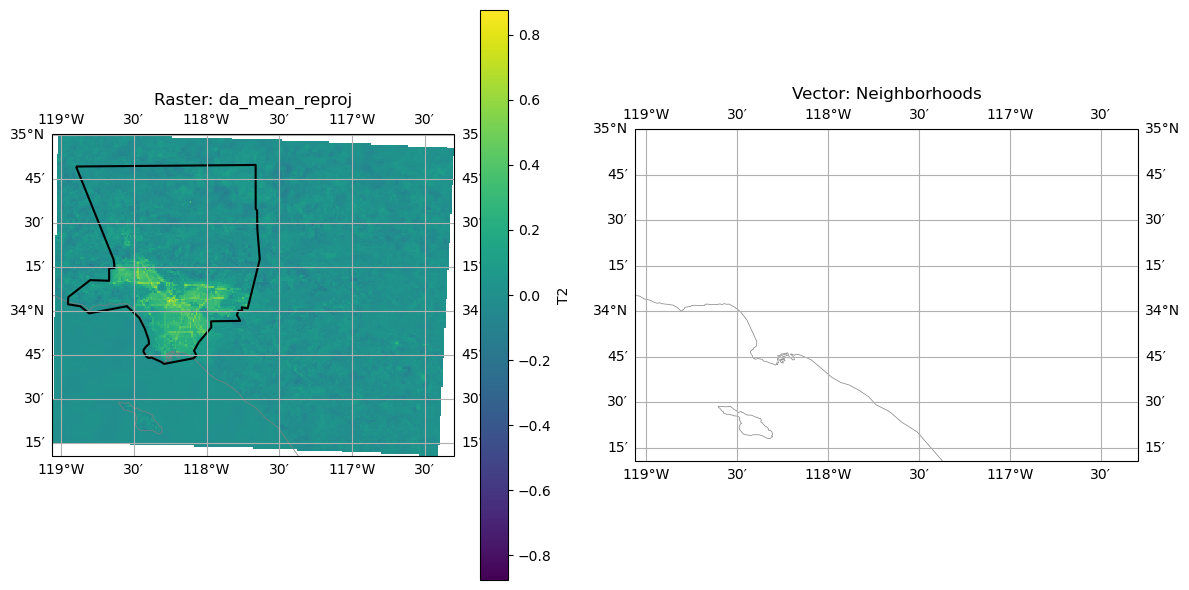

In [220]:
# Get the raster's bounds
xmin, ymin, xmax, ymax = da_mean_reproj.rio.bounds()

# Create a side-by-side figure
fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# --- Left: da_mean_reproj ---
da_mean_reproj.plot(ax=axes[0], cmap='viridis', cbar_kwargs={'label': da_mean_reproj.name})
axes[0].set_title("Raster: da_mean_reproj")
axes[0].set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

# Overlay LA County boundary
# Reproject to match raster CRS first
la_county_gdf_reproj = la_county_gdf.to_crs(da_mean_reproj.rio.crs)
la_county_gdf_reproj.boundary.plot(ax=axes[0], color='black', linewidth=1.5)

# --- Right: neighborhoods ---
neighborhoods.boundary.plot(ax=axes[1], color='k', linewidth=0.5)
axes[1].set_title("Vector: Neighborhoods")
axes[1].set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

for ax in axes:
    ax.coastlines(resolution='10m', color='gray', linewidth=0.5)
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

plt.tight_layout()
plt.show()


In [221]:
print(da_mean_reproj.min().values, da_mean_reproj.max().values)


-0.23440897 0.87685466


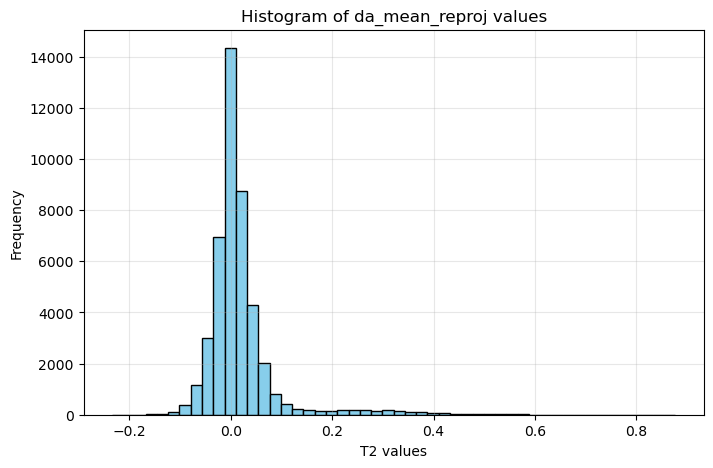

In [222]:
# Flatten the raster to 1D, ignoring NaNs
values = da_mean_reproj.values.flatten()
values = values[~np.isnan(values)]

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(values, bins=50, color='skyblue', edgecolor='k')
plt.xlabel(f"{da_mean_reproj.name} values")
plt.ylabel("Frequency")
plt.title("Histogram of da_mean_reproj values")
plt.grid(True, alpha=0.3)
plt.show()

In [223]:
means = []

for i, row in neighborhoods.iterrows():
    geom = [row.geometry]
    try:
        clipped = da_mean_reproj.rio.clip(geom, neighborhoods.crs, drop=True, invert=False)
        mean_val = float(clipped.mean().values)
    except Exception as e:
        # No overlap between polygon and raster
        mean_val = np.nan
    means.append(mean_val)

# Add as new column
neighborhoods["mean_delta_t2"] = means

In [224]:
df_sum_sorted

name      ahf_b     ahf_m      ahf_t    ahf_tot  \
59                    downtown  19.706390  1.113406  15.449724  36.269520   
230            university park  17.148950  1.008464  16.689608  34.847022   
229             universal city  21.325421  0.366269  12.702402  34.394092   
38                century city  26.432222  1.308241   6.577272  34.317735   
74              elysian valley   2.769894  0.307545  24.570172  27.647611   
..                         ...        ...       ...        ...        ...   
130               leona valley   0.021894  0.004936   0.136208   0.163038   
157  northeast antelope valley   0.005441  0.001908   0.087192   0.094541   
159  northwest antelope valley   0.005036  0.001014   0.080263   0.086312   
7                angeles crest   0.001422  0.000470   0.032141   0.034033   
121                lake hughes   0.021321  0.000947   0.007809   0.030077   

     f_traffic  f_building  f_metabolism  
59    0.425970    0.543332      0.030698  
230   0.478939    0.492121      0.028940  
229   0.369319    0.620032      0.010649  
38    0.191658    0.770220      0.038121  
74    0.888691    0.100186      0.011124  
..         ...         ...           ...  
130   0.835435    0.134287      0.030278  
157   0.922265    0.057552      0.020184  
159   0.929908    0.058344      0.011747  
7     0.944412    0.041788      0.013800  
121   0.259624    0.708885      0.031490  

[270 rows x 8 columns]

In [225]:
del_t2_hoods = neighborhoods.merge(
    df_sum_sorted,
    on='name',
    how='left'
)
del_t2_hoods

external_i             name  \
0              acton            acton   
1    adams-normandie  adams-normandie   
2       agoura-hills     agoura hills   
3         agua-dulce       agua dulce   
4           alhambra         alhambra   
..               ...              ...   
265      willowbrook      willowbrook   
266       wilmington       wilmington   
267   windsor-square   windsor square   
268         winnetka         winnetka   
269   woodland-hills   woodland hills   

                                          location             latitude  \
0    POINT(34.497355239240846 -118.16981019229348)  -118.16981019229348   
1    POINT(34.031461499124156 -118.30020800000011)  -118.30020800000011   
2    POINT(34.146736499122795 -118.75988450000015)  -118.75988450000015   
3     POINT(34.504926999796837 -118.3171036690717)   -118.3171036690717   
4    POINT(34.085538999123571 -118.13651200000021)  -118.13651200000021   
..                                             ...                  ...   
265  POINT(33.915710503828592 -118.25231247908229)  -118.25231247908229   
266   POINT(33.79129350128175 -118.25918700000008)  -118.25918700000008   
267  POINT(34.069108499123722 -118.31990900000005)  -118.31990900000005   
268  POINT(34.210459499121988 -118.57521950000014)  -118.57521950000014   
269  POINT(34.159408692550485 -118.61521650000006)  -118.61521650000006   

    slug_1            sqmi                                         display_na  \
0     None   39.3391089485           Acton L.A. County Neighborhood (Current)   
1     None  0.805350187789  Adams-Normandie L.A. County Neighborhood (Curr...   
2     None   8.14676029818    Agoura Hills L.A. County Neighborhood (Current)   
3     None   31.4626319451      Agua Dulce L.A. County Neighborhood (Current)   
4     None   7.62381430605        Alhambra L.A. County Neighborhood (Current)   
..     ...             ...                                                ...   
265   None   3.76636072646     Willowbrook L.A. County Neighborhood (Current)   
266   None    9.1412927044      Wilmington L.A. County Neighborhood (Current)   
267   None  0.683463802484  Windsor Square L.A. County Neighborhood (Current)   
268   None   4.77724070209        Winnetka L.A. County Neighborhood (Current)   
269   None    14.768309648  Woodland Hills L.A. County Neighborhood (Current)   

                                     set             slug           longitude  \
0    L.A. County Neighborhoods (Current)            acton  34.497355239240846   
1    L.A. County Neighborhoods (Current)  adams-normandie  34.031461499124156   
2    L.A. County Neighborhoods (Current)     agoura-hills  34.146736499122795   
3    L.A. County Neighborhoods (Current)       agua-dulce  34.504926999796837   
4    L.A. County Neighborhoods (Current)         alhambra  34.085538999123571   
..                                   ...              ...                 ...   
265  L.A. County Neighborhoods (Current)      willowbrook  33.915710503828592   
266  L.A. County Neighborhoods (Current)       wilmington   33.79129350128175   
267  L.A. County Neighborhoods (Current)   windsor-square  34.069108499123722   
268  L.A. County Neighborhoods (Current)         winnetka  34.210459499121988   
269  L.A. County Neighborhoods (Current)   woodland-hills  34.159408692550485   

     ...                 type  \
0    ...  unincorporated-area   
1    ...    segment-of-a-city   
2    ...      standalone-city   
3    ...  unincorporated-area   
4    ...      standalone-city   
..   ...                  ...   
265  ...  unincorporated-area   
266  ...    segment-of-a-city   
267  ...    segment-of-a-city   
268  ...    segment-of-a-city   
269  ...    segment-of-a-city   

                                              geometry mean_delta_t2  \
0    MULTIPOLYGON (((389644.320 3822577.416, 390850...     -0.019821   
1    MULTIPOLYGON (((379165.011 3767076.745, 379958...      0.361572   
2    MULTIPOLYGON (((337601.925 3782208.879, 340883...   

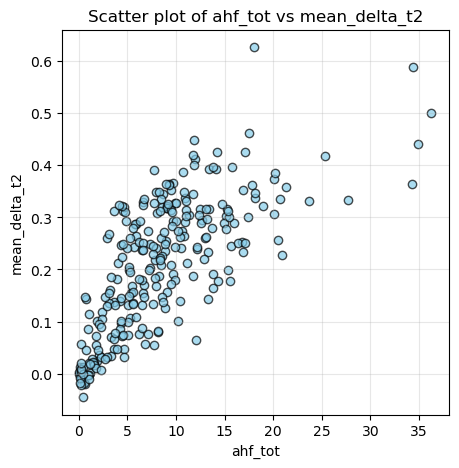

In [226]:
# Scatter plot
plt.figure(figsize=(5,5))
plt.scatter(
    del_t2_hoods['ahf_tot'],
    del_t2_hoods['mean_delta_t2'],
    color='skyblue', edgecolor='k', alpha=0.7
)

plt.xlabel("ahf_tot")
plt.ylabel("mean_delta_t2")
plt.title("Scatter plot of ahf_tot vs mean_delta_t2")
plt.grid(alpha=0.3)
plt.show()

In [227]:
# Drop rows where mean_delta_t2 is NaN
del_t2_clean = del_t2_hoods.dropna(subset=['mean_delta_t2'])

# Sort by mean_delta_t2 descending
del_t2_sorted = del_t2_clean.sort_values(by='mean_delta_t2', ascending=False)

# Top 5 neighborhoods
print("Top 5 neighborhoods by mean_delta_t2:")
print(del_t2_sorted.head(25)[['name', 'mean_delta_t2']])

# Bottom 5 neighborhoods
print("\nBottom 5 neighborhoods by mean_delta_t2:")
print(del_t2_sorted.tail(25)[['name', 'mean_delta_t2']])

Top 5 neighborhoods by mean_delta_t2:
                         name  mean_delta_t2
48                  chinatown       0.625831
231            universal city       0.587114
64                   downtown       0.498739
30              boyle heights       0.461956
261  west whittier-los nietos       0.447993
235           university park       0.441069
238            valley village       0.425663
229               toluca lake       0.425218
241                  van nuys       0.418565
255                  westlake       0.416677
139           lincoln heights       0.410974
164           north hollywood       0.400433
196          santa fe springs       0.395833
52                   commerce       0.395339
74                  echo park       0.392587
71           east los angeles       0.391469
201               san gabriel       0.390744
13            atwater village       0.385783
110    historic south-central       0.384246
68             east hollywood       0.373101
4                

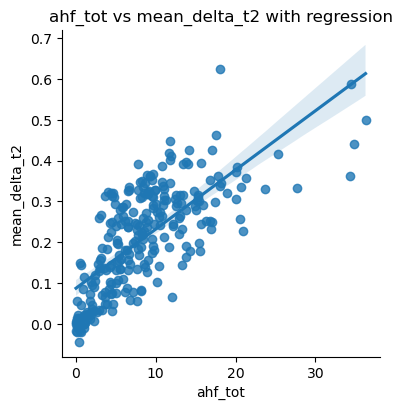

In [228]:
import seaborn as sns
sns.lmplot(data=del_t2_hoods, x='ahf_tot', y='mean_delta_t2', height=4, aspect=1.0, )
plt.title("ahf_tot vs mean_delta_t2 with regression")
plt.show()

## T2 (new code)

In [110]:
v = 'T2'
m = 8
target = 'ah_default'
control = 'ah_off'
delta_id = f'{control}-{target}-{m:02d}'
da_mean = deltas_all[delta_id][v].mean(dim='Time')
da_mean = da_mean.drop_vars(["XLAT", "XLONG"], errors="ignore")
da_mean.rio.write_crs(wrf_crs, inplace=True)
# da_mean_reproj = da_mean.rio.reproject('EPSG:4326')
da_mean_reproj = da_mean.rio.reproject(neighborhoods.crs)
# Mask unrealistic values
da_mean_reproj = da_mean_reproj.where(da_mean_reproj < 100)
# Explicitly set nodata in the raster metadata
da_mean_reproj.rio.write_nodata(np.nan, inplace=True)
# turn NaNs to zero
da_mean_reproj = da_mean_reproj.fillna(0)

In [111]:
# NEW CODE TO CLIP TO NEIGHBORHOOD (10/5)
da = da_mean_reproj
if "band" in da.dims: da = da.sel(band=da.band.values[0])
da = da.squeeze()

# find coord names
dims = [d for d in da.dims if d != "band"]
yname, xname = dims[-2], dims[-1]

# raster points dataframe (non-NaN)
pts = da.to_dataframe(name="value").reset_index().dropna(subset=["value"])

# buffer choice (degrees vs projected units)
crs = da.rio.crs
is_geo = getattr(crs, "is_geographic", False)
base_buf = 0.02 if is_geo else 1000.0

neighborhoods["geometry"] = neighborhoods["geometry"].buffer(0)
means = []
for i, row in neighborhoods.iterrows():
    geom = [row.geometry]
    try:
        clipped = da.rio.clip(geom, da.rio.crs, drop=True, invert=False)
        mean_val = float(np.nanmean(clipped.values))
        if np.isnan(mean_val):
            raise ValueError("clipped all-NaN")
    except Exception as e:
        print(f"No overlap for {row.get('name',i)}: {e}")
        # reproject neighborhood to raster CRS and get bounds
        nb = gpd.GeoDataFrame([row], crs=neighborhoods.crs).to_crs(da.rio.crs)
        minx, miny, maxx, maxy = nb.total_bounds

        # expand bbox until we find surrounding points (iterative)
        buf = base_buf
        pts_bbox = pts
        for _ in range(6):
            mask = (pts[xname] >= minx - buf) & (pts[xname] <= maxx + buf) & (pts[yname] >= miny - buf) & (pts[yname] <= maxy + buf)
            pts_bbox = pts[mask]
            if not pts_bbox.empty:
                break
            buf *= 2

        # if still empty, fallback to nearest points in entire raster
        search_df = pts_bbox.copy() if not pts_bbox.empty else pts.copy()

        # compute center = average of surrounding points, then pick nearest k around that center
        cx, cy = float(search_df[xname].mean()), float(search_df[yname].mean())
        search_df = search_df.copy()
        search_df["dist2"] = (search_df[xname] - cx) ** 2 + (search_df[yname] - cy) ** 2
        k = min(8, len(search_df))
        nearest = search_df.nsmallest(k, "dist2")
        mean_val = float(nearest["value"].mean()) if k > 0 else np.nan

        # debug
        print(mean_val)

    means.append(mean_val)

neighborhoods["mean_delta_t2"] = means

No overlap for larchmont: No data found in bounds. Data variable: T2
0.30452147126197815


In [112]:
del_t_hoods = neighborhoods.merge(
    df_sum_sorted,
    on='name',
    how='left'
)
# Drop rows where mean_delta_tc is NaN
del_t_clean = del_t_hoods.dropna(subset=['mean_delta_t2'])

# Sort by mean_delta_tc descending
del_t_sorted = del_t_clean.sort_values(by='mean_delta_t2', ascending=False)

# Top 5 neighborhoods
print("Top 5 neighborhoods by mean_delta_t2:")
print(del_t_sorted.head(10)[['name', 'mean_delta_t2']])

# Bottom 5 neighborhoods
print("\nBottom 5 neighborhoods by mean_delta_t2:")
print(del_t_sorted.tail(10)[['name', 'mean_delta_t2']])

Top 5 neighborhoods by mean_delta_t2:
                name  mean_delta_t2
64          downtown       0.520016
235  university park       0.508100
231   universal city       0.501825
48         chinatown       0.500193
30     boyle heights       0.459932
229      toluca lake       0.453021
139  lincoln heights       0.434439
255         westlake       0.433148
241         van nuys       0.426833
238   valley village       0.425663

Bottom 5 neighborhoods by mean_delta_t2:
                          name  mean_delta_t2
173                   palmdale      -0.003136
138               leona valley      -0.004376
70              elizabeth lake      -0.015771
3                   agua dulce      -0.017755
165  northwest antelope valley      -0.019097
0                        acton      -0.019602
193              rolling hills      -0.020944
121      la crescenta-montrose      -0.023410
127           lake los angeles      -0.034531
260             west san dimas      -0.048646


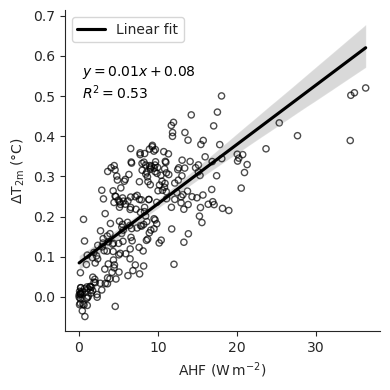

In [129]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress
import os

# Regression
x = del_t_hoods['ahf_tot']
y = del_t_hoods['mean_delta_t2']
slope, intercept, r_value, p_value, std_err = linregress(x, y)
line_eq = f"$y = {slope:.2f}x + {intercept:.2f}$\n$R^2 = {r_value**2:.2f}$"

# Create lmplot
g = sns.lmplot(
    data=del_t_hoods, 
    x='ahf_tot', y='mean_delta_t2', 
    height=4, aspect=1.0,
    scatter_kws={
        'facecolors': 'none',  # hollow circles
        'edgecolor': 'black',
        'alpha': 0.7,
        's': 20
    },
    line_kws={'color': 'black', 'label': 'Linear fit'}  # legend label
)

# Axis labels
g.set_axis_labels(ahf_label, del_ta_label)

# Access the underlying Axes
ax = g.ax

# Annotate regression equation
x_pos = x.min() + 0.01*(x.max()-x.min())
y_pos = y.max() - 0.05*(y.max()-y.min())
ax.text(x_pos, y_pos, line_eq, fontsize=10, color='black')

# Show legend
ax.legend(loc='upper left')

# Save figure
save_filename = 'scatter_del_t2_ahf_neighborhood.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
plt.savefig(save_filepath, dpi=300, bbox_inches='tight')
plt.show()

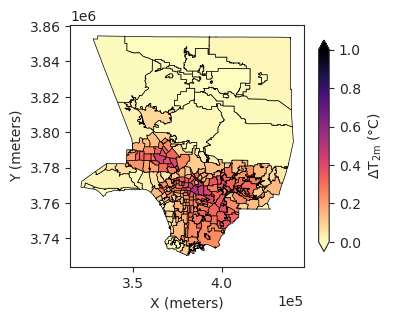

In [117]:
# Check for unusally high values of deltas
# unincorporated santa susana mountains
# --- Base plot: neighborhoods colored by mean_delta_tc ---
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
del_t_hoods.plot(
    column='mean_delta_t2',         # color by this variable
    cmap='magma_r',               # colormap
    legend=True,                  # show colorbar
    ax=ax,
    edgecolor='black',            # default edge color
    linewidth=0.5,
    vmin=0,
    vmax=1.0,
    legend_kwds={
        'label':del_ta_label,
        'extend':'both',
        'shrink': 0.6
    }
)

# --- Highlight specific neighborhood with red outline ---
nbd_name = 'larchmont'
highlight = del_t_hoods[del_t_hoods['name'].str.lower() == nbd_name]
# highlight.boundary.plot(ax=ax, color='red', linewidth=2)

# --- Labels / formatting ---
# ax.set_title("Neighborhoods colored by mean_del_t2", fontsize=16)
# ax.set_axis_off()  # optional, removes axes ticks
ax.set_xlabel("X (meters)")
ax.set_ylabel("Y (meters)")
ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

# Save figure
save_filename = 'map_del_t2_neighborhood.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
plt.savefig(save_filepath, dpi=300, bbox_inches='tight')
plt.show()

## TC

In [118]:
v = 'TC_URB'
m = 8
target = 'ah_default'
control = 'ah_off'
delta_id = f'{control}-{target}-{m:02d}'
# da = deltas[delta_id][v]
da_mean = deltas_all[delta_id][v].mean(dim='Time')
da_mean = da_mean.drop_vars(["XLAT", "XLONG"], errors="ignore")
da_mean.rio.write_crs(wrf_crs, inplace=True)
# da_mean_reproj = da_mean.rio.reproject('EPSG:4326')
da_mean_reproj = da_mean.rio.reproject(neighborhoods.crs)
# Mask unrealistic values
da_mean_reproj = da_mean_reproj.where(da_mean_reproj < 100)
# Explicitly set nodata in the raster metadata
da_mean_reproj.rio.write_nodata(np.nan, inplace=True)
# turn NaNs to zero
da_mean_reproj = da_mean_reproj.fillna(0)

In [119]:
print("Raster CRS:", da_mean_reproj.rio.crs)
print("Neighborhoods CRS:", neighborhoods.crs)


Raster CRS: EPSG:32611
Neighborhoods CRS: EPSG:32611


In [120]:
# neighborhoods["geometry"] = neighborhoods["geometry"].buffer(0)
# means = []

# for i, row in neighborhoods.iterrows():
#     geom = [row.geometry]
#     try:
#         clipped = da_mean_reproj.rio.clip(geom, da_mean_reproj.rio.crs, drop=True, invert=False)
#         mean_val = float(clipped.mean().values)
#     except Exception as e:
#         print(f"No overlap for {row['name']}: {e}")
#         mean_val = np.nan
#     means.append(mean_val)

# neighborhoods["mean_delta_tc"] = means

In [121]:
# NEW CODE TO CLIP TO NEIGHBORHOOD (10/5)
da = da_mean_reproj
if "band" in da.dims: da = da.sel(band=da.band.values[0])
da = da.squeeze()

# find coord names
dims = [d for d in da.dims if d != "band"]
yname, xname = dims[-2], dims[-1]

# raster points dataframe (non-NaN)
pts = da.to_dataframe(name="value").reset_index().dropna(subset=["value"])

# buffer choice (degrees vs projected units)
crs = da.rio.crs
is_geo = getattr(crs, "is_geographic", False)
base_buf = 0.02 if is_geo else 1000.0

neighborhoods["geometry"] = neighborhoods["geometry"].buffer(0)
means = []
for i, row in neighborhoods.iterrows():
    geom = [row.geometry]
    try:
        clipped = da.rio.clip(geom, da.rio.crs, drop=True, invert=False)
        mean_val = float(np.nanmean(clipped.values))
        if np.isnan(mean_val):
            raise ValueError("clipped all-NaN")
    except Exception as e:
        print(f"No overlap for {row.get('name',i)}: {e}")
        # reproject neighborhood to raster CRS and get bounds
        nb = gpd.GeoDataFrame([row], crs=neighborhoods.crs).to_crs(da.rio.crs)
        minx, miny, maxx, maxy = nb.total_bounds

        # expand bbox until we find surrounding points (iterative)
        buf = base_buf
        pts_bbox = pts
        for _ in range(6):
            mask = (pts[xname] >= minx - buf) & (pts[xname] <= maxx + buf) & (pts[yname] >= miny - buf) & (pts[yname] <= maxy + buf)
            pts_bbox = pts[mask]
            if not pts_bbox.empty:
                break
            buf *= 2

        # if still empty, fallback to nearest points in entire raster
        search_df = pts_bbox.copy() if not pts_bbox.empty else pts.copy()

        # compute center = average of surrounding points, then pick nearest k around that center
        cx, cy = float(search_df[xname].mean()), float(search_df[yname].mean())
        search_df = search_df.copy()
        search_df["dist2"] = (search_df[xname] - cx) ** 2 + (search_df[yname] - cy) ** 2
        k = min(8, len(search_df))
        nearest = search_df.nsmallest(k, "dist2")
        mean_val = float(nearest["value"].mean()) if k > 0 else np.nan

        # debug
        print(mean_val)

    means.append(mean_val)

neighborhoods["mean_delta_tc"] = means

No overlap for larchmont: No data found in bounds. Data variable: TC_URB
1.3099055290222168


No overlap for larchmont -> No data found in bounds. Data variable: TC_URB


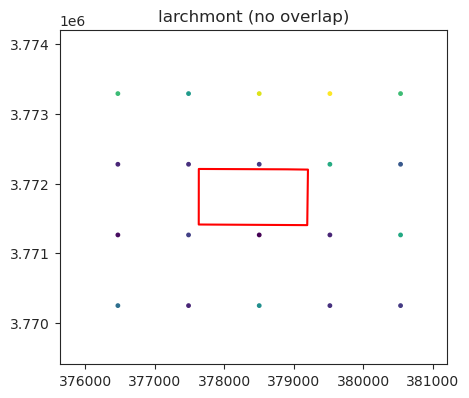

In [122]:
da = da_mean_reproj
if "band" in da.dims: da = da.sel(band=da.band.values[0])
da = da.squeeze()
dims = [d for d in da.dims if d != "band"]
yname, xname = dims[-2], dims[-1]

df = da.to_dataframe(name="val").reset_index().dropna(subset=["val"])
pts = gpd.GeoDataFrame(df, geometry=[Point(xy) for xy in zip(df[xname], df[yname])], crs=da.rio.crs)

geo = getattr(da.rio.crs, "is_geographic", False)
buf = 0.02 if geo else 2000.0

for i, row in neighborhoods.iterrows():
    name = row.get("name", f"nb_{i}")
    try:
        clipped = da.rio.clip([row.geometry], da.rio.crs, drop=True, invert=False)
        if np.isnan(np.nanmean(clipped.values)): raise ValueError("all NaN")
    except Exception as e:
        print("No overlap for", name, "->", e)
        nb = gpd.GeoDataFrame([row], crs=neighborhoods.crs).to_crs(da.rio.crs)
        minx, miny, maxx, maxy = nb.total_bounds
        minx, miny, maxx, maxy = minx-buf, miny-buf, maxx+buf, maxy+buf

        nearby = pts[(pts.geometry.x>=minx)&(pts.geometry.x<=maxx)&(pts.geometry.y>=miny)&(pts.geometry.y<=maxy)]
        fig, ax = plt.subplots(figsize=(5,5))
        if not nearby.empty:
            nearby.plot(ax=ax, column="val", cmap="viridis", markersize=6)
        else:
            ext = buf*3
            ctx = pts[(pts.geometry.x>=minx-ext)&(pts.geometry.x<=maxx+ext)&(pts.geometry.y>=miny-ext)&(pts.geometry.y<=maxy+ext)]
            if not ctx.empty:
                ctx.plot(ax=ax, color="lightblue", markersize=3)
            else:
                nb.centroid.plot(ax=ax, color="orange", marker="x", markersize=50)

        nb.boundary.plot(ax=ax, edgecolor="red", linewidth=1.5)
        ax.set_xlim(minx, maxx); ax.set_ylim(miny, maxy)
        ax.set_title(f"{name} (no overlap)"); plt.show()

In [123]:
# means = []

# for i, row in neighborhoods.iterrows():
#     geom = [row.geometry]
#     try:
#         clipped = da_mean_reproj.rio.clip(geom, neighborhoods.crs, drop=True, invert=False)
#         mean_val = float(clipped.mean().values)
#     except Exception as e:
#         # No overlap between polygon and raster
#         print(row)
#         mean_val = np.nan
#     means.append(mean_val)

# # Add as new column
# neighborhoods["mean_delta_tc"] = means

In [124]:
del_t_hoods = neighborhoods.merge(
    df_sum_sorted,
    on='name',
    how='left'
)

In [125]:
# Drop rows where mean_delta_tc is NaN
del_t_clean = del_t_hoods.dropna(subset=['mean_delta_tc'])

# Sort by mean_delta_tc descending
del_t_sorted = del_t_clean.sort_values(by='mean_delta_tc', ascending=False)

# Top 5 neighborhoods
print("Top 5 neighborhoods by mean_delta_tc:")
print(del_t_sorted.head(10)[['name', 'mean_delta_tc']])

# Bottom 5 neighborhoods
print("\nBottom 5 neighborhoods by mean_delta_tc:")
print(del_t_sorted.tail(10)[['name', 'mean_delta_tc']])

Top 5 neighborhoods by mean_delta_tc:
                        name  mean_delta_tc
231           universal city       4.879354
42              century city       3.877570
64                  downtown       3.500892
235          university park       3.084155
246  veterans administration       2.857213
229              toluca lake       2.765852
262                 westwood       2.345293
238           valley village       2.123748
179               pico-union       2.101646
11         arlington heights       2.077355

Bottom 5 neighborhoods by mean_delta_tc:
                                      name  mean_delta_tc
240                              val verde            0.0
239  unincorporated santa monica mountains            0.0
31                                bradbury            0.0
165              northwest antelope valley            0.0
70                          elizabeth lake            0.0
214              southeast antelope valley            0.0
213                      south

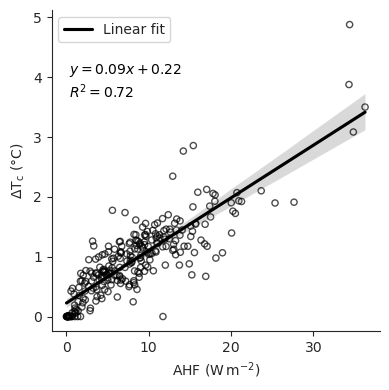

In [130]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress
import os

# Extract x and y for regression
x = del_t_hoods['ahf_tot']
y = del_t_hoods['mean_delta_tc']

# Compute linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)
line_eq = f"$y = {slope:.2f}x + {intercept:.2f}$\n$R^2 = {r_value**2:.2f}$"

# Create lmplot
g = sns.lmplot(
    data=del_t_hoods, 
    x='ahf_tot', 
    y='mean_delta_tc', 
    height=4, 
    aspect=1.0,
    scatter_kws={
        'facecolors': 'none',  # hollow circles
        'edgecolor': 'black',
        'alpha': 0.7,
        's': 20
    },
    line_kws={'color': 'black', 'label': 'Linear fit'}
)

# Access underlying Axes
ax = g.ax

# Set axis labels and title
ax.set_xlabel(ahf_label)
ax.set_ylabel(del_tc_label)
# ax.set_title("AHF vs Mean Temperature Change")

# Annotate regression equation on the plot
x_pos = x.min() + 0.01*(x.max() - x.min())
y_pos = y.max() - 0.25*(y.max() - y.min())
ax.text(x_pos, y_pos, line_eq, fontsize=10, color='black')

# Show legend
ax.legend()

# Save figure
save_filename = 'scatter_del_tc_ahf_neighborhood.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
plt.savefig(save_filepath, dpi=300, bbox_inches='tight')
plt.show()

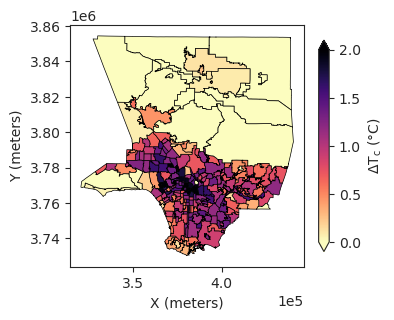

In [128]:
# Base plot: neighborhoods colored by mean_delta_tc
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

del_t_hoods.plot(
    column='mean_delta_tc',       # color by this variable
    cmap='magma_r',               # colormap
    legend=True,                  # show colorbar
    ax=ax,
    edgecolor='black',            # boundary color
    linewidth=0.5,
    vmin=0,
    vmax=2,                       # set max value for color scale
    legend_kwds={
        'label': del_tc_label,
        'extend': 'both',
        'shrink': 0.6}
)

# Highlight specific neighborhood with red outline
nbd_name = 'toluca lake'
highlight = del_t_hoods[del_t_hoods['name'].str.lower() == nbd_name]
# highlight.boundary.plot(ax=ax, color='red', linewidth=2)

# Labels / formatting
# ax.set_title("Neighborhoods colored by mean ΔT (°C)", fontsize=16)
ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))  # scientific notation if needed
ax.set_xlabel("X (meters)")
ax.set_ylabel("Y (meters)")
# ax.set_axis_off()  # optional: remove axes ticks

# Save figure
save_filename = 'map_del_tc_neighborhood.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
plt.savefig(save_filepath, dpi=300, bbox_inches='tight')
plt.show()

# Impacts: near highway

Highway buffer geometry saved in highway_buffer.  
LA County boundary saved in la_county_gdf.

## T2

In [56]:
v = 'T2'
m = 8
target = 'ah_default'
control = 'ah_off'
delta_id = f'{control}-{target}-{m:02d}'
da = deltas[delta_id][v]
da = da.drop_vars(['XLAT', 'XLONG'])
da = da.rio.write_crs(wrf_crs)
# convert both wrf out and highway buffer to same crs
target_crs = 32611
highway_buffer_reproj = highway_buffer.to_crs(epsg=target_crs)
da_reproj = da.rio.reproject(highway_buffer_reproj.crs)
print(da_reproj.rio.crs)
# get data near highway and data not near highway
da_near_highway = da_reproj.rio.clip(
    highway_buffer_reproj.geometry,
    highway_buffer_reproj.crs,
    drop=False,        # keep original grid size; just mask outside area
    invert=False       # if True, masks *inside* instead of outside
)
da_not_near_highway = da_reproj.rio.clip(
    highway_buffer_reproj.geometry,
    highway_buffer_reproj.crs,
    drop=False,        # keep original grid size; just mask outside area
    invert=True       # if True, masks *inside* instead of outside
)

EPSG:32611


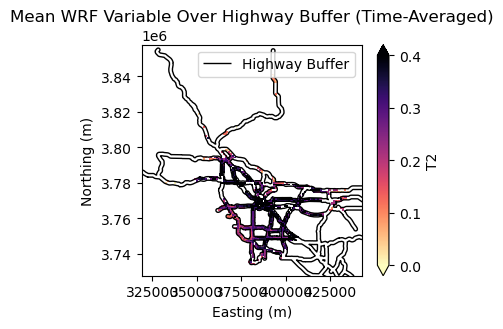

In [57]:
# Compute mean over time (ignores NaNs automatically)
da_mean = da_near_highway.mean(dim="Time", skipna=True)

# Create figure
fig, ax = plt.subplots(figsize=(4, 3))

# Plot the mean field
da_mean.plot(
    ax=ax,
    cmap="magma_r",     # or 'RdYlBu_r', 'viridis', etc.
    robust=True,
    vmin=0, vmax=0.4
)

# Overlay the highway buffer outlines
highway_buffer_reproj.boundary.plot(
    ax=ax,
    color="black",
    linewidth=1.0,
    label="Highway Buffer"
)

# Labels and title
ax.set_title("Mean WRF Variable Over Highway Buffer (Time-Averaged)", fontsize=12)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
ax.legend()

plt.show()

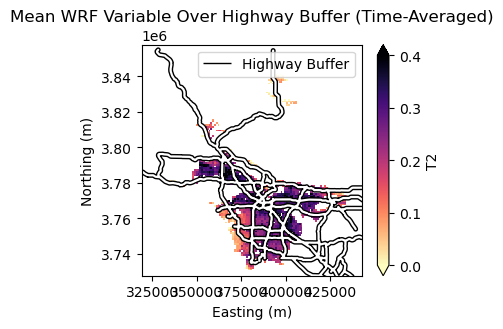

In [58]:
# Compute mean over time (ignores NaNs automatically)
da_mean = da_not_near_highway.mean(dim="Time", skipna=True)

# Create figure
fig, ax = plt.subplots(figsize=(4, 3))

# Plot the mean field
da_mean.plot(
    ax=ax,
    cmap="magma_r",     # or 'RdYlBu_r', 'viridis', etc.
    robust=True,
    vmin=0, vmax=0.4
)

# Overlay the highway buffer outlines
highway_buffer_reproj.boundary.plot(
    ax=ax,
    color="black",
    linewidth=1.0,
    label="Highway Buffer"
)

# Labels and title
ax.set_title("Mean WRF Variable Over Highway Buffer (Time-Averaged)", fontsize=12)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
ax.legend()

plt.show()

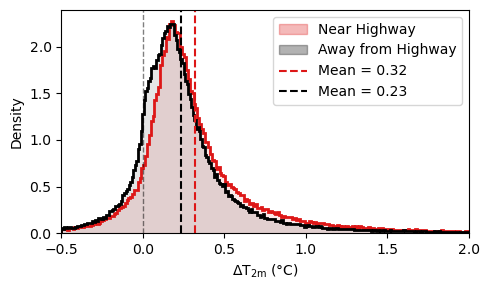

In [84]:
import matplotlib.patches as mpatches
# Flatten and clean data
vals_near = da_near_highway.values.flatten()
vals_not_near = da_not_near_highway.values.flatten()
vals_near = vals_near[~np.isnan(vals_near)]
vals_not_near = vals_not_near[~np.isnan(vals_not_near)]

# Compute means
mean_near = np.mean(vals_near)
mean_not_near = np.mean(vals_not_near)

# Plot
fig, ax = plt.subplots(figsize=(5, 3))
xlim = (-0.5, 2)

# Near highway: filled transparent histogram
n_near, bins_near, patches_near = ax.hist(
    vals_near,
    bins='auto',
    range=xlim,
    histtype='stepfilled',
    density=True,
    color=max_red,
    alpha=0.1,
    edgecolor='none',
    label='Near Highway'
)
# Near highway: edge line
ax.hist(
    vals_near,
    bins=bins_near,
    range=xlim,
    histtype='step',
    density=True,
    color=max_red,
    linewidth=2,
    alpha=1
)

# Not-near highway: filled transparent histogram
n_not, bins_not, patches_not = ax.hist(
    vals_not_near,
    bins='auto',
    range=xlim,
    histtype='stepfilled',
    density=True,
    color='black',
    alpha=0.1,
    edgecolor='none',
    label='Away from Highway'
)
# Not-near highway: edge line
ax.hist(
    vals_not_near,
    bins=bins_not,
    range=xlim,
    histtype='step',
    density=True,
    color='black',
    linewidth=2,
    alpha=1
)

# Vertical mean lines
ax.axvline(mean_near, color=max_red, linestyle='--', label=f'Mean = {mean_near:.2f}')
ax.axvline(mean_not_near, color='black', linestyle='--', label=f'Mean = {mean_not_near:.2f}')

# Labels, legend, grid, etc.
ax.set_xlabel(del_ta_label)
ax.set_ylabel("Density")
ax.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlim(xlim)

# Create custom legend handles
near_handle = mpatches.Patch(facecolor=max_red, edgecolor=max_red, alpha=0.3, label=f'Near Highway')
not_handle = mpatches.Patch(facecolor='black', edgecolor='black', alpha=0.3, label=f'Away from Highway')

# Add vertical line handles separately if you want
mean_near_handle = plt.Line2D([], [], color=max_red, linestyle='--', label=f'Mean = {mean_near:.2f}')
mean_not_handle = plt.Line2D([], [], color='black', linestyle='--', label=f'Mean = {mean_not_near:.2f}')

# Replace default legend with custom handles
ax.legend(handles=[near_handle, not_handle, mean_near_handle, mean_not_handle], fontsize=10)

# ax.legend()

# Optional: save plot
os.makedirs(plot_dir, exist_ok=True)
save_filepath = os.path.join(plot_dir, 'hist_del_t2_near_highway.png')
plt.tight_layout()
plt.savefig(save_filepath, dpi=300, bbox_inches='tight')
plt.show()


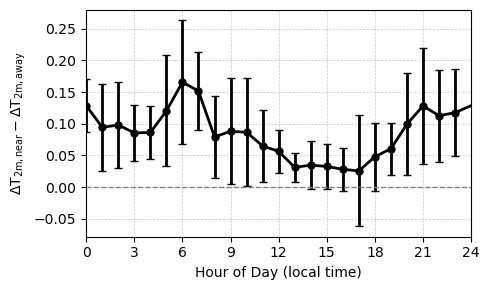

In [94]:
# Compute spatial mean for each timestep
spatial_mean_near = da_near_highway.mean(dim=["x", "y"], skipna=True)
spatial_mean_not_near = da_not_near_highway.mean(dim=["x", "y"], skipna=True)

# Convert to DataFrame for easier grouping by hour
df_near = spatial_mean_near.to_dataframe(name="near")
df_not_near = spatial_mean_not_near.to_dataframe(name="not_near")

# Group by hour to get diurnal cycle
grouped_near = df_near.groupby("hour")["near"]
grouped_not_near = df_not_near.groupby("hour")["not_near"]

# Compute mean, std, count, and 95% CI
mean_near = grouped_near.mean()
std_near = grouped_near.std()
n_near = grouped_near.count()
ci_near = 1.96 * std_near / np.sqrt(n_near)

mean_not_near = grouped_not_near.mean()
std_not_near = grouped_not_near.std()
n_not_near = grouped_not_near.count()
ci_not_near = 1.96 * std_not_near / np.sqrt(n_not_near)

# Compute difference and combined CI (assuming independence)
diff = mean_near - mean_not_near
ci_diff = np.sqrt(ci_near**2 + ci_not_near**2)

# Wrap diurnal cycle to hour 24 using concat
diff_wrapped = pd.concat([diff, pd.Series(diff.iloc[0], index=[24])])
ci_diff_wrapped = pd.concat([ci_diff, pd.Series(ci_diff.iloc[0], index=[24])])

# --- Plot ---
fig, ax = plt.subplots(figsize=(5, 3))

# Plot line with markers for hours 0-23 only
ax.errorbar(
    diff.index,
    diff.values,
    yerr=ci_diff.values,
    fmt='o',
    markersize=5,
    color='black',
    elinewidth=2,
    capsize=3,
    label='Near − Not Near Highway (95% CI)'
)

# Plot connecting line to hour 24 (no marker)
ax.plot(diff_wrapped.index, diff_wrapped.values, color='black', linewidth=2)

# Horizontal line at 0
ax.axhline(0, color='gray', linestyle='--', linewidth=1)

# X-axis settings: ticks every 3 hours
ax.set_xticks(np.arange(0, 25, 3))
ax.set_xlim(0, 24)

# Labels, legend, grid
ax.set_xlabel("Hour of Day (local time)")
ax.set_ylabel(r'$\mathrm{\Delta T_{2m, near}} - \mathrm{\Delta T_{2m, away}}$')
ax.grid(linewidth=0.5, alpha=0.7, linestyle='--')
os.makedirs(plot_dir, exist_ok=True)
save_filepath = os.path.join(plot_dir, 'diurnal_del_t2_near_highway.png')
plt.tight_layout()
plt.savefig(save_filepath, dpi=300, bbox_inches='tight')
plt.show()

## TC

In [95]:
v = 'TC_URB'
m = 8
target = 'ah_default'
control = 'ah_off'
delta_id = f'{control}-{target}-{m:02d}'
da = deltas[delta_id][v]
da = da.drop_vars(['XLAT', 'XLONG'])
da = da.rio.write_crs(wrf_crs)
# convert both wrf out and highway buffer to same crs
target_crs = 32611
highway_buffer_reproj = highway_buffer.to_crs(epsg=target_crs)
da_reproj = da.rio.reproject(highway_buffer_reproj.crs)
# get data near highway and data not near highway
da_near_highway = da_reproj.rio.clip(
    highway_buffer_reproj.geometry,
    highway_buffer_reproj.crs,
    drop=False,        # keep original grid size; just mask outside area
    invert=False       # if True, masks *inside* instead of outside
)
da_not_near_highway = da_reproj.rio.clip(
    highway_buffer_reproj.geometry,
    highway_buffer_reproj.crs,
    drop=False,        # keep original grid size; just mask outside area
    invert=True       # if True, masks *inside* instead of outside
)


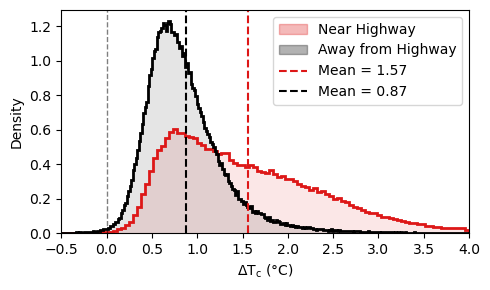

In [98]:
import matplotlib.patches as mpatches
# Flatten and clean data
vals_near = da_near_highway.values.flatten()
vals_not_near = da_not_near_highway.values.flatten()
vals_near = vals_near[~np.isnan(vals_near)]
vals_not_near = vals_not_near[~np.isnan(vals_not_near)]

# Compute means
mean_near = np.mean(vals_near)
mean_not_near = np.mean(vals_not_near)

# Plot
fig, ax = plt.subplots(figsize=(5, 3))
xlim = (-0.5, 4)

# Near highway: filled transparent histogram
n_near, bins_near, patches_near = ax.hist(
    vals_near,
    bins='auto',
    range=xlim,
    histtype='stepfilled',
    density=True,
    color=max_red,
    alpha=0.1,
    edgecolor='none',
    label='Near Highway'
)
# Near highway: edge line
ax.hist(
    vals_near,
    bins=bins_near,
    range=xlim,
    histtype='step',
    density=True,
    color=max_red,
    linewidth=2,
    alpha=1
)

# Not-near highway: filled transparent histogram
n_not, bins_not, patches_not = ax.hist(
    vals_not_near,
    bins='auto',
    range=xlim,
    histtype='stepfilled',
    density=True,
    color='black',
    alpha=0.1,
    edgecolor='none',
    label='Away from Highway'
)
# Not-near highway: edge line
ax.hist(
    vals_not_near,
    bins=bins_not,
    range=xlim,
    histtype='step',
    density=True,
    color='black',
    linewidth=2,
    alpha=1
)

# Vertical mean lines
ax.axvline(mean_near, color=max_red, linestyle='--', label=f'Mean = {mean_near:.2f}')
ax.axvline(mean_not_near, color='black', linestyle='--', label=f'Mean = {mean_not_near:.2f}')

# Labels, legend, grid, etc.
ax.set_xlabel(del_tc_label)
ax.set_ylabel("Density")
ax.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlim(xlim)

# Create custom legend handles
near_handle = mpatches.Patch(facecolor=max_red, edgecolor=max_red, alpha=0.3, label=f'Near Highway')
not_handle = mpatches.Patch(facecolor='black', edgecolor='black', alpha=0.3, label=f'Away from Highway')

# Add vertical line handles separately if you want
mean_near_handle = plt.Line2D([], [], color=max_red, linestyle='--', label=f'Mean = {mean_near:.2f}')
mean_not_handle = plt.Line2D([], [], color='black', linestyle='--', label=f'Mean = {mean_not_near:.2f}')

# Replace default legend with custom handles
ax.legend(handles=[near_handle, not_handle, mean_near_handle, mean_not_handle], fontsize=10)

# ax.legend()

# Optional: save plot
os.makedirs(plot_dir, exist_ok=True)
save_filepath = os.path.join(plot_dir, 'hist_del_tc_near_highway.png')
plt.tight_layout()
plt.savefig(save_filepath, dpi=300, bbox_inches='tight')
plt.show()

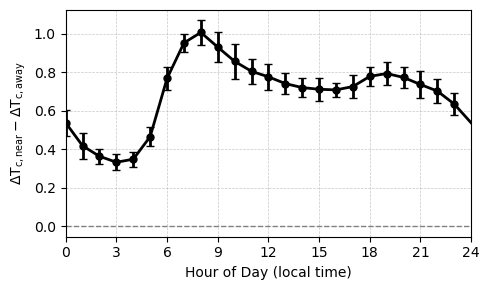

In [100]:
# Compute spatial mean for each timestep
spatial_mean_near = da_near_highway.mean(dim=["x", "y"], skipna=True)
spatial_mean_not_near = da_not_near_highway.mean(dim=["x", "y"], skipna=True)

# Convert to DataFrame for easier grouping by hour
df_near = spatial_mean_near.to_dataframe(name="near")
df_not_near = spatial_mean_not_near.to_dataframe(name="not_near")

# Group by hour to get diurnal cycle
grouped_near = df_near.groupby("hour")["near"]
grouped_not_near = df_not_near.groupby("hour")["not_near"]

# Compute mean, std, count, and 95% CI
mean_near = grouped_near.mean()
std_near = grouped_near.std()
n_near = grouped_near.count()
ci_near = 1.96 * std_near / np.sqrt(n_near)

mean_not_near = grouped_not_near.mean()
std_not_near = grouped_not_near.std()
n_not_near = grouped_not_near.count()
ci_not_near = 1.96 * std_not_near / np.sqrt(n_not_near)

# Compute difference and combined CI (assuming independence)
diff = mean_near - mean_not_near
ci_diff = np.sqrt(ci_near**2 + ci_not_near**2)

# Wrap diurnal cycle to hour 24 using concat
diff_wrapped = pd.concat([diff, pd.Series(diff.iloc[0], index=[24])])
ci_diff_wrapped = pd.concat([ci_diff, pd.Series(ci_diff.iloc[0], index=[24])])

# --- Plot ---
fig, ax = plt.subplots(figsize=(5, 3))

# Plot line with markers for hours 0-23 only
ax.errorbar(
    diff.index,
    diff.values,
    yerr=ci_diff.values,
    fmt='o',
    markersize=5,
    color='black',
    elinewidth=2,
    capsize=3,
    label='Near − Not Near Highway (95% CI)'
)

# Plot connecting line to hour 24 (no marker)
ax.plot(diff_wrapped.index, diff_wrapped.values, color='black', linewidth=2)

# Horizontal line at 0
ax.axhline(0, color='gray', linestyle='--', linewidth=1)

# X-axis settings: ticks every 3 hours
ax.set_xticks(np.arange(0, 25, 3))
ax.set_xlim(0, 24)

# Labels, legend, grid
ax.set_xlabel("Hour of Day (local time)")
ax.set_ylabel(r'$\mathrm{\Delta T_{c, near}} - \mathrm{\Delta T_{c, away}}$')
ax.grid(linewidth=0.5, alpha=0.7, linestyle='--')
os.makedirs(plot_dir, exist_ok=True)
save_filepath = os.path.join(plot_dir, 'diurnal_del_tc_near_highway.png')
plt.tight_layout()
plt.savefig(save_filepath, dpi=300, bbox_inches='tight')
plt.show()